# AIR POLLUTION FORECAST (PM2.5) USING DEEP LEARNING APPROACH (CNN & LSTM) --- GUCHENG STATION

## Dataset Source
- [Beijing Multi-Site Air Quality Dataset: UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data#)

- Only Nongzhanguan and Gucheng stations Air Quality Data were used in this work

# Connecting to Google Drive

In [ ]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Setting current working directory to project folder

In [ ]:
PWD = "gdrive/MyDrive/Projects/Hameedat Air Pollutant Forecast"
DATASET_PATH = 'PRSA_Data'
MODEL_PATH = 'models'
RESULTS_PATH = 'results'
CLEANED_DATASET_PATH = 'cleaned_datasets'

# setting working directory
%cd {PWD}

/content/gdrive/MyDrive/Projects/Hameedat Air Pollutant Forecast


In [ ]:
# MODEL_PATH = f'models'
# RESULTS_PATH = f'results'
# CLEANED_DATASET_PATH = 'cleaned_datasets'

In [ ]:
# Creating appropriate folders if not already existing

import os

# if not os.path.exists(DATASET_PATH):
#     os.mkdir(DATASET_PATH)

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

if not os.path.exists(CLEANED_DATASET_PATH):
    os.mkdir(CLEANED_DATASET_PATH)


# Installing dependencies

In [ ]:
# installing model architecture visualizer
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

# installing LSTM Forecast dependencies
!pip install neuralforecast
# !conda install "ray-tune" -c conda-forge

# for params tunning
!pip install ray torch torchvision hyperopt 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-y4p1yz5h
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-y4p1yz5h
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 26.5 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13719 sha256=c73f6d083d552652d9da7d8abb2a4fc2be89bc076dc0ea0d52359a1d18cb0bb3
  Stored in directory: /tmp/pip-ephem-wheel-cache-1m1sg9gk/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Importing libararies

In [ ]:
## Utilities
import os
import pickle
from math import sqrt
from numpy import log

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split, KFold

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Forecaster
# CNN, LSTM and RNN
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import load_model

from keras.optimizers import (Adam, SGD)
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler


## Performance metrics
from keras.metrics.regression_metrics import MeanAbsoluteError
from keras.metrics.regression_metrics import MeanSquaredError
from keras.metrics.regression_metrics import RootMeanSquaredError
from keras.metrics.regression_metrics import MeanAbsolutePercentageError

from keras.utils.vis_utils import plot_model
import visualkeras


# # LSTM & RNN forecaster with param tunning
# from neuralforecast import NeuralForecast
# from neuralforecast.auto import AutoLSTM
# from neuralforecast.auto import AutoRNN
# from neuralforecast.models import LSTM
# from neuralforecast.models import RNN
# from neuralforecast.losses.pytorch import (RMSE, MSE, MAE, MAPE)

## Hyper-parameter tunning using ray tune
import ray
from ray import air, tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.integration.keras import TuneReportCallback


## Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## Allowing Auto-viewing of plots without having to call plt.show() everytime
%matplotlib inline

In [ ]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['font.size']=12

# Loading datasets

In [ ]:
#import five Beijng mulit-site air quality data for different cities
Gu = pd.read_csv(f'{CLEANED_DATASET_PATH}/Gucheng_cleaned.csv', index_col=0, parse_dates=True)

# making index hourly time series
Gu.index.freq = 'H'

## Exploratory Data Analysis (EDA)

In [ ]:
Gu.head()

TEMP    PRES  DEWP  RAIN     wd  WSPM  PM2.5  PM10  SO2  \
datetime                                                                       
2013-03-01 00:00:00   0.1  1021.1 -18.6   0.0  315.0   4.4    6.0  18.0  5.0   
2013-03-01 01:00:00  -0.3  1021.5 -19.0   0.0  315.0   4.0    6.0  15.0  5.0   
2013-03-01 02:00:00  -0.7  1021.5 -19.8   0.0  292.5   4.6    5.0  18.0  5.5   
2013-03-01 03:00:00  -1.0  1022.7 -21.2   0.0  270.0   2.8    6.0  20.0  6.0   
2013-03-01 04:00:00  -1.3  1023.0 -21.4   0.0  292.5   3.6    5.0  17.0  5.0   

                     NO2     CO    O3  
datetime                               
2013-03-01 00:00:00  5.0  800.0  88.0  
2013-03-01 01:00:00  5.0  800.0  88.0  
2013-03-01 02:00:00  5.0  700.0  52.0  
2013-03-01 03:00:00  5.0  650.0  62.5  
2013-03-01 04:00:00  5.0  600.0  73.0

In [ ]:
# View data shape sizes
print(f'Gucheng Data shape: {Gu.shape}')

Gucheng Data shape: (35064, 12)


In [ ]:
Gu.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    35064 non-null  float64
 1   PRES    35064 non-null  float64
 2   DEWP    35064 non-null  float64
 3   RAIN    35064 non-null  float64
 4   wd      35064 non-null  float64
 5   WSPM    35064 non-null  float64
 6   PM2.5   35064 non-null  float64
 7   PM10    35064 non-null  float64
 8   SO2     35064 non-null  float64
 9   NO2     35064 non-null  float64
 10  CO      35064 non-null  float64
 11  O3      35064 non-null  float64
dtypes: float64(12)
memory usage: 3.5 MB


In [ ]:
#view data description
print(f'Gucheng:\n')
Gu.describe()

Gucheng:



TEMP          PRES          DEWP          RAIN            wd  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean      13.855824   1008.835693      2.600351      0.064374    199.136294   
std       11.294955     10.104302     13.790109      0.838142    111.194995   
min      -15.600000    984.000000    -34.600000      0.000000     22.500000   
25%        3.600000   1000.500000     -9.000000      0.000000     90.000000   
50%       14.800000   1008.500000      3.000000      0.000000    202.500000   
75%       23.500000   1017.000000     15.300000      0.000000    292.500000   
max       41.600000   1038.100000     27.400000     41.900000    360.000000   

               WSPM         PM2.5          PM10           SO2           NO2  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean       1.343667     84.074802    119.261567     15.705821     55.822315   
std        1.151055     82.994634     97.533240     23.282583     36.522738   
min        0.000000      2.000000      2.000000      0.285600      2.000000   
25%        0.600000     24.000000     45.000000      2.000000     26.000000   
50%        1.000000     60.000000    100.000000      7.000000     50.000000   
75%        1.800000    116.000000    167.000000     20.000000     79.000000   
max       12.000000    770.000000    994.000000    500.000000    276.000000   

                 CO            O3  
count  35064.000000  35064.000000  
mean    1338.100060     58.000001  
std     1214.044983     57.171816  
min      100.000000      0.214200  
25%      600.000000     10.000000  
50%      985.714286     45.000000  
75%     1680.652174     84.000000  
max    10000.000000    450.000000

In [ ]:
# Missing values
print('Gucheng:\n--------------\n')
print(Gu.isna().sum())


Gucheng:
--------------

TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
dtype: int64


# PREPROCESSING FOR MODELING

## My custom utility functions

In [ ]:
# MAPE: Mean absolute Percentage Error
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE']

In [ ]:
def save_model_pickle(model, filename):
  try:
    pickle.dump(model, open(f'{MODEL_PATH}/{filename}', 'wb'))
    print('Saved')
  except Exception as err:
    print(err)


def load_model_pickle(filename):
  try:
    model = pickle.load(open(f'{MODEL_PATH}/{filename}', 'rb'))
    return model
  except Exception as err:
    print(err)
    return None

In [ ]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    sum_y_true = np.sum(y_true)
    # mean_abs_prec_err = np.sum( np.abs(y_true - predictions) ) / sum_y_true
    # accuracy = 1 - mean_abs_prec_err
    MAPE = np.mean(np.abs(y_true - predictions) / y_true)
     
    results = {label: [mae, mse, rmse, r2, MAPE]}
    
    return pd.DataFrame(results, index=METRICS).round(3)


In [ ]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()



def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [ ]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations with PM2.5'):
    # Getting the Upper Triangle of the co-relation matrix
    upper_mat = np.triu(corr)
    upper_mat[np.diag_indices_from(upper_mat)] = False

    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True, cmap='Blues', mask=upper_mat,
                center=0, fmt='.2f', square=True)
    plt.title(title)


def visualize_series_single(series_data=None, days=None, title='PM2.5 Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    """
      model: {'additive' | 'multiplicative'}. 
          NOTE: 
            Use 'additive' if seasonal variation are relatively constant over time. i.e. linear.
            Use 'multiplicative' if the trend and seasonal variation increase or decrease over time.
    """

    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)
  

# using last 1 month as default for testing set
def split_train_test_series_single(series_data, test_size=24*31): 
    train, test = series_data[:-test_size], series_data[-test_size:]
    return (train, test)


# splita data series into CNN based data points
def deep_prepare_X_y_for_CNN(X=None, y=None, n_lags=6, kind='single'):
    """
    Converts X,y into a form suitable for 1D CNN model for time-series

    args:
        kind: the kind of Time series problem
          values: {'single', 'multi_input', 'parallel'}
            - 'single': One series data
            - 'multi_input': Multiple input series with one output
            - 'parallel': multiple_input series with multiple forecast, one for each series

        n_lags: the number of past data to use to forecast the next
    """
    newX, newY = list(), list()
    
    if kind == 'single':
        for i in range(len(X)):
            seqX = X.iloc[i].values
            seqX = seqX.reshape(X.shape[1], 1)
            newX.append(seqX)
        return np.array(newX), y.values

    elif kind == 'multi_input':
        for i in range(len(X)):
            end_id = i + n_lags
            if end_id > len(y): # at the end already
                break
            
            seqX, seqY = X.iloc[i:end_id].values, y.iloc[end_id-1]
            newX.append(seqX)
            newY.append(seqY)
        return np.array(newX), np.array(newY)
    
    elif kind == 'parallel':
        for i in range(len(X)):
            end_id = i + n_lags
            if end_id >= len(X): # at the end already
                break
            
            seqX, seqY = X.iloc[i:end_id,:].values, X.iloc[end_id, :].values
            # seqY = seqY.reshape()
            newX.append(seqX)
            newY.append(seqY)
        return np.array(newX), np.array(newY)

    else:
        return None, None

# Preparing data for Multi-step forecast 
def deep_prepare_X_y_for_CNN_multi_step(
    X=None, y=None, n_lags=6, 
    future_steps=None, start=0, end=None):
    """
    Converts X,y into a form suitable for 1D CNN model for time-series

    args:
        kind: the kind of Time series problem
          values: {'single', 'multi_input', 'parallel'}
            - 'single': One series data
            - 'multi_input': Multiple input series with one output
            - 'parallel': multiple_input series with multiple forecast, one for each series

        n_lags: the number of past data to use to forecast the next
    """

    newX = []
    newY = []
    start = start + n_lags
    if end is None:
        end = len(X) - future_steps
    for i in range(start, end):
        indices = range(i-n_lags, i)
        newX.append(X[indices])
        indicey = range(i+1, i+1+future_steps)
        newY.append(y[indicey])

    return np.array(newX), np.array(newY)



def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='PM2.5')
    # return np.array(data), predictions
    return predictions

In [ ]:
x = {
    'x1': [10,20,30,40,50,60,70,80,90],
    'x2': [100,200,300,400,500,600,700,800,900],
    'y': [110, 220, 330, 440, 550, 660, 770, 880, 990]
}
xf = pd.DataFrame(x)
xf

x1   x2    y
0  10  100  110
1  20  200  220
2  30  300  330
3  40  400  440
4  50  500  550
5  60  600  660
6  70  700  770
7  80  800  880
8  90  900  990

In [ ]:
xfnew = series_to_supervised_dataset_single(xf.y, n_lags=3)
xfnew

yt-3   yt-2   yt-1    y
3  110.0  220.0  330.0  440
4  220.0  330.0  440.0  550
5  330.0  440.0  550.0  660
6  440.0  550.0  660.0  770
7  550.0  660.0  770.0  880
8  660.0  770.0  880.0  990

In [ ]:
split_train_test_series_multivariate_series(xfnew,test_size=2)

(    yt-3   yt-2   yt-1
 3  110.0  220.0  330.0
 4  220.0  330.0  440.0
 5  330.0  440.0  550.0
 6  440.0  550.0  660.0,
 3    440
 4    550
 5    660
 6    770
 Name: y, dtype: int64,
     yt-3   yt-2   yt-1
 7  550.0  660.0  770.0
 8  660.0  770.0  880.0,
 7    880
 8    990
 Name: y, dtype: int64)

# Data Segmentation

In [ ]:
features_X_guch = Gu[Gu.columns[:6]]
y_pm25_guch = Gu['PM2.5']
y_pm10_guch = Gu.PM10
y_so2_guch = Gu.SO2
y_no2_guch = Gu.NO2
y_co_guch = Gu.CO
y_o3_guch = Gu.O3

# Preparing data for Time-series Modeling

## Scaling the features (Metereological variables)

In [ ]:
scaler_guch = StandardScaler()

In [ ]:
# Scaling Gucheng station Feature (Weather) data

scaled_features_X_guch = scaler_guch.fit_transform(features_X_guch)
scaled_features_X_guch  = pd.DataFrame(scaled_features_X_guch, index=features_X_guch.index, columns=features_X_guch.columns)
scaled_features_X_guch.head()

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.217891  1.213788 -1.537381 -0.076806  1.042002   
2013-03-01 01:00:00 -1.253305  1.253376 -1.566388 -0.076806  1.042002   
2013-03-01 02:00:00 -1.288720  1.253376 -1.624401 -0.076806  0.839651   
2013-03-01 03:00:00 -1.315281  1.372139 -1.725925 -0.076806  0.637301   
2013-03-01 04:00:00 -1.341842  1.401830 -1.740428 -0.076806  0.839651   

                         WSPM  
datetime                       
2013-03-01 00:00:00  2.655283  
2013-03-01 01:00:00  2.307770  
2013-03-01 02:00:00  2.829039  
2013-03-01 03:00:00  1.265234  
2013-03-01 04:00:00  1.960258

In [ ]:
# Saving the scaler object
save_model_pickle(scaler_guch, filename='Gucheng_scaler_obj.pickle')

Saved


---

In [ ]:
pm25_data_guch = pd.concat([features_X_guch, y_pm25_guch], axis='columns')

In [ ]:
pm25_data_guch.head(3)

TEMP    PRES  DEWP  RAIN     wd  WSPM  PM2.5
datetime                                                         
2013-03-01 00:00:00   0.1  1021.1 -18.6   0.0  315.0   4.4    6.0
2013-03-01 01:00:00  -0.3  1021.5 -19.0   0.0  315.0   4.0    6.0
2013-03-01 02:00:00  -0.7  1021.5 -19.8   0.0  292.5   4.6    5.0

---

# Gucheng Station

## CNN (without Exogenous Metereological Variables)


- 1 day forecast (steps)
- 1 day (24 hrs) lag
- CNN
- Gucheng station data

In [ ]:
TEST_SIZE = int((20 / 100) * len(y_pm25_guch))
N_STEPS = 24
N_LAGS = 24
N_FEATURES = len(features_X_guch.columns)

#### Data Preparation and preprocessing

In [ ]:
data_y_pm25 = series_to_supervised_dataset_single(y_pm25_guch, n_lags=N_LAGS)
data_y_pm25.head()

PM25t-24  PM25t-23  PM25t-22  PM25t-21  PM25t-20  \
datetime                                                                
2013-03-02 00:00:00       6.0       6.0       5.0       6.0       5.0   
2013-03-02 01:00:00       6.0       5.0       6.0       5.0       4.0   
2013-03-02 02:00:00       5.0       6.0       5.0       4.0       3.0   
2013-03-02 03:00:00       6.0       5.0       4.0       3.0       5.0   
2013-03-02 04:00:00       5.0       4.0       3.0       5.0       5.0   

                     PM25t-19  PM25t-18  PM25t-17  PM25t-16  PM25t-15  ...  \
datetime                                                               ...   
2013-03-02 00:00:00       4.0       3.0       5.0       5.0       4.0  ...   
2013-03-02 01:00:00       3.0       5.0       5.0       4.0       7.0  ...   
2013-03-02 02:00:00       5.0       5.0       4.0       7.0       3.0  ...   
2013-03-02 03:00:00       5.0       4.0       7.0       3.0       9.0  ...   
2013-03-02 04:00:00       4.0       7.0       3.0       9.0      10.0  ...   

                     PM25t-9  PM25t-8  PM25t-7  PM25t-6  PM25t-5  PM25t-4  \
datetime                                                                    
2013-03-02 00:00:00     13.0     11.0     10.0     11.0     11.0     13.0   
2013-03-02 01:00:00     11.0     10.0     11.0     11.0     13.0     15.0   
2013-03-02 02:00:00     10.0     11.0     11.0     13.0     15.0     16.0   
2013-03-02 03:00:00     11.0     11.0     13.0     15.0     16.0     16.0   
2013-03-02 04:00:00     11.0     13.0     15.0     16.0     16.0     14.0   

                     PM25t-3  PM25t-2  PM25t-1  PM2.5  
datetime                                               
2013-03-02 00:00:00     15.0     16.0     16.0   14.0  
2013-03-02 01:00:00     16.0     16.0     14.0   18.0  
2013-03-02 02:00:00     16.0     14.0     18.0   19.0  
2013-03-02 03:00:00     14.0     18.0     19.0   15.0  
2013-03-02 04:00:00     18.0     19.0     15.0   13.0  

[5 rows x 25 columns]

In [ ]:
Xtrain_guch, ytrain_guch, Xtest_guch, ytest_guch = split_train_test_series_multivariate_series(data_y_pm25, test_size=TEST_SIZE)

In [ ]:
Xtrain_guch.head(2)

PM25t-24  PM25t-23  PM25t-22  PM25t-21  PM25t-20  \
datetime                                                                
2013-03-02 00:00:00       6.0       6.0       5.0       6.0       5.0   
2013-03-02 01:00:00       6.0       5.0       6.0       5.0       4.0   

                     PM25t-19  PM25t-18  PM25t-17  PM25t-16  PM25t-15  ...  \
datetime                                                               ...   
2013-03-02 00:00:00       4.0       3.0       5.0       5.0       4.0  ...   
2013-03-02 01:00:00       3.0       5.0       5.0       4.0       7.0  ...   

                     PM25t-10  PM25t-9  PM25t-8  PM25t-7  PM25t-6  PM25t-5  \
datetime                                                                     
2013-03-02 00:00:00      13.0     13.0     11.0     10.0     11.0     11.0   
2013-03-02 01:00:00      13.0     11.0     10.0     11.0     11.0     13.0   

                     PM25t-4  PM25t-3  PM25t-2  PM25t-1  
datetime                                                 
2013-03-02 00:00:00     13.0     15.0     16.0     16.0  
2013-03-02 01:00:00     15.0     16.0     16.0     14.0  

[2 rows x 24 columns]

In [ ]:
ytrain_guch.head(2)

datetime
2013-03-02 00:00:00    14.0
2013-03-02 01:00:00    18.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Shape of X: {features_X_guch.shape}')
print(f'Shape of Xtrain: {Xtrain_guch.shape}')
print(f'Shape of Xtest: {Xtest_guch.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28028, 24)
Shape of Xtest: (7012, 24)


In [ ]:
deep_Xtrain_guch, deep_ytrain_guch = deep_prepare_X_y_for_CNN(X=Xtrain_guch, y=ytrain_guch, n_lags=N_LAGS, kind='single')
deep_Xtest_guch, deep_ytest_guch = deep_prepare_X_y_for_CNN(X=Xtest_guch, y=ytest_guch, n_lags=N_LAGS, kind='single')

In [ ]:
print(f'Shape of Xtrain: {Xtrain_guch.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_guch.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_guch.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_guch.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_guch.shape}')

Shape of Xtrain: (28028, 24)
Shape of Deep-Xtrain: (28028, 24, 1)
Shape of Deep-Xtest: (7012, 24, 1)
Shape of Deep-ytrain: (28028,)
Shape of Deep-ytest: (7012,)


In [ ]:
for i in range(2):
    print(deep_Xtrain_guch[i], deep_ytrain_guch[i])

[[ 6.]
 [ 6.]
 [ 5.]
 [ 6.]
 [ 5.]
 [ 4.]
 [ 3.]
 [ 5.]
 [ 5.]
 [ 4.]
 [ 7.]
 [ 3.]
 [ 9.]
 [10.]
 [13.]
 [13.]
 [11.]
 [10.]
 [11.]
 [11.]
 [13.]
 [15.]
 [16.]
 [16.]] 14.0
[[ 6.]
 [ 5.]
 [ 6.]
 [ 5.]
 [ 4.]
 [ 3.]
 [ 5.]
 [ 5.]
 [ 4.]
 [ 7.]
 [ 3.]
 [ 9.]
 [10.]
 [13.]
 [13.]
 [11.]
 [10.]
 [11.]
 [11.]
 [13.]
 [15.]
 [16.]
 [16.]
 [14.]] 18.0


#### CNN Model Building

In [ ]:
N_EPOCHS = 150
BATCH_SIZE = 20

In [ ]:
# del cnn_model_guch

In [ ]:
cnn_model_guch = Sequential()

# input layer and hidden layer1
cnn_model_guch.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
cnn_model_guch.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_guch.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_guch.add(MaxPooling1D(pool_size=2))

cnn_model_guch.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_guch.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_guch.add(MaxPooling1D(pool_size=2))

cnn_model_guch.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_guch.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_guch.add(MaxPooling1D(pool_size=2))

cnn_model_guch.add(Flatten())
cnn_model_guch.add(Dense(units=16, activation='relu'))

# Output layer
cnn_model_guch.add(Dense(units=1))

# optimizer (adam)
adam_optimizer = Adam(learning_rate=0.001)

cnn_model_guch.compile(
    optimizer=adam_optimizer, 
    loss='mse', 
    metrics=[
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        MeanSquaredError(),
        RootMeanSquaredError()
    ]
  )


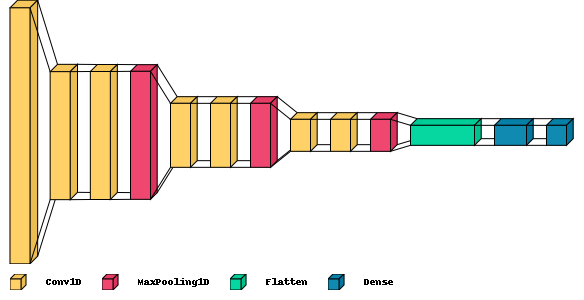

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    cnn_model_guch, legend=True, 
    scale_xy=1,
    scale_z=2,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_cnn_pm25_Gucheng_architecture.png')

In [ ]:
cnn_model_guch.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 256)           768       
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 128)           65664     
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 128)           32896     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 128)          0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 9, 64)             16448     
                                                                 
 conv1d_4 (Conv1D)           (None, 8, 64)             8256      
                                                        

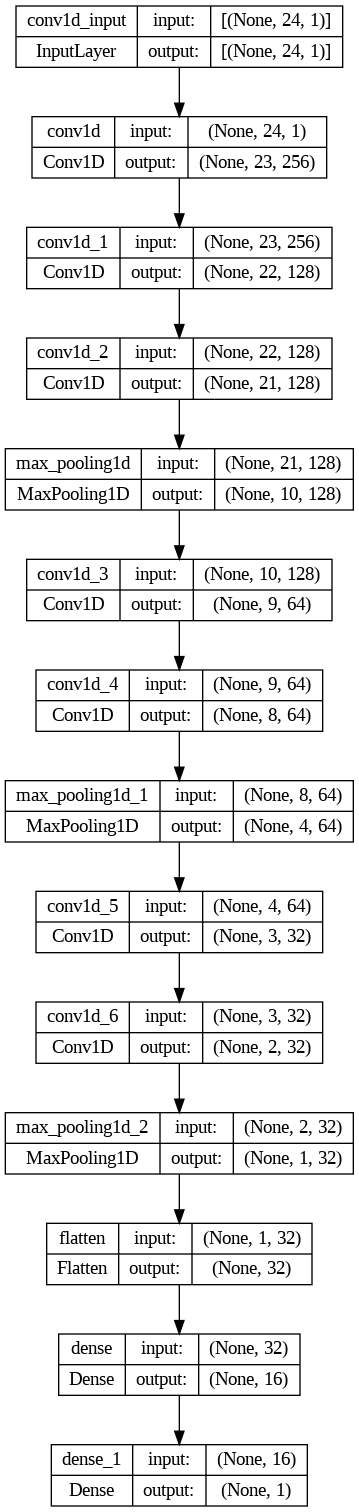

In [ ]:
# Model Architecture
plot_model(cnn_model_guch, to_file='cnn_model_guch.png', show_shapes=True, show_layer_names=True)

In [ ]:
# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05, # p-value
    patience=5,
    restore_best_weights=True,
)

# Fitting the model
history = cnn_model_guch.fit(
    deep_Xtrain_guch, deep_ytrain_guch, 
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS, 
    callbacks=[early_stopper],
    verbose=1)

Epoch 1/150
1402/1402 [==============================] - 18s 7ms/step - loss: 1873.9602 - mean_absolute_error: 26.8836 - mean_absolute_percentage_error: 71.6416 - mean_squared_error: 1873.9602 - root_mean_squared_error: 43.2893
Epoch 2/150
1402/1402 [==============================] - 7s 5ms/step - loss: 1347.7167 - mean_absolute_error: 22.4849 - mean_absolute_percentage_error: 58.4005 - mean_squared_error: 1347.7167 - root_mean_squared_error: 36.7113
Epoch 3/150
1402/1402 [==============================] - 9s 6ms/step - loss: 1242.7882 - mean_absolute_error: 21.5449 - mean_absolute_percentage_error: 56.6680 - mean_squared_error: 1242.7882 - root_mean_squared_error: 35.2532
Epoch 4/150
1402/1402 [==============================] - 7s 5ms/step - loss: 1242.6514 - mean_absolute_error: 21.5409 - mean_absolute_percentage_error: 56.3484 - mean_squared_error: 1242.6514 - root_mean_squared_error: 35.2513
Epoch 5/150
1402/1402 [==============================] - 9s 6ms/step - loss: 1197.8463 - me

In [ ]:
# history.history

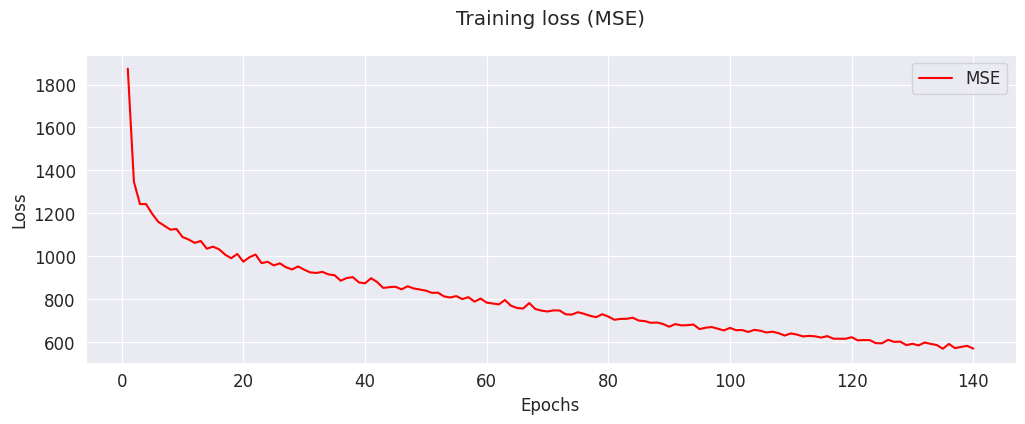

In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='MSE', color='r')
plt.title('Training loss (MSE)\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 21.722222222222214, 'Epochs')

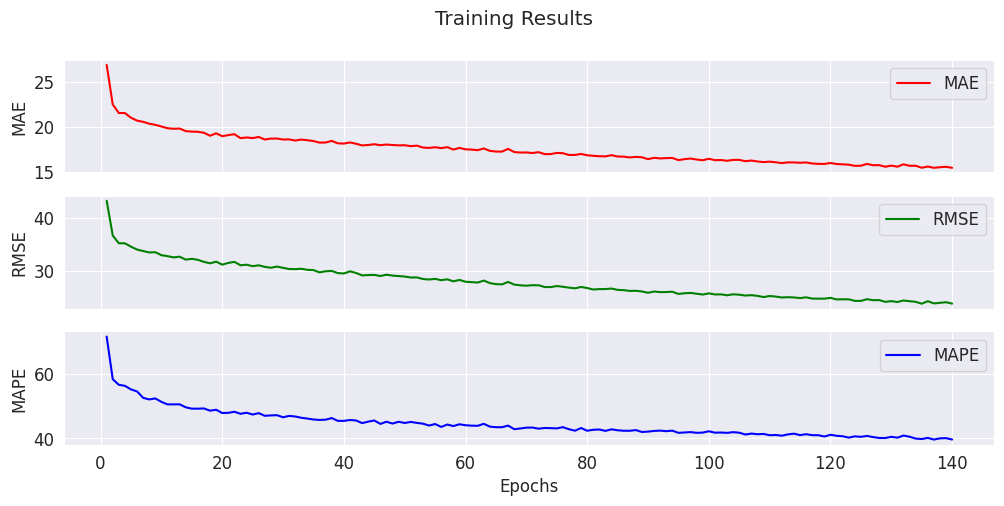

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


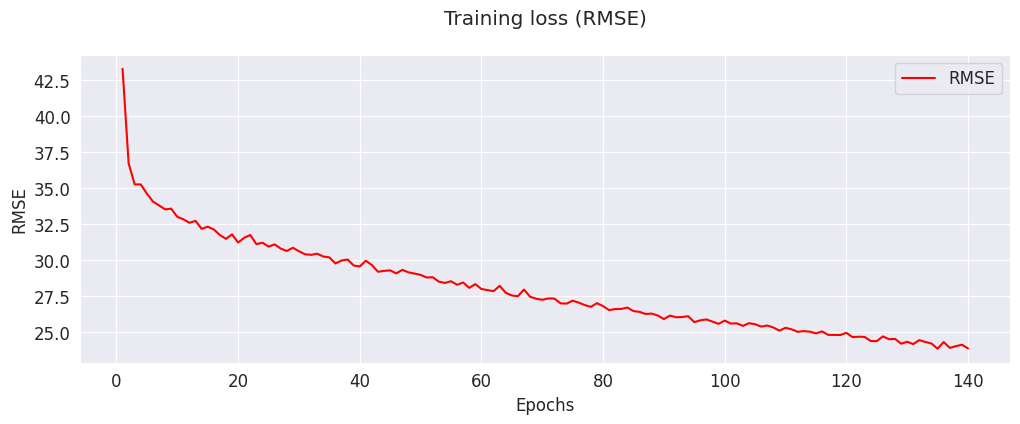

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE)\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# Saving the trained model
cnn_model_guch.save(f'{MODEL_PATH}/cnn_model_no_met_Gucheng.h5')

#### Making Forecasts

In [ ]:
# Loading saved trained model
cnn_model_guch = load_model(f'{MODEL_PATH}/cnn_model_no_met_Gucheng.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- CNN

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest_guch[:steps]
one_dayy =  deep_ytest_guch[:steps]
predictions = cnn_model_guch.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 0s 326ms/step


array([[43.573418],
       [35.11505 ],
       [56.341103],
       [39.14761 ],
       [66.46099 ]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_guch.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_guch.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    43.573418
2016-05-12 21:00:00    35.115051
2016-05-12 22:00:00    56.341103
2016-05-12 23:00:00    39.147610
2016-05-13 00:00:00    66.460991
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    28.0
2016-05-12 21:00:00    38.0
2016-05-12 22:00:00    70.0
2016-05-12 23:00:00    48.0
2016-05-13 00:00:00    35.0
Freq: H, Name: PM2.5, dtype: float64

<function matplotlib.pyplot.legend(*args, **kwargs)>

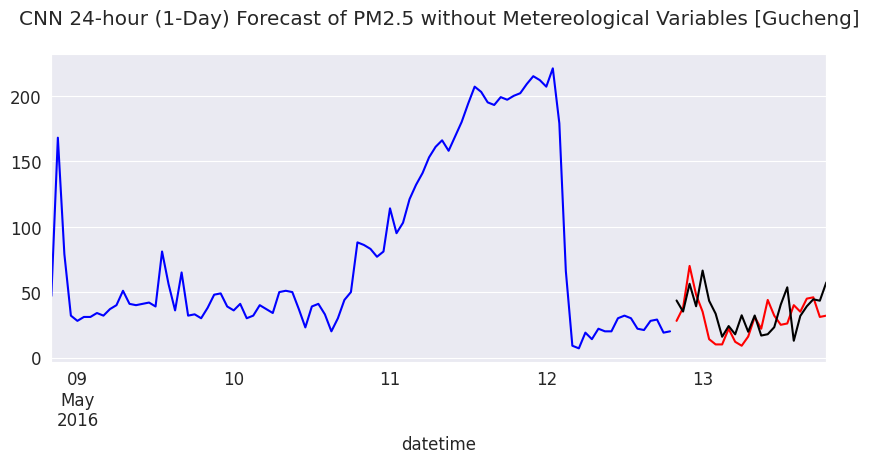

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_guch[-steps*4:], index=Xtrain_guch.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 24-hour (1-Day) Forecast of PM2.5 without Metereological Variables [Gucheng]\n')
plt.legend

In [ ]:
results_cnn_one_day = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_day')
results_cnn_one_day

cnn_one_day
MAE             13.581
MSE            288.699
RMSE            16.991
R-Squared       -0.382
MAPE             0.637

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest_guch[:steps]
one_weeky =  deep_ytest_guch[:steps]
predictions = cnn_model_guch.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 4ms/step


array([[43.573418],
       [35.11505 ],
       [56.341103],
       [39.14761 ],
       [66.46099 ]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_guch.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_guch.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    43.573418
2016-05-12 21:00:00    35.115051
2016-05-12 22:00:00    56.341103
2016-05-12 23:00:00    39.147610
2016-05-13 00:00:00    66.460991
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    28.0
2016-05-12 21:00:00    38.0
2016-05-12 22:00:00    70.0
2016-05-12 23:00:00    48.0
2016-05-13 00:00:00    35.0
Freq: H, Name: PM2.5, dtype: float64

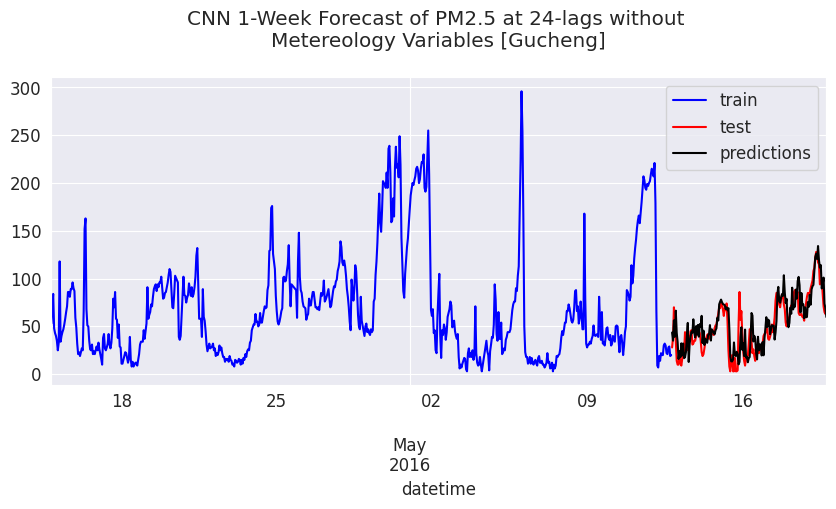

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_guch[-steps*4:], index=Xtrain_guch.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 1-Week Forecast of PM2.5 at 24-lags without \nMetereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_cnn_one_week = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_week')
results_cnn_one_week

cnn_one_week
MAE              11.926
MSE             271.536
RMSE             16.478
R-Squared         0.653
MAPE              0.559

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest_guch[:steps]
one_monthy =  deep_ytest_guch[:steps]
predictions = cnn_model_guch.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 2ms/step


array([[43.573418],
       [35.11505 ],
       [56.341103],
       [39.14761 ],
       [66.46099 ]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_guch.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_guch.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    43.573418
2016-05-12 21:00:00    35.115051
2016-05-12 22:00:00    56.341103
2016-05-12 23:00:00    39.147610
2016-05-13 00:00:00    66.460991
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    28.0
2016-05-12 21:00:00    38.0
2016-05-12 22:00:00    70.0
2016-05-12 23:00:00    48.0
2016-05-13 00:00:00    35.0
Freq: H, Name: PM2.5, dtype: float64

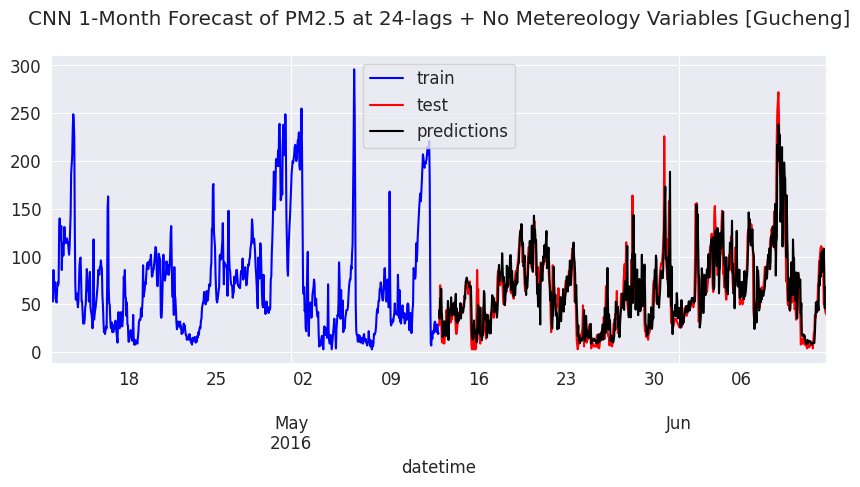

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_guch[-steps:], index=Xtrain_guch.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 1-Month Forecast of PM2.5 at 24-lags + No Metereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_cnn_one_month = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_month')
results_cnn_one_month

cnn_one_month
MAE               15.925
MSE              500.622
RMSE              22.375
R-Squared          0.702
MAPE               0.427

#### Combined Results

In [ ]:
combined_results_cnn_no_met_24lags = pd.concat([
    results_cnn_one_day, 
    results_cnn_one_week, 
    results_cnn_one_month
], axis='columns')

combined_results_cnn_no_met_24lags

cnn_one_day  cnn_one_week  cnn_one_month
MAE             13.581        11.926         15.925
MSE            288.699       271.536        500.622
RMSE            16.991        16.478         22.375
R-Squared       -0.382         0.653          0.702
MAPE             0.637         0.559          0.427

<Axes: title={'center': 'Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Gucheng]\n'}>

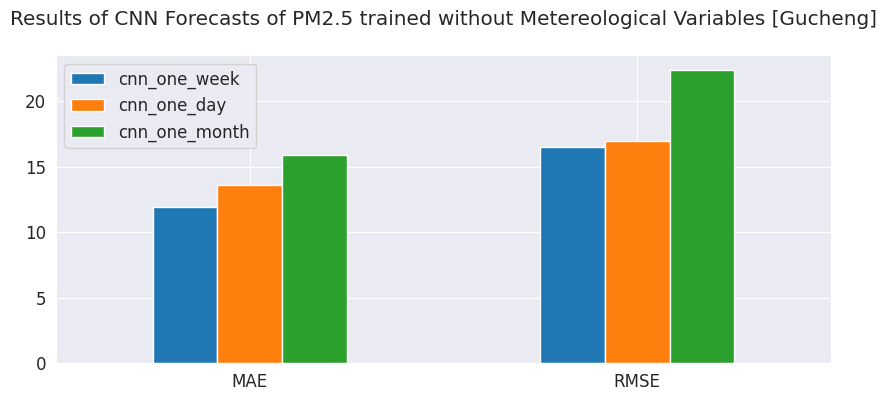

In [ ]:
combined_results_cnn_no_met_24lags.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)

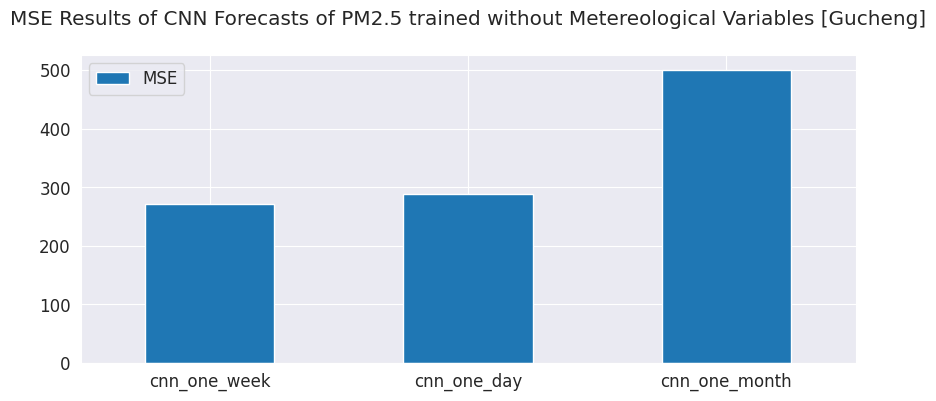

In [ ]:
combined_results_cnn_no_met_24lags.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

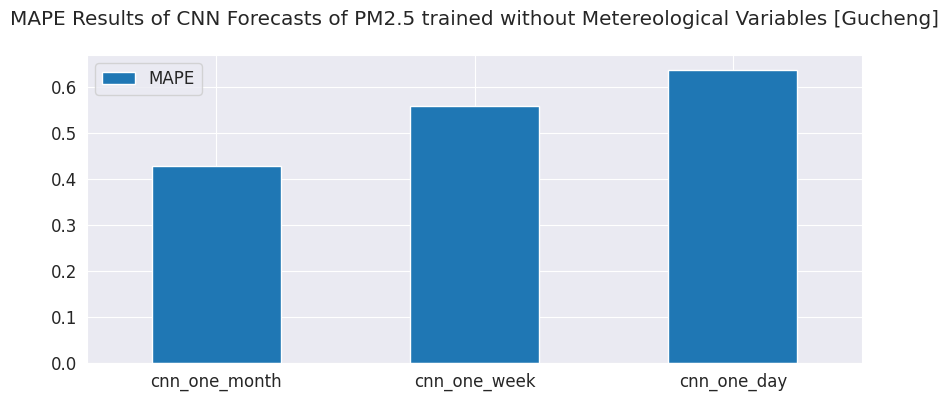

In [ ]:
combined_results_cnn_no_met_24lags.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

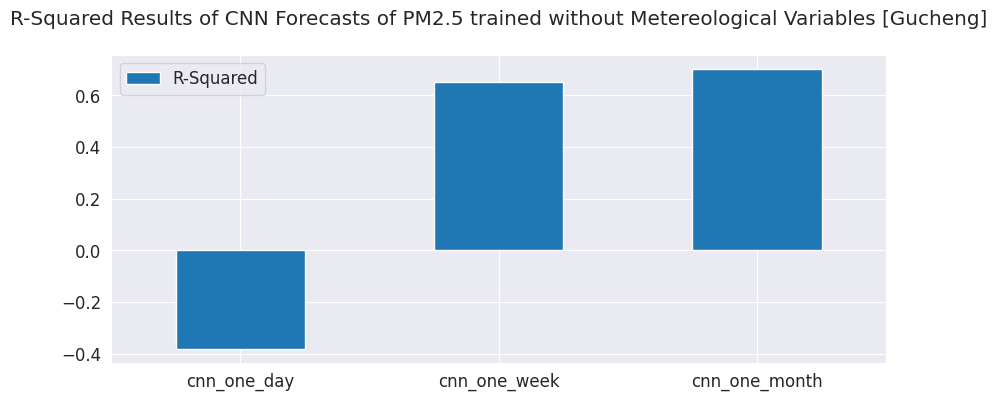

In [ ]:
combined_results_cnn_no_met_24lags.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of CNN Forecasts of PM2.5 trained without Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
combined_results_cnn_no_met_24lags.to_csv(f'{RESULTS_PATH}/combined_results_cnn_no_met_24lags_Gucheng.csv')

## CNN + All Exogenous Metereological Variables


- 1 day forecast (steps)
- 1 day (24 hrs) lag
- CNN
- Gucheng station data

In [ ]:
TEST_SIZE = int((20 / 100) * len(y_pm25_guch)) # 20%
N_LAGS = 24
N_FEATURES = 6

#### Data Preparation and preprocessing

In [ ]:
# merged scaled data and target
data_pm25_exo = pd.concat([scaled_features_X_guch, y_pm25_guch], axis='columns')
data_pm25_exo.head()

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.217891  1.213788 -1.537381 -0.076806  1.042002   
2013-03-01 01:00:00 -1.253305  1.253376 -1.566388 -0.076806  1.042002   
2013-03-01 02:00:00 -1.288720  1.253376 -1.624401 -0.076806  0.839651   
2013-03-01 03:00:00 -1.315281  1.372139 -1.725925 -0.076806  0.637301   
2013-03-01 04:00:00 -1.341842  1.401830 -1.740428 -0.076806  0.839651   

                         WSPM  PM2.5  
datetime                              
2013-03-01 00:00:00  2.655283    6.0  
2013-03-01 01:00:00  2.307770    6.0  
2013-03-01 02:00:00  2.829039    5.0  
2013-03-01 03:00:00  1.265234    6.0  
2013-03-01 04:00:00  1.960258    5.0

In [ ]:
# Data Segmentation (80% training : 20% testing)

Xtrain_guch_exo, ytrain_guch_exo, Xtest_guch_exo, ytest_guch_exo = \
    split_train_test_series_multivariate_series(
        data_pm25_exo, test_size=TEST_SIZE)

In [ ]:
Xtrain_guch_exo.head(2)

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.217891  1.213788 -1.537381 -0.076806  1.042002   
2013-03-01 01:00:00 -1.253305  1.253376 -1.566388 -0.076806  1.042002   

                         WSPM  
datetime                       
2013-03-01 00:00:00  2.655283  
2013-03-01 01:00:00  2.307770

In [ ]:
ytrain_guch_exo.head(2)

datetime
2013-03-01 00:00:00    6.0
2013-03-01 01:00:00    6.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Shape of X: {features_X_guch.shape}')
print(f'Shape of Xtrain: {Xtrain_guch_exo.shape}')
print(f'Shape of Xtest: {Xtest_guch_exo.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28052, 6)
Shape of Xtest: (7012, 6)


In [ ]:
deep_Xtrain_guch_exo, deep_ytrain_guch_exo = deep_prepare_X_y_for_CNN(
    X=Xtrain_guch_exo, y=ytrain_guch_exo, n_lags=N_LAGS, kind='multi_input')


deep_Xtest_guch_exo, deep_ytest_guch_exo = deep_prepare_X_y_for_CNN(
    X=Xtest_guch_exo, y=ytest_guch_exo, n_lags=N_LAGS, kind='multi_input')

In [ ]:
print(f'Shape of Xtrain: {Xtrain_guch_exo.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_guch_exo.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_guch_exo.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_guch_exo.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_guch_exo.shape}')

Shape of Xtrain: (28052, 6)
Shape of Deep-Xtrain: (28029, 24, 6)
Shape of Deep-Xtest: (6989, 24, 6)
Shape of Deep-ytrain: (28029,)
Shape of Deep-ytest: (6989,)


In [ ]:
for i in range(2):
    print(deep_Xtrain_guch_exo[i], deep_ytrain_guch_exo[i])

[[-1.21789063  1.21378819 -1.53738112 -0.07680631  1.04200157  2.65528256]
 [-1.25330518  1.25337586 -1.56638783 -0.07680631  1.04200157  2.30777032]
 [-1.28871972  1.25337586 -1.62440125 -0.07680631  0.83965144  2.82903868]
 [-1.31528063  1.37213885 -1.72592474 -0.07680631  0.63730132  1.2652336 ]
 [-1.34184154  1.40182959 -1.7404281  -0.07680631  0.83965144  1.96025808]
 [-1.38610972  1.46121109 -1.77668649 -0.07680631 -0.98149966 -0.12481536]
 [-1.45693881  1.5304895  -1.66791132 -0.07680631 -1.18384979 -0.12481536]
 [-1.30642699  1.65914941 -1.675163   -0.07680631 -1.18384979 -0.21169342]
 [-1.21789063  1.70863399 -1.66065964 -0.07680631 -1.18384979  1.43898972]
 [-1.12935427  1.70863399 -1.68241468 -0.07680631 -1.38619991  1.2652336 ]
 [-1.05852518  1.70863399 -1.73317642 -0.07680631 -1.18384979  1.43898972]
 [-0.93457427  1.70863399 -1.70416971 -0.07680631 -1.18384979  1.61274584]
 [-0.86374518  1.60966483 -1.66065964 -0.07680631 -1.18384979  1.61274584]
 [-0.75750154  1.51069567

#### CNN Model Building

In [ ]:
N_EPOCHS = 150
BATCH_SIZE = 20
N_LAGS = 24
N_FEATURES = 6 # no of input variables

In [ ]:
# del cnn_model_guch_exo

In [ ]:
cnn_model_guch_exo = Sequential()

# input layer and hidden layer1
cnn_model_guch_exo.add(Conv1D(filters=256, kernel_size=2, activation='relu', 
                              input_shape=(N_LAGS, N_FEATURES)))
cnn_model_guch_exo.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_guch_exo.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_guch_exo.add(MaxPooling1D(pool_size=2))

cnn_model_guch_exo.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_guch_exo.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_guch_exo.add(MaxPooling1D(pool_size=2))

cnn_model_guch_exo.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_guch_exo.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_guch_exo.add(MaxPooling1D(pool_size=2))

cnn_model_guch_exo.add(Flatten())
cnn_model_guch_exo.add(Dense(units=16, activation='relu'))

# Output layer
cnn_model_guch_exo.add(Dense(units=1))

# optimizer (adam)
adam_optimizer = Adam(learning_rate=0.001)

cnn_model_guch_exo.compile(
    optimizer=adam_optimizer, 
    loss='mse', 
    metrics=[
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        MeanSquaredError(),
        RootMeanSquaredError()
    ]
  )


In [ ]:
cnn_model_guch_exo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 23, 256)           3328      
                                                                 
 conv1d_8 (Conv1D)           (None, 22, 128)           65664     
                                                                 
 conv1d_9 (Conv1D)           (None, 21, 128)           32896     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 10, 128)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 9, 64)             16448     
                                                                 
 conv1d_11 (Conv1D)          (None, 8, 64)             8256      
                                                      

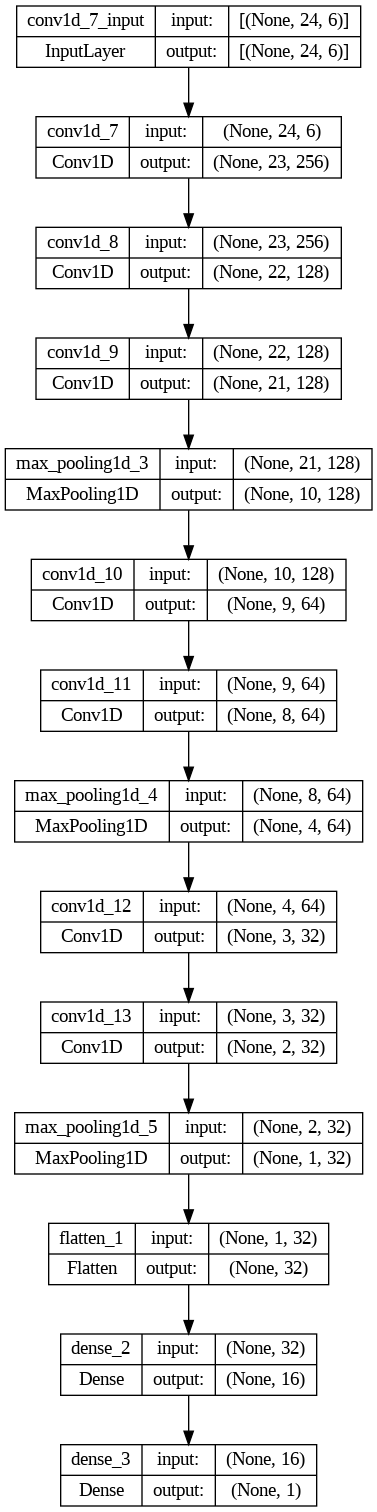

In [ ]:
# Model Architecture
plot_model(cnn_model_guch_exo, to_file='cnn_model_guch_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

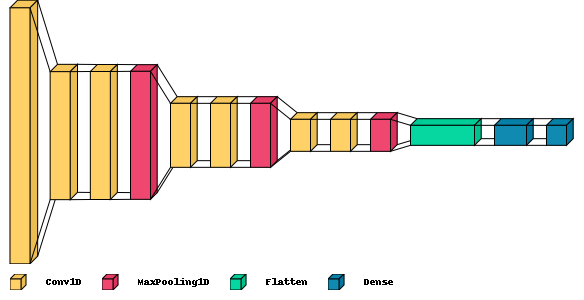

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    cnn_model_guch_exo, legend=True, 
    scale_xy=1,
    scale_z=2,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_cnn_pm25_with_met_var_Gucheng_architecture.png')

In [ ]:
# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# Fitting the model
history = cnn_model_guch_exo.fit(
    deep_Xtrain_guch_exo, deep_ytrain_guch_exo, 
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS, 
    callbacks=[early_stopper],
    verbose=1)

Epoch 1/150
1402/1402 [==============================] - 8s 5ms/step - loss: 4564.1284 - mean_absolute_error: 47.6843 - mean_absolute_percentage_error: 150.1232 - mean_squared_error: 4564.1284 - root_mean_squared_error: 67.5583
Epoch 2/150
1402/1402 [==============================] - 9s 7ms/step - loss: 3217.4224 - mean_absolute_error: 38.8319 - mean_absolute_percentage_error: 98.2350 - mean_squared_error: 3217.4224 - root_mean_squared_error: 56.7223
Epoch 3/150
1402/1402 [==============================] - 7s 5ms/step - loss: 2900.5349 - mean_absolute_error: 36.3903 - mean_absolute_percentage_error: 88.7448 - mean_squared_error: 2900.5347 - root_mean_squared_error: 53.8566
Epoch 4/150
1402/1402 [==============================] - 9s 6ms/step - loss: 2714.1912 - mean_absolute_error: 35.1047 - mean_absolute_percentage_error: 84.4387 - mean_squared_error: 2714.1912 - root_mean_squared_error: 52.0979
Epoch 5/150
1402/1402 [==============================] - 7s 5ms/step - loss: 2512.8503 - me

In [ ]:
# history.history
best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["mean_squared_error"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')


TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 106
MAE: 8.356362342834473
MSE: 125.6905517578125
RMSE: 11.211179733276367
MAPE: 23.47871208190918


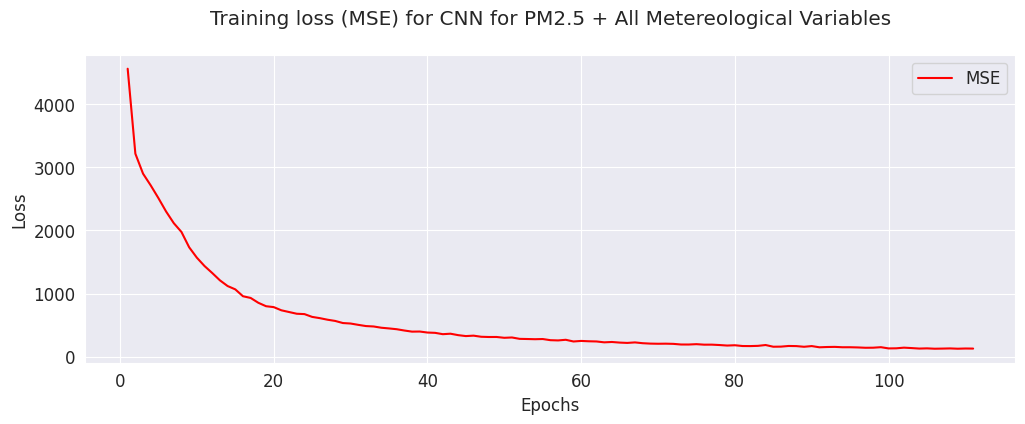

In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for CNN for PM2.5 + All Metereological Variables\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 21.722222222222214, 'Epochs')

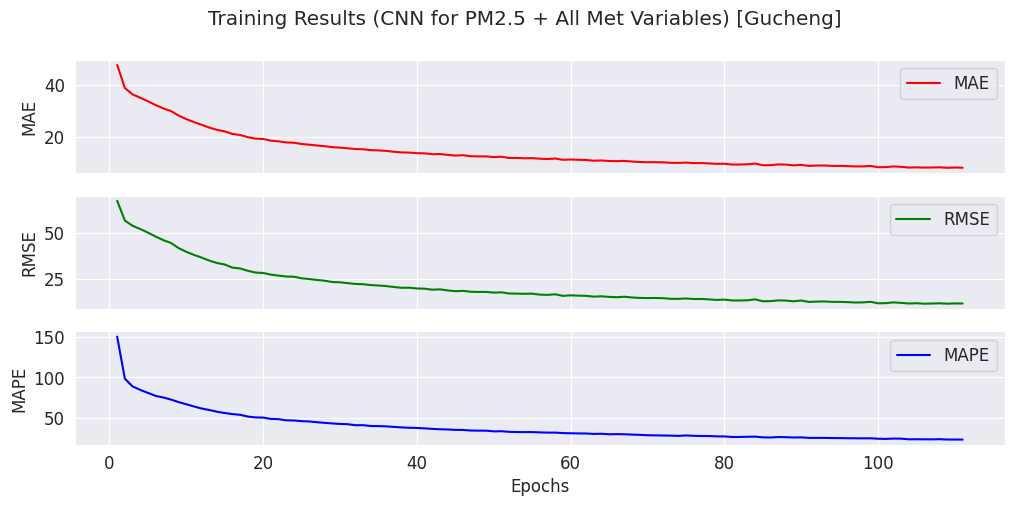

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (CNN for PM2.5 + All Met Variables) [Gucheng]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


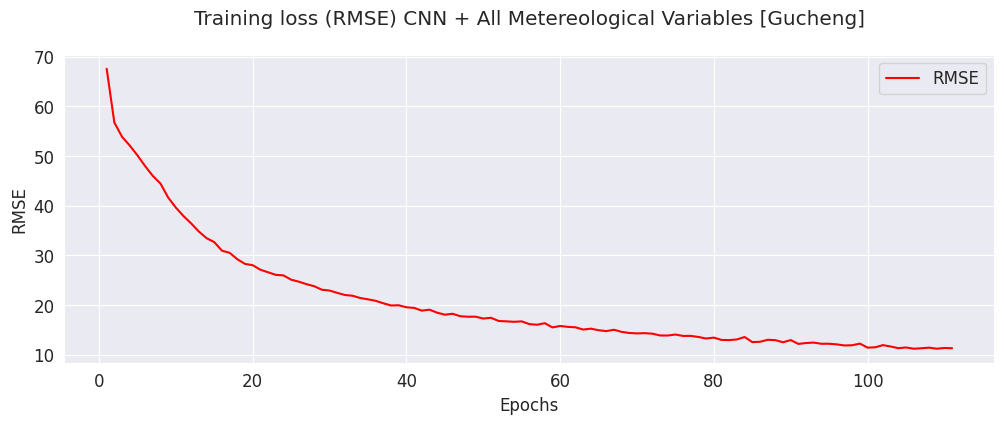

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) CNN + All Metereological Variables [Gucheng]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# Saving trained model
cnn_model_guch_exo.save(f'{MODEL_PATH}/cnn_model_pm25_with_all_met_vars_Gucheng.h5')

#### Making Forecasts

In [ ]:
# Loading saved trained model
cnn_model_guch_exo = load_model(f'{MODEL_PATH}/cnn_model_pm25_with_all_met_vars_Gucheng.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- CNN

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest_guch_exo[:steps]
one_dayy =  deep_ytest_guch_exo[:steps]
predictions = cnn_model_guch_exo.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 0s 240ms/step


array([[42.03264 ],
       [36.654606],
       [39.97032 ],
       [55.937626],
       [71.259995]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_guch_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_guch_exo.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    42.032639
2016-05-12 21:00:00    36.654606
2016-05-12 22:00:00    39.970322
2016-05-12 23:00:00    55.937626
2016-05-13 00:00:00    71.259995
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

<function matplotlib.pyplot.legend(*args, **kwargs)>

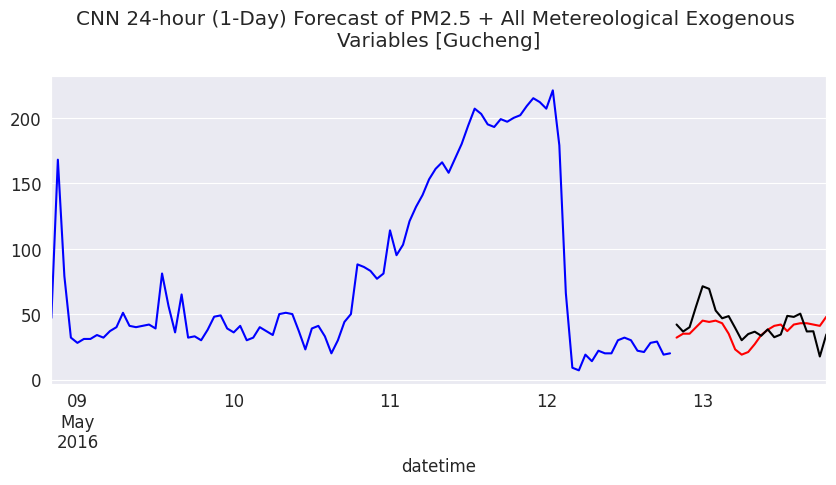

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_guch_exo[-steps*4:], index=Xtrain_guch_exo.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 24-hour (1-Day) Forecast of PM2.5 + All Metereological Exogenous \nVariables [Gucheng]\n')
plt.legend

In [ ]:
results_cnn_1_day_forecast_all_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_day')
results_cnn_1_day_forecast_all_met_24lags

cnn_one_day
MAE             10.423
MSE            157.933
RMSE            12.567
R-Squared       -1.627
MAPE             0.299

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest_guch_exo[:steps]
one_weeky =  deep_ytest_guch_exo[:steps]
predictions = cnn_model_guch_exo.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 7ms/step


array([[42.03264 ],
       [36.654606],
       [39.97032 ],
       [55.937626],
       [71.259995]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_guch_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_guch_exo.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    42.032639
2016-05-12 21:00:00    36.654606
2016-05-12 22:00:00    39.970322
2016-05-12 23:00:00    55.937626
2016-05-13 00:00:00    71.259995
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

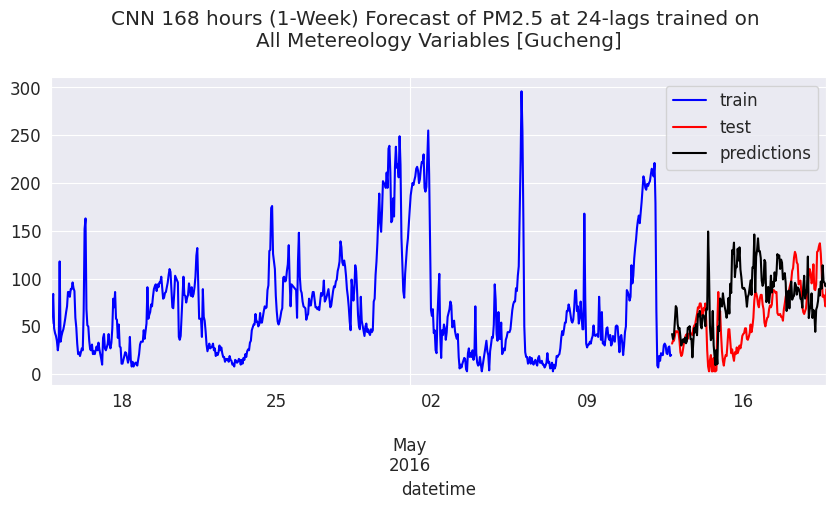

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_guch_exo[-steps*4:], index=Xtrain_guch_exo.index[-steps*4:], 
          name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 168 hours (1-Week) Forecast of PM2.5 at 24-lags trained on \nAll Metereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_cnn_1_week_forecast_all_met_24lags = evaluate_model_performance(
    y_true, preds_CNN, label='cnn_one_week')

results_cnn_1_week_forecast_all_met_24lags

cnn_one_week
MAE              33.033
MSE            1828.743
RMSE             42.764
R-Squared        -0.852
MAPE              1.393

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest_guch_exo[:steps]
one_monthy =  deep_ytest_guch_exo[:steps]
predictions = cnn_model_guch_exo.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 3ms/step


array([[42.03264 ],
       [36.654606],
       [39.97032 ],
       [55.937626],
       [71.259995]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_guch_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_guch_exo.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    42.032639
2016-05-12 21:00:00    36.654606
2016-05-12 22:00:00    39.970322
2016-05-12 23:00:00    55.937626
2016-05-13 00:00:00    71.259995
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

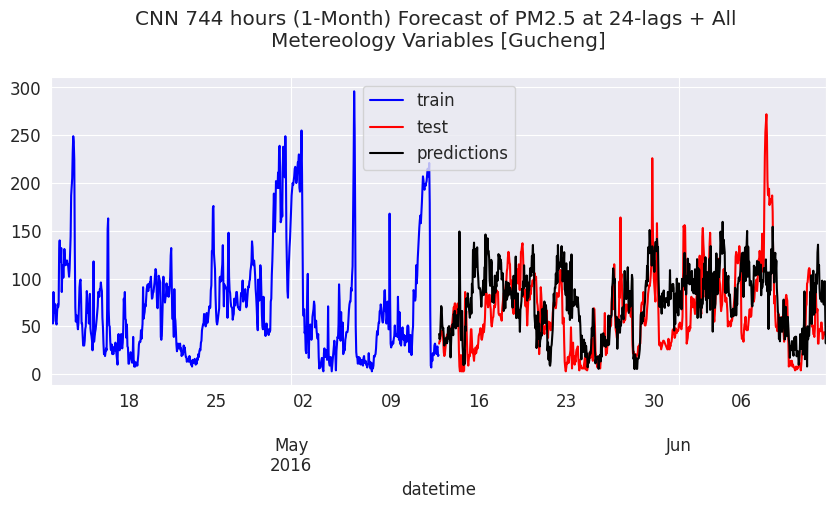

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_guch_exo[-steps:], index=Xtrain_guch_exo.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 744 hours (1-Month) Forecast of PM2.5 at 24-lags + All \nMetereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_cnn_1_month_forecast_all_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_month')
results_cnn_1_month_forecast_all_met_24lags

cnn_one_month
MAE               31.770
MSE             1710.658
RMSE              41.360
R-Squared         -0.036
MAPE               1.037

##### Combined Results

In [ ]:
cnn_results_pm25_with_all_met_vars = pd.concat([
    results_cnn_1_day_forecast_all_met_24lags, 
    results_cnn_1_week_forecast_all_met_24lags,
    results_cnn_1_month_forecast_all_met_24lags
    ], axis='columns')

cnn_results_pm25_with_all_met_vars

cnn_one_day  cnn_one_week  cnn_one_month
MAE             10.423        33.033         31.770
MSE            157.933      1828.743       1710.658
RMSE            12.567        42.764         41.360
R-Squared       -1.627        -0.852         -0.036
MAPE             0.299         1.393          1.037

<Axes: title={'center': 'Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Gucheng]\n'}>

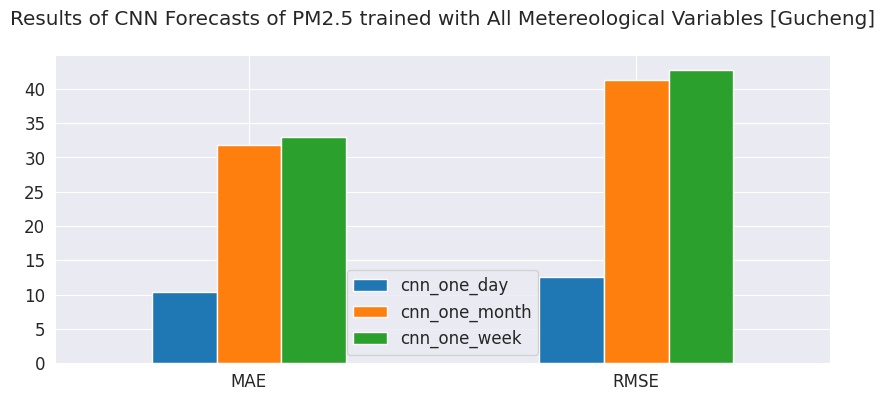

In [ ]:
cnn_results_pm25_with_all_met_vars.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)

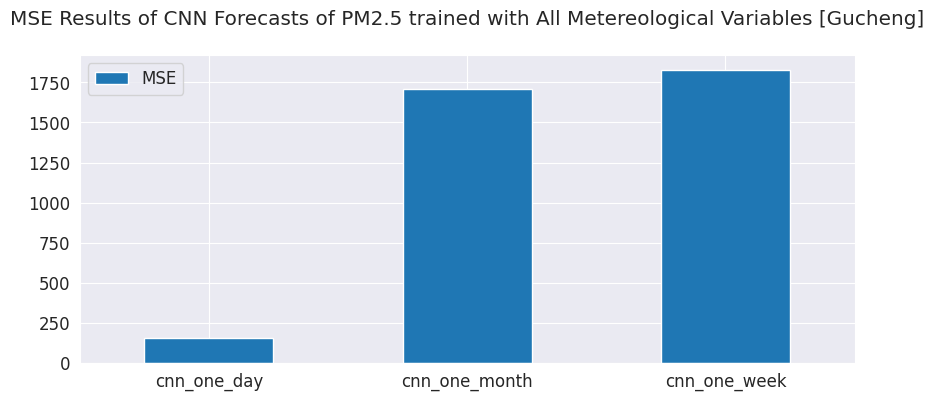

In [ ]:
cnn_results_pm25_with_all_met_vars.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

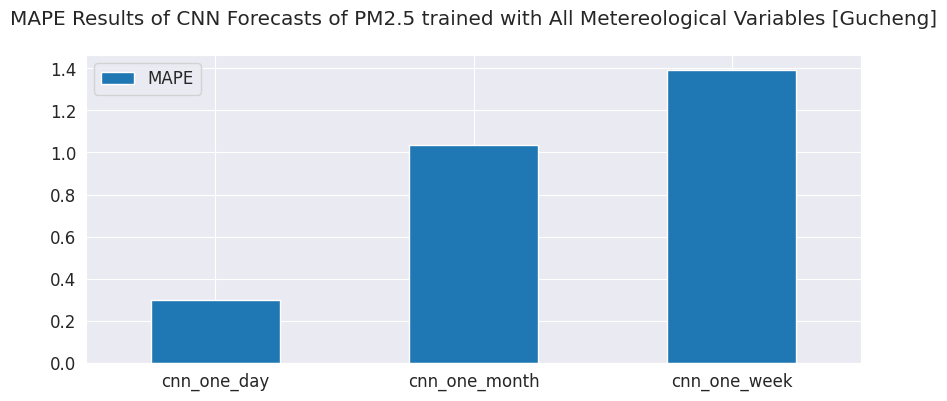

In [ ]:
cnn_results_pm25_with_all_met_vars.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

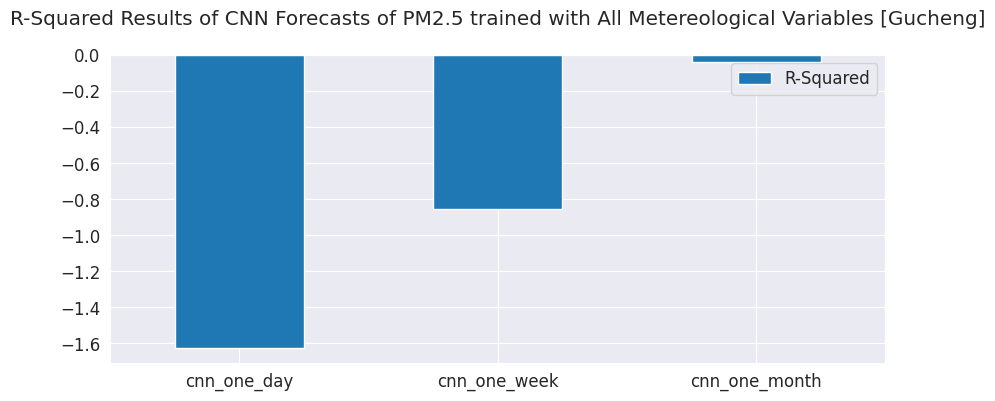

In [ ]:
cnn_results_pm25_with_all_met_vars.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of CNN Forecasts of PM2.5 trained with All Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
cnn_results_pm25_with_all_met_vars.to_csv(f'{RESULTS_PATH}/cnn_results_pm25_with_all_met_vars_24lags_Gucheng.csv')


## CNN + [Selected] Exogenous Metereological Variables

- 1 day (24 hrs) lag
- CNN
- Gucheng station data

In [ ]:
TEST_SIZE = int((20 / 100) * len(y_pm25_guch)) # 20%
N_LAGS = 24
N_FEATURES = 4

#### Data Preparation and preprocessing

In [ ]:
features_X_guch.corrwith(y_pm25_guch).sort_values()

WSPM   -0.251702
TEMP   -0.145860
wd     -0.025076
RAIN   -0.020184
PRES    0.022596
DEWP    0.097060
dtype: float64

In [ ]:
# merged scaled data and target
data_pm25_exo_sel = pd.concat([scaled_features_X_guch[['WSPM', 'wd', 'TEMP', 'DEWP']], y_pm25_guch], axis='columns')
data_pm25_exo_sel.head()

WSPM        wd      TEMP      DEWP  PM2.5
datetime                                                          
2013-03-01 00:00:00  2.655283  1.042002 -1.217891 -1.537381    6.0
2013-03-01 01:00:00  2.307770  1.042002 -1.253305 -1.566388    6.0
2013-03-01 02:00:00  2.829039  0.839651 -1.288720 -1.624401    5.0
2013-03-01 03:00:00  1.265234  0.637301 -1.315281 -1.725925    6.0
2013-03-01 04:00:00  1.960258  0.839651 -1.341842 -1.740428    5.0

In [ ]:
# Data Segmentation (80% training : 20% testing)

Xtrain_guch_exo_sel, ytrain_guch_exo_sel, Xtest_guch_exo_sel, ytest_guch_exo_sel = \
    split_train_test_series_multivariate_series(
        data_pm25_exo_sel, test_size=TEST_SIZE)

In [ ]:
Xtrain_guch_exo_sel.head(2)

WSPM        wd      TEMP      DEWP
datetime                                                   
2013-03-01 00:00:00  2.655283  1.042002 -1.217891 -1.537381
2013-03-01 01:00:00  2.307770  1.042002 -1.253305 -1.566388

In [ ]:
ytrain_guch_exo_sel.head(2)

datetime
2013-03-01 00:00:00    6.0
2013-03-01 01:00:00    6.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Shape of X: {scaled_features_X_guch.shape}')
print(f'Shape of Xtrain: {Xtrain_guch_exo_sel.shape}')
print(f'Shape of Xtest: {Xtest_guch_exo_sel.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28052, 4)
Shape of Xtest: (7012, 4)


In [ ]:
deep_Xtrain_guch_exo_sel, deep_ytrain_guch_exo_sel = deep_prepare_X_y_for_CNN(
    X=Xtrain_guch_exo_sel, y=ytrain_guch_exo_sel, n_lags=N_LAGS, kind='multi_input')


deep_Xtest_guch_exo_sel, deep_ytest_guch_exo_sel = deep_prepare_X_y_for_CNN(
    X=Xtest_guch_exo_sel, y=ytest_guch_exo_sel, n_lags=N_LAGS, kind='multi_input')

In [ ]:
print(f'Shape of Xtrain: {Xtrain_guch_exo_sel.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_guch_exo_sel.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_guch_exo_sel.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_guch_exo_sel.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_guch_exo_sel.shape}')

Shape of Xtrain: (28052, 4)
Shape of Deep-Xtrain: (28029, 24, 4)
Shape of Deep-Xtest: (6989, 24, 4)
Shape of Deep-ytrain: (28029,)
Shape of Deep-ytest: (6989,)


In [ ]:
for i in range(2):
    print(deep_Xtrain_guch_exo_sel[i], deep_ytrain_guch_exo_sel[i])

[[ 2.65528256  1.04200157 -1.21789063 -1.53738112]
 [ 2.30777032  1.04200157 -1.25330518 -1.56638783]
 [ 2.82903868  0.83965144 -1.28871972 -1.62440125]
 [ 1.2652336   0.63730132 -1.31528063 -1.72592474]
 [ 1.96025808  0.83965144 -1.34184154 -1.7404281 ]
 [-0.12481536 -0.98149966 -1.38610972 -1.77668649]
 [-0.12481536 -1.18384979 -1.45693881 -1.66791132]
 [-0.21169342 -1.18384979 -1.30642699 -1.675163  ]
 [ 1.43898972 -1.18384979 -1.21789063 -1.66065964]
 [ 1.2652336  -1.38619991 -1.12935427 -1.68241468]
 [ 1.43898972 -1.18384979 -1.05852518 -1.73317642]
 [ 1.61274584 -1.18384979 -0.93457427 -1.70416971]
 [ 1.61274584 -1.18384979 -0.86374518 -1.66065964]
 [ 1.17835554 -1.38619991 -0.75750154 -1.64615629]
 [ 0.65708718 -1.38619991 -0.73979427 -1.63890461]
 [ 1.17835554 -1.18384979 -0.66896518 -1.58814286]
 [ 0.396453   -1.18384979 -0.70437973 -1.55188448]
 [-0.29857148  0.83965144 -0.77520882 -1.5446328 ]
 [ 0.22269688 -0.98149966 -0.89915972 -1.58089119]
 [ 0.30957494 -0.98149966 -0.98

#### CNN Model Building

In [ ]:
N_EPOCHS = 150
BATCH_SIZE = 20

N_LAGS = 24
N_FEATURES = 4 # no of input variables

In [ ]:
# del cnn_model_guch_exo_sel

In [ ]:
cnn_model_guch_exo_sel = Sequential()

# input layer and hidden layer1
cnn_model_guch_exo_sel.add(Conv1D(filters=256, kernel_size=2, activation='relu', 
                              input_shape=(N_LAGS, N_FEATURES)))
cnn_model_guch_exo_sel.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_guch_exo_sel.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_guch_exo_sel.add(MaxPooling1D(pool_size=2))

cnn_model_guch_exo_sel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_guch_exo_sel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_guch_exo_sel.add(MaxPooling1D(pool_size=2))

cnn_model_guch_exo_sel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_guch_exo_sel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_guch_exo_sel.add(MaxPooling1D(pool_size=2))

cnn_model_guch_exo_sel.add(Flatten())
cnn_model_guch_exo_sel.add(Dense(units=16, activation='relu'))

# Output layer
cnn_model_guch_exo_sel.add(Dense(units=1))

# optimizer (adam)
adam_optimizer = Adam(learning_rate=0.001)

cnn_model_guch_exo_sel.compile(
    optimizer=adam_optimizer, 
    loss='mse', 
    metrics=[
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        MeanSquaredError(),
        RootMeanSquaredError()
    ]
  )


In [ ]:
cnn_model_guch_exo_sel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 23, 256)           2304      
                                                                 
 conv1d_15 (Conv1D)          (None, 22, 128)           65664     
                                                                 
 conv1d_16 (Conv1D)          (None, 21, 128)           32896     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 10, 128)          0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, 9, 64)             16448     
                                                                 
 conv1d_18 (Conv1D)          (None, 8, 64)             8256      
                                                      

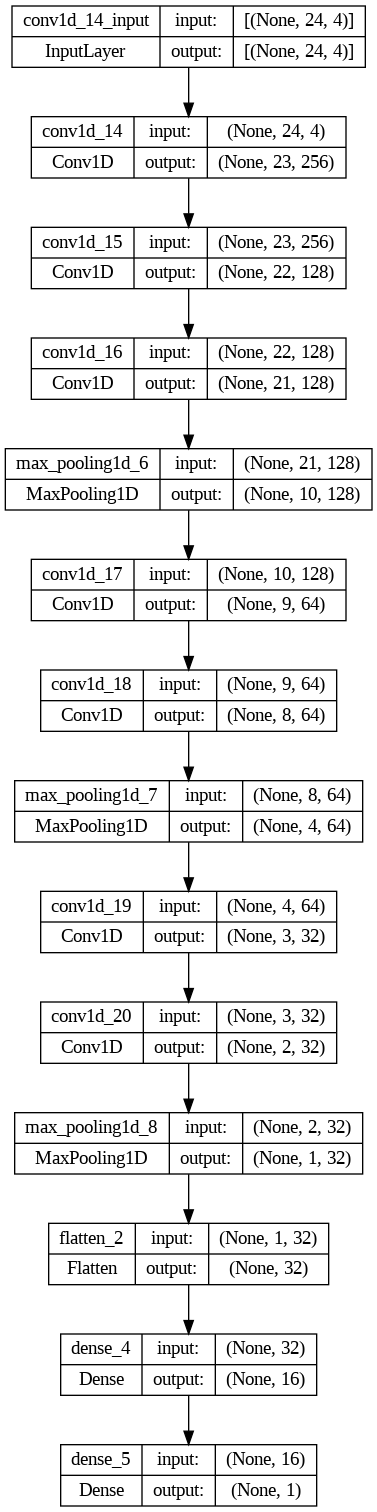

In [ ]:
# Model Architecture
plot_model(cnn_model_guch_exo_sel, to_file='cnn_model_guch_with_selected_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

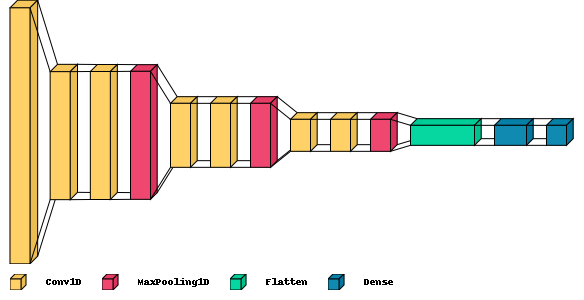

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    cnn_model_guch_exo_sel, legend=True, 
    scale_xy=1,
    scale_z=2,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_cnn_pm25_with_selected_met_vars_Gucheng_architecture.png')

In [ ]:
# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# Fitting the model
history = cnn_model_guch_exo_sel.fit(
    deep_Xtrain_guch_exo_sel, deep_ytrain_guch_exo_sel, 
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS, 
    callbacks=[early_stopper],
    verbose=1)

Epoch 1/150
1402/1402 [==============================] - 8s 5ms/step - loss: 5006.5322 - mean_absolute_error: 50.2826 - mean_absolute_percentage_error: 162.3359 - mean_squared_error: 5006.5322 - root_mean_squared_error: 70.7569
Epoch 2/150
1402/1402 [==============================] - 8s 5ms/step - loss: 3942.7190 - mean_absolute_error: 43.7059 - mean_absolute_percentage_error: 119.7515 - mean_squared_error: 3942.7190 - root_mean_squared_error: 62.7911
Epoch 3/150
1402/1402 [==============================] - 7s 5ms/step - loss: 3583.3311 - mean_absolute_error: 41.2107 - mean_absolute_percentage_error: 107.2024 - mean_squared_error: 3583.3311 - root_mean_squared_error: 59.8609
Epoch 4/150
1402/1402 [==============================] - 8s 6ms/step - loss: 3260.2412 - mean_absolute_error: 39.0452 - mean_absolute_percentage_error: 99.5837 - mean_squared_error: 3260.2412 - root_mean_squared_error: 57.0985
Epoch 5/150
1402/1402 [==============================] - 7s 5ms/step - loss: 2999.6899 - 

In [ ]:
# history.history
best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["mean_squared_error"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')


TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 104
MAE: 8.508920669555664
MSE: 131.8131103515625
RMSE: 11.480989456176758
MAPE: 24.62374496459961


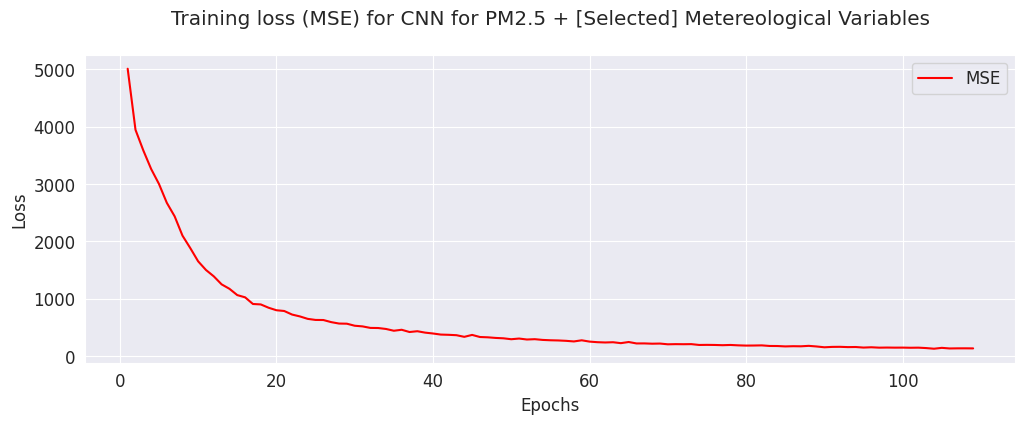

In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for CNN for PM2.5 + [Selected] Metereological Variables\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 21.722222222222214, 'Epochs')

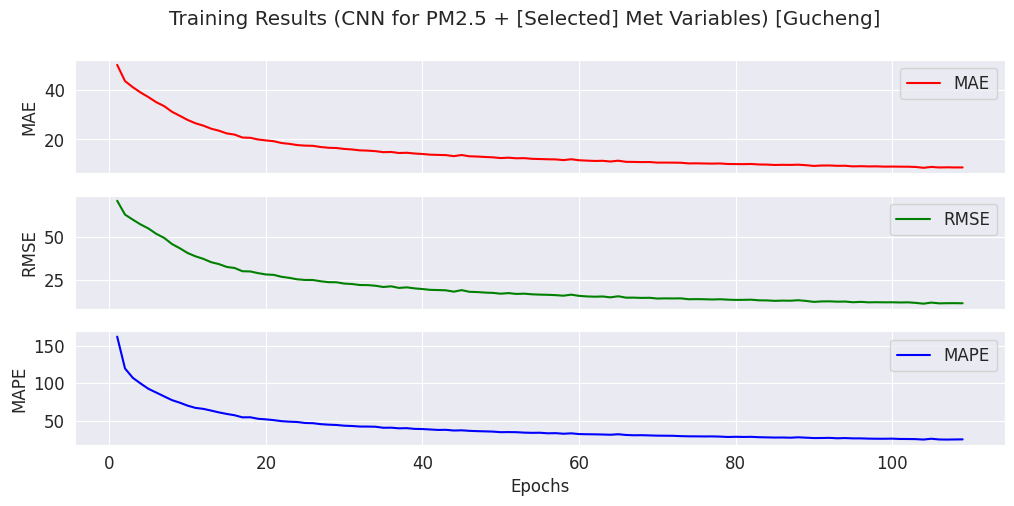

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (CNN for PM2.5 + [Selected] Met Variables) [Gucheng]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


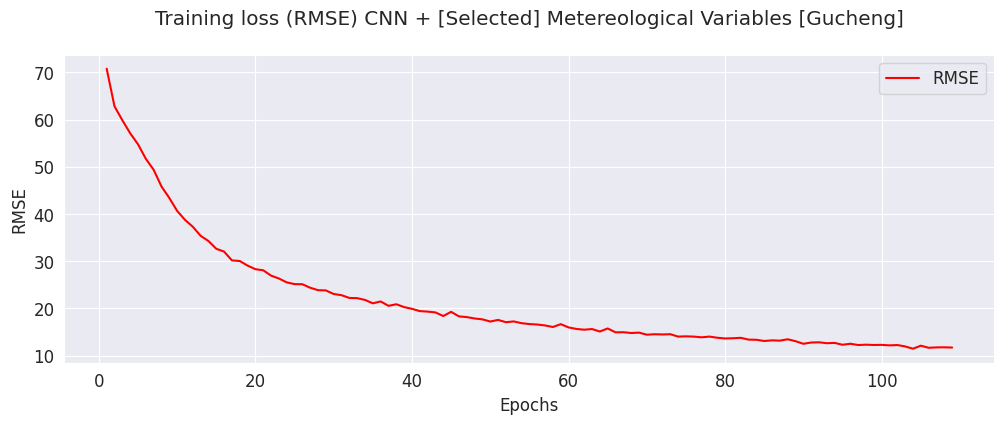

In [ ]:
# Training RMSE
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) CNN + [Selected] Metereological Variables [Gucheng]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# saving the trained model
cnn_model_guch_exo_sel.save(f'{MODEL_PATH}/cnn_model_pm25_with_selected_met_vars_Gucheng.h5')

#### Making Forecasts

In [ ]:
# Loading saved trained model
cnn_model_guch_exo_sel = load_model(f'{MODEL_PATH}/cnn_model_pm25_with_selected_met_vars_Gucheng.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- CNN

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest_guch_exo_sel[:steps]
one_dayy =  deep_ytest_guch_exo_sel[:steps]
predictions = cnn_model_guch_exo_sel.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 0s 285ms/step


array([[61.77986 ],
       [66.08493 ],
       [71.029594],
       [59.991966],
       [81.41273 ]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_guch_exo_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_guch_exo_sel.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    61.779861
2016-05-12 21:00:00    66.084930
2016-05-12 22:00:00    71.029594
2016-05-12 23:00:00    59.991966
2016-05-13 00:00:00    81.412727
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

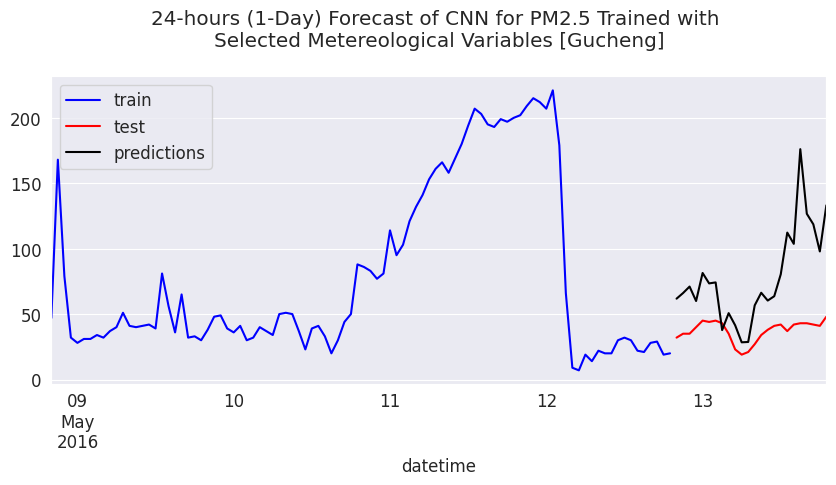

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_guch_exo_sel[-steps*4:], index=Xtrain_guch_exo_sel.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('24-hours (1-Day) Forecast of CNN for PM2.5 Trained with \nSelected Metereological Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_cnn_1_day_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_day_sel_met')
results_cnn_1_day_forecast_sel_met_24lags

cnn_one_day_sel_met
MAE                     41.089
MSE                   2595.678
RMSE                    50.948
R-Squared              -42.173
MAPE                     1.056

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest_guch_exo_sel[:steps]
one_weeky =  deep_ytest_guch_exo_sel[:steps]
predictions = cnn_model_guch_exo_sel.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 10ms/step


array([[61.77986 ],
       [66.08493 ],
       [71.029594],
       [59.991966],
       [81.41273 ]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_guch_exo_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_guch_exo_sel.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    61.779861
2016-05-12 21:00:00    66.084930
2016-05-12 22:00:00    71.029594
2016-05-12 23:00:00    59.991966
2016-05-13 00:00:00    81.412727
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

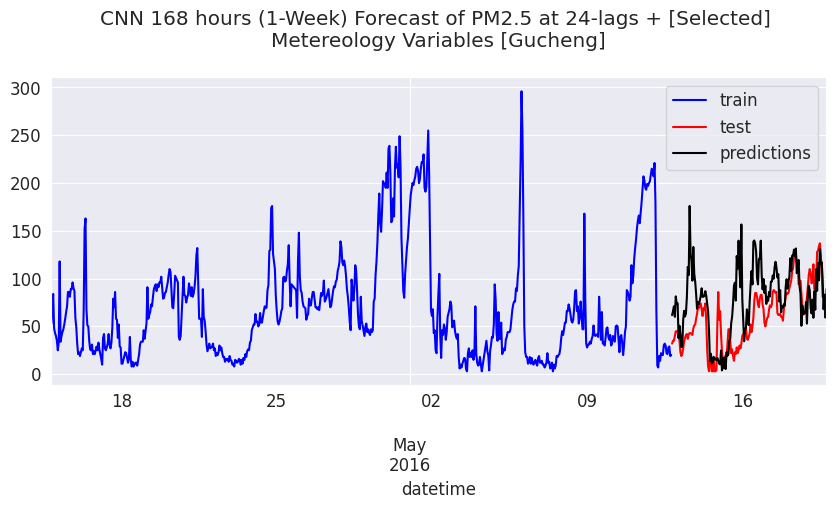

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_guch_exo_sel[-steps*4:], index=Xtrain_guch_exo_sel.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 168 hours (1-Week) Forecast of PM2.5 at 24-lags + [Selected] \nMetereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_cnn_1_week_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_week_sel')
results_cnn_1_week_forecast_sel_met_24lags

cnn_one_week_sel
MAE                  27.648
MSE                1394.918
RMSE                 37.349
R-Squared            -0.413
MAPE                  0.856

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest_guch_exo_sel[:steps]
one_monthy =  deep_ytest_guch_exo_sel[:steps]
predictions = cnn_model_guch_exo_sel.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 2ms/step


array([[61.77986 ],
       [66.08493 ],
       [71.029594],
       [59.991966],
       [81.41273 ]], dtype=float32)

In [ ]:
preds_CNN = pd.Series(predictions.flatten(), index=Xtest_guch_exo_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_guch_exo_sel.index[:steps], name='PM2.5')
preds_CNN.head()

datetime
2016-05-12 20:00:00    61.779861
2016-05-12 21:00:00    66.084930
2016-05-12 22:00:00    71.029594
2016-05-12 23:00:00    59.991966
2016-05-13 00:00:00    81.412727
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

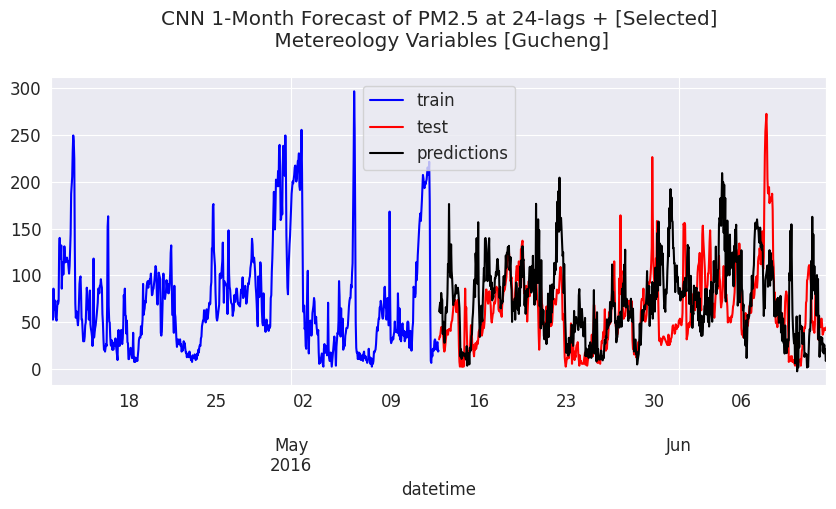

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_guch_exo_sel[-steps:], index=Xtrain_guch_exo_sel.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds_CNN.plot(label='predictions', color='black')
plt.title('CNN 1-Month Forecast of PM2.5 at 24-lags + [Selected]\n Metereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_cnn_1_month_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds_CNN, label='cnn_one_month_sel_met')
results_cnn_1_month_forecast_sel_met_24lags

cnn_one_month_sel_met
MAE                       34.881
MSE                     2230.837
RMSE                      47.232
R-Squared                 -0.351
MAPE                       0.995

##### Combined Results

In [ ]:
cnn_results_pm25_with_sel_met_vars = pd.concat([
    results_cnn_1_day_forecast_sel_met_24lags, 
    results_cnn_1_week_forecast_sel_met_24lags,
    results_cnn_1_month_forecast_sel_met_24lags
    ], axis='columns')

cnn_results_pm25_with_sel_met_vars

cnn_one_day_sel_met  cnn_one_week_sel  cnn_one_month_sel_met
MAE                     41.089            27.648                 34.881
MSE                   2595.678          1394.918               2230.837
RMSE                    50.948            37.349                 47.232
R-Squared              -42.173            -0.413                 -0.351
MAPE                     1.056             0.856                  0.995

<Axes: title={'center': 'Results of CNN Forecasts of PM2.5 trained with [Selected] Metereological Variables [Gucheng]\n'}>

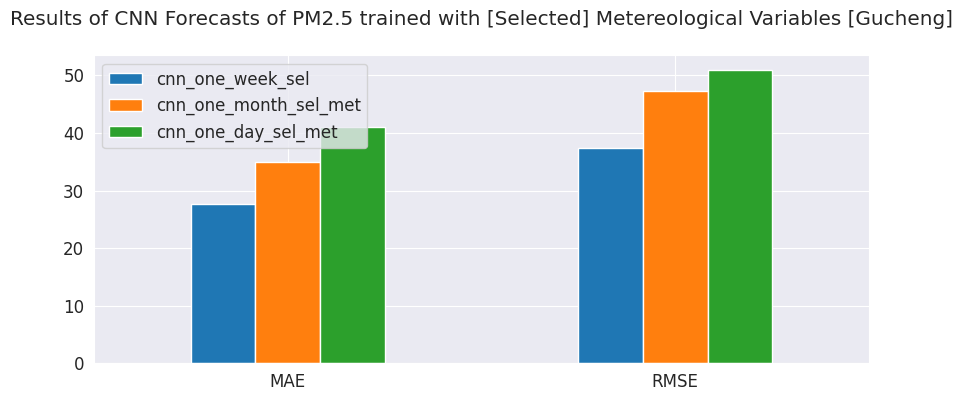

In [ ]:
cnn_results_pm25_with_sel_met_vars.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of CNN Forecasts of PM2.5 trained with [Selected] Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)

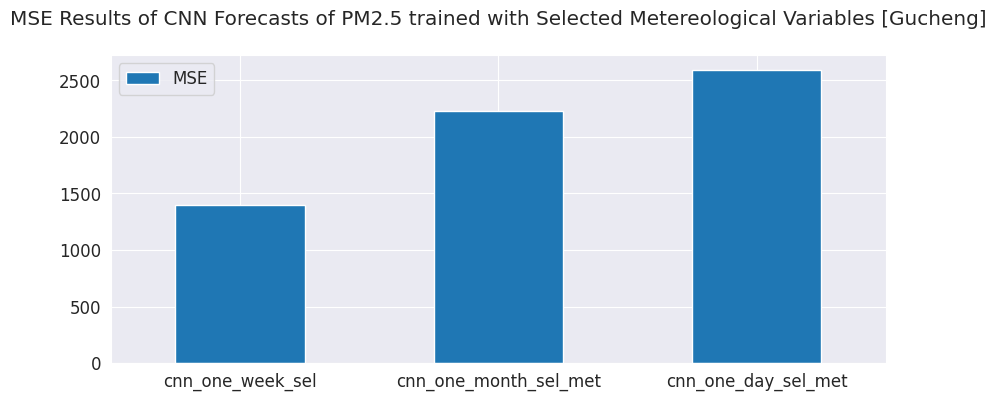

In [ ]:
cnn_results_pm25_with_sel_met_vars.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of CNN Forecasts of PM2.5 trained with Selected Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

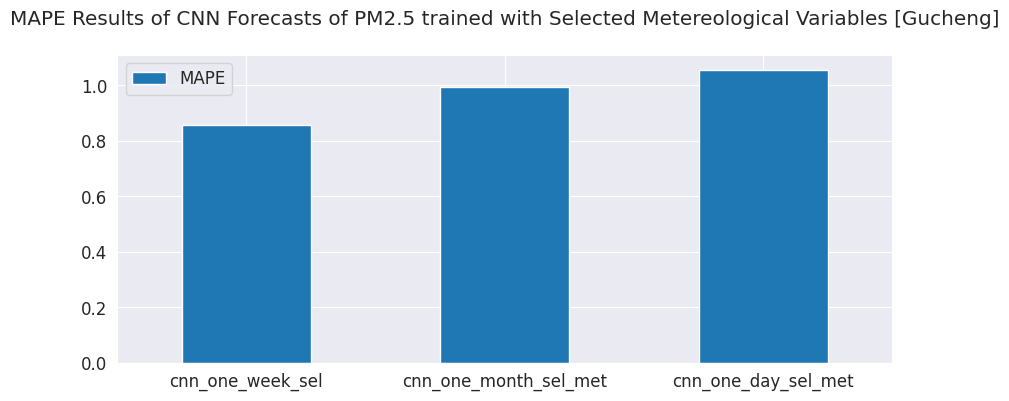

In [ ]:
cnn_results_pm25_with_sel_met_vars.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of CNN Forecasts of PM2.5 trained with Selected Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

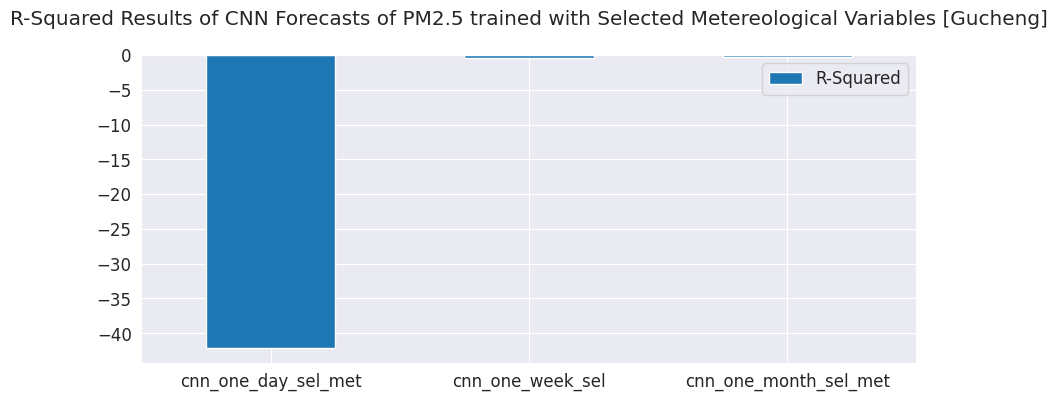

In [ ]:
cnn_results_pm25_with_sel_met_vars.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of CNN Forecasts of PM2.5 trained with Selected Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
cnn_results_pm25_with_sel_met_vars.to_csv(f'{RESULTS_PATH}/cnn_results_pm25_with_selected_met_vars_24lags_Gucheng.csv')


## Backtesting Cross-Validation (with refit) for CNN

- Timeseries Optimization and Validation with Backtesting
- lags: 24 hrs
- steps: 24 * 7
- n_backtesting: 5 (Backtesting_sample_size: step * 5 = (24 * 7) * 5 samples)


In [ ]:
# train:valid:test --- 80%:20%

TEST_SIZE = int(0.20 * len(y_pm25_guch)) # 20 %

N_FEATURES = 1
N_LAGS = 24
STEPS = 24 * 7   # 168 hrs (1 week)

# 5 Fold cross validation (Walk-forward forecast)
N_FOLDS = 5
N_BACKTESTING = STEPS * N_FOLDS


In [ ]:
N_EPOCHS = 150
BATCH_SIZE = 20

cnn_model_guch = Sequential()

# input layer and hidden layer1
cnn_model_guch.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(N_LAGS, 1)))
cnn_model_guch.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_guch.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model_guch.add(MaxPooling1D(pool_size=2))

cnn_model_guch.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_guch.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model_guch.add(MaxPooling1D(pool_size=2))

cnn_model_guch.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_guch.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model_guch.add(MaxPooling1D(pool_size=2))

cnn_model_guch.add(Flatten())
cnn_model_guch.add(Dense(units=16, activation='relu'))

# Output layer
cnn_model_guch.add(Dense(units=1))

# optimizer (adam)
adam_optimizer = Adam(learning_rate=0.001)

cnn_model_guch.compile(
    optimizer=adam_optimizer, 
    loss='mse', 
    metrics=[
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        MeanSquaredError(),
        RootMeanSquaredError()
    ]
  )


# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05, # p-value
    patience=5,
    restore_best_weights=True,
)

# Fitting the model
history = cnn_model_guch.fit(
    deep_Xtrain_guch, deep_ytrain_guch, 
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS, 
    callbacks=[early_stopper],
    verbose=1)

##### Single-series [target only] data prep

In [ ]:
bt_pm25_data = series_to_supervised_dataset_single(series_data=y_pm25_guch, n_lags=N_LAGS)

current_train_size = len(bt_pm25_data) - N_BACKTESTING
current_test_size = N_BACKTESTING

for k in range(1, N_FOLDS + 1):
    if (current_train_size + STEPS) > len(bt_pm25_data):
        break

    Xtrain, ytrain, Xtest, ytest = split_train_test_series_multivariate_series(
        bt_pm25_data, test_size=current_test_size)
    

    current_test_size = current_train_size - STEPS

## LSTM


## LSTM (without Exogenous Metereological Variables)

In [ ]:
# train:valid:test --- 80%:20%

TEST_SIZE = int(0.20 * len(y_pm25_guch)) # 20 %

N_FEATURES = 1
N_LAGS = 24
STEPS = 24 * 7   # 168 hrs (1 week)

BATCH_SIZE = 20
N_EPOCHS = 150

#### Data Preparation for LSTM

##### Data Segmentation 

- Train: 80%
- Test: 20%

##### Single-series [target only] data prep

In [ ]:
lstm_pm25_data = series_to_supervised_dataset_single(series_data=y_pm25_guch, n_lags=N_LAGS)

In [ ]:
lstm_pm25_data.head()

PM25t-24  PM25t-23  PM25t-22  PM25t-21  PM25t-20  \
datetime                                                                
2013-03-02 00:00:00       6.0       6.0       5.0       6.0       5.0   
2013-03-02 01:00:00       6.0       5.0       6.0       5.0       4.0   
2013-03-02 02:00:00       5.0       6.0       5.0       4.0       3.0   
2013-03-02 03:00:00       6.0       5.0       4.0       3.0       5.0   
2013-03-02 04:00:00       5.0       4.0       3.0       5.0       5.0   

                     PM25t-19  PM25t-18  PM25t-17  PM25t-16  PM25t-15  ...  \
datetime                                                               ...   
2013-03-02 00:00:00       4.0       3.0       5.0       5.0       4.0  ...   
2013-03-02 01:00:00       3.0       5.0       5.0       4.0       7.0  ...   
2013-03-02 02:00:00       5.0       5.0       4.0       7.0       3.0  ...   
2013-03-02 03:00:00       5.0       4.0       7.0       3.0       9.0  ...   
2013-03-02 04:00:00       4.0       7.0       3.0       9.0      10.0  ...   

                     PM25t-9  PM25t-8  PM25t-7  PM25t-6  PM25t-5  PM25t-4  \
datetime                                                                    
2013-03-02 00:00:00     13.0     11.0     10.0     11.0     11.0     13.0   
2013-03-02 01:00:00     11.0     10.0     11.0     11.0     13.0     15.0   
2013-03-02 02:00:00     10.0     11.0     11.0     13.0     15.0     16.0   
2013-03-02 03:00:00     11.0     11.0     13.0     15.0     16.0     16.0   
2013-03-02 04:00:00     11.0     13.0     15.0     16.0     16.0     14.0   

                     PM25t-3  PM25t-2  PM25t-1  PM2.5  
datetime                                               
2013-03-02 00:00:00     15.0     16.0     16.0   14.0  
2013-03-02 01:00:00     16.0     16.0     14.0   18.0  
2013-03-02 02:00:00     16.0     14.0     18.0   19.0  
2013-03-02 03:00:00     14.0     18.0     19.0   15.0  
2013-03-02 04:00:00     18.0     19.0     15.0   13.0  

[5 rows x 25 columns]

In [ ]:
# Single target
train_set = lstm_pm25_data.iloc[:-TEST_SIZE]
test_set = lstm_pm25_data.iloc[-TEST_SIZE:]

Xtrain, ytrain = train_set.iloc[:, :-1], train_set.iloc[:, -1]
Xtest, ytest = test_set.iloc[:, :-1], test_set.iloc[:, -1]

In [ ]:
print(f'Shape of X: {lstm_pm25_data.shape}')
print(f'Shape of X-train: {Xtrain.shape}')
print(f'Shape of X-test: {Xtest.shape}')

Shape of X: (35040, 25)
Shape of X-train: (28028, 24)
Shape of X-test: (7012, 24)


In [ ]:
# Converting Series into Supervised learning format
deep_Xtrain, deep_ytrain = deep_prepare_X_y_for_CNN(
    X=Xtrain, y=ytrain, n_lags=N_LAGS, kind='single')

deep_Xtest, deep_ytest = deep_prepare_X_y_for_CNN(
    X=Xtest, y=ytest, n_lags=N_LAGS, kind='single')

In [ ]:
#  # MULTI-STEP FORECAST CASE
# deep_Xtrain, deep_ytrain = deep_prepare_X_y_for_CNN_multi_step(
#     X=Xtrain.values, y=ytrain.values, n_lags=N_LAGS, future_steps=24 * 7, start=0, end=None)
 
# deep_Xtest, deep_ytest = deep_prepare_X_y_for_CNN_multi_step(
#     X=Xtest.values, y=ytest.values, n_lags=N_LAGS, future_steps=24 * 7, start=0, end=None)

# print(deep_Xtrain[0][0,:],'\n\n\n', deep_ytrain.shape)

In [ ]:
print(f'Shape of X-train: {deep_Xtrain.shape}')
print(f'Shape of X-test: {deep_Xtest.shape}')

Shape of X-train: (28028, 24, 1)
Shape of X-test: (7012, 24, 1)


#### LSTM Model Buiding 

##### LSTM Configuration Variant 1 (Bi-directional LSTM Variant) 

In [ ]:
# del lstm_model

In [ ]:
lstm_model = Sequential([
    # Bi-directional input layer 1
    Bidirectional(LSTM(200, return_sequences=True), 
            input_shape=(N_LAGS, N_FEATURES)),
    # output of layer 1
    Dense(20, activation='tanh'),

    # Bi-directional input layer 2
    Bidirectional(LSTM(150)),
    # output of layer 1 and output of layer 2
    Dense(20, activation='tanh'), # layer 1 hidden-state
    Dense(20, activation='tanh'), # layer 2 hidden-state
    Dropout(0.25),

    # Output layer
    Dense(units=1),
 ])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[
      MeanAbsoluteError(),
      RootMeanSquaredError(),
      MeanAbsolutePercentageError()
    ])

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 400)          323200    
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 24, 20)            8020      
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 20)                6020      
                                                                 
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)               

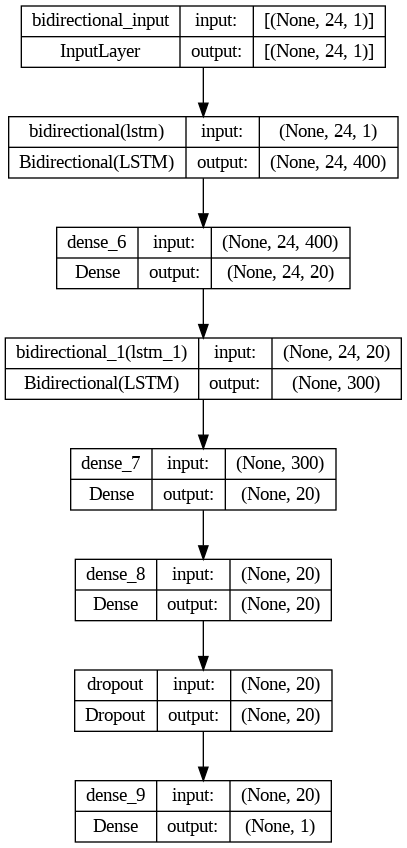

In [ ]:
# Model Architecture
plot_model(lstm_model, to_file='lstm_model_guch_with_all_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

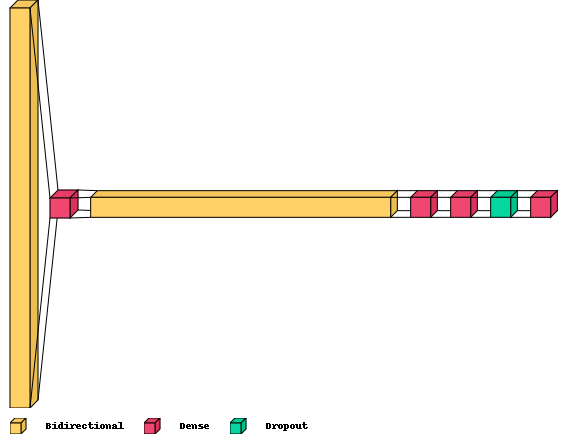

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    lstm_model, legend=True, 
    scale_xy=1,
    scale_z=1,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_lstm_pm25_with_all_met_vars_Gucheng_architecture.png')

In [ ]:
# Training the LSTM model

# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# For learning performance improvement
lr_reducer = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)


# Fitting the model & applying callbacks
history = lstm_model.fit(
    deep_Xtrain, deep_ytrain, # validation_data=(deep_Xval, deep_yval), 
    batch_size=BATCH_SIZE, epochs = 150, verbose=1, callbacks=[lr_reducer, early_stopper])


Epoch 1/150
1402/1402 [==============================] - 23s 12ms/step - loss: 11070.7451 - mean_absolute_error: 69.9965 - root_mean_squared_error: 105.2176 - mean_absolute_percentage_error: 84.3015 - lr: 0.0010
Epoch 2/150
1402/1402 [==============================] - 17s 12ms/step - loss: 8554.7393 - mean_absolute_error: 59.8524 - root_mean_squared_error: 92.4918 - mean_absolute_percentage_error: 121.9562 - lr: 9.0000e-04
Epoch 3/150
1402/1402 [==============================] - 17s 12ms/step - loss: 7397.7827 - mean_absolute_error: 57.5011 - root_mean_squared_error: 86.0104 - mean_absolute_percentage_error: 164.7603 - lr: 8.1000e-04
Epoch 4/150
1402/1402 [==============================] - 17s 12ms/step - loss: 6918.9302 - mean_absolute_error: 57.7803 - root_mean_squared_error: 83.1801 - mean_absolute_percentage_error: 197.3825 - lr: 7.2900e-04
Epoch 5/150
1402/1402 [==============================] - 17s 12ms/step - loss: 6758.3960 - mean_absolute_error: 58.8611 - root_mean_squared_err

In [ ]:
# history.history
best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["loss"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')

TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 52
MAE: 20.839950561523438
MSE: 2121.851806640625
RMSE: 46.063560485839844
MAPE: 29.310272216796875


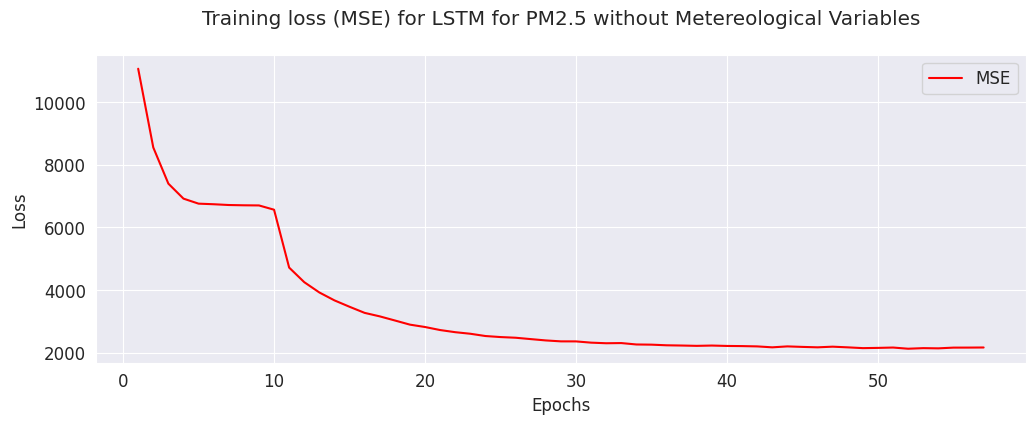

In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for LSTM for PM2.5 without Metereological Variables\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 21.722222222222214, 'Epochs')

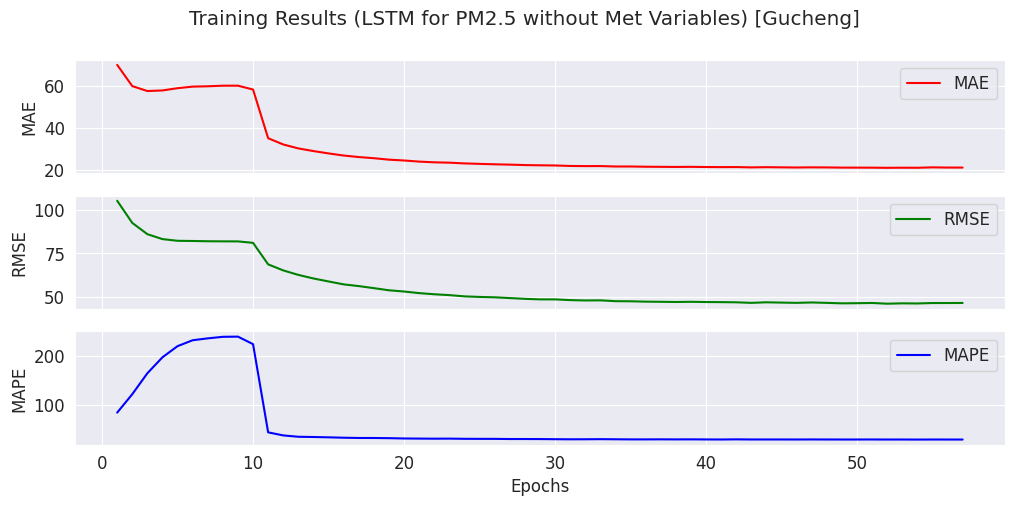

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (LSTM for PM2.5 without Met Variables) [Gucheng]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


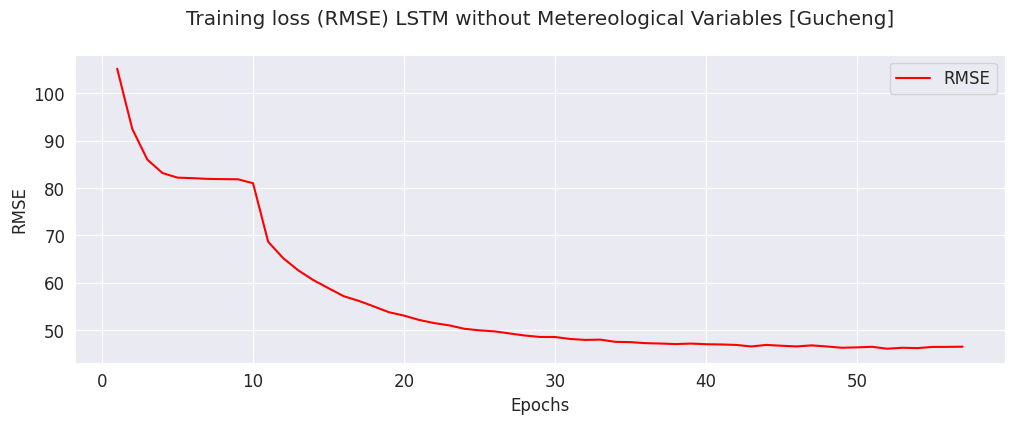

In [ ]:
# Training RMSE
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) LSTM without Metereological Variables [Gucheng]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# Saving the trained model
lstm_model.save(f'{MODEL_PATH}/lstm_model1_pm25_without_met_vars_Gucheng.h5')

---

#### Making Forecasts

In [ ]:
# loading the trained LSTM model
lstm_model = load_model(f'{MODEL_PATH}/lstm_model1_pm25_without_met_vars_Gucheng.h5')

##### 24 hours (1-Day) Forecast

- 24 lags 
- 24 steps
- LSTM (Bi-directional)
- No metereological data

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest[:steps]
one_dayy =  deep_ytest[:steps]
predictions = lstm_model.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 2s 2s/step


array([[22.381493],
       [30.257046],
       [42.79104 ],
       [82.94071 ],
       [43.532654]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    22.381493
2016-05-12 21:00:00    30.257046
2016-05-12 22:00:00    42.791039
2016-05-12 23:00:00    82.940712
2016-05-13 00:00:00    43.532654
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    28.0
2016-05-12 21:00:00    38.0
2016-05-12 22:00:00    70.0
2016-05-12 23:00:00    48.0
2016-05-13 00:00:00    35.0
Freq: H, Name: PM2.5, dtype: float64

<function matplotlib.pyplot.legend(*args, **kwargs)>

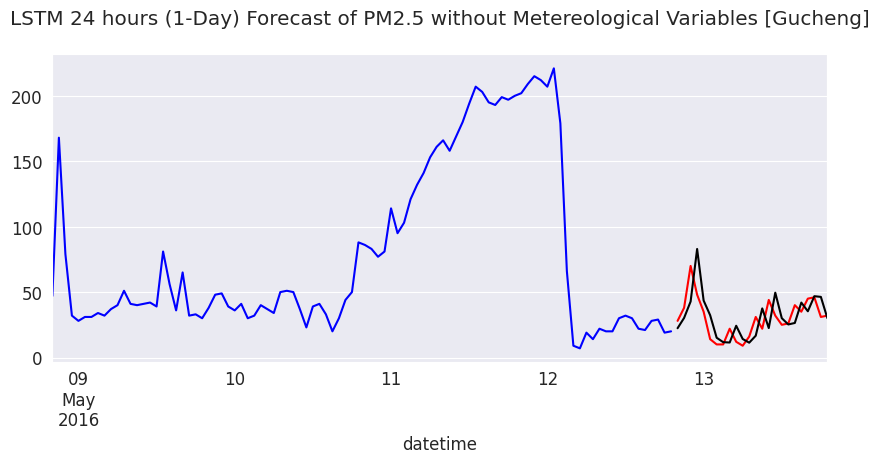

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain[-steps*4:], index=Xtrain.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
plt.title('LSTM 24 hours (1-Day) Forecast of PM2.5 without Metereological Variables [Gucheng]\n')
preds.plot(label='predictions', color='black')
plt.legend

In [ ]:
results_lstm_one_day = evaluate_model_performance(y_true, preds, label='lstm_one_day')
results_lstm_one_day

lstm_one_day
MAE              11.035
MSE             192.053
RMSE             13.858
R-Squared         0.081
MAPE              0.412

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- LSTM

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest[:steps]
one_weeky =  deep_ytest[:steps]
predictions = lstm_model.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 6ms/step


array([[22.381493],
       [30.257046],
       [42.79104 ],
       [82.94071 ],
       [43.532654]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    22.381493
2016-05-12 21:00:00    30.257046
2016-05-12 22:00:00    42.791039
2016-05-12 23:00:00    82.940712
2016-05-13 00:00:00    43.532654
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    28.0
2016-05-12 21:00:00    38.0
2016-05-12 22:00:00    70.0
2016-05-12 23:00:00    48.0
2016-05-13 00:00:00    35.0
Freq: H, Name: PM2.5, dtype: float64

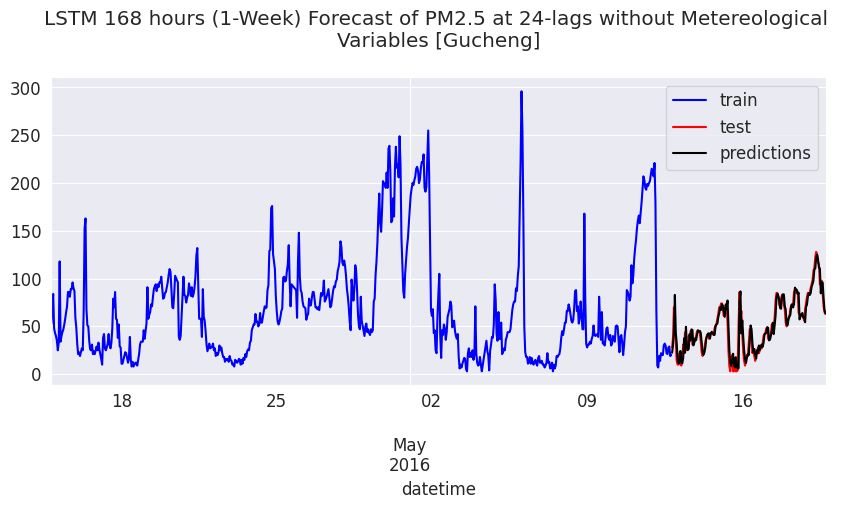

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain[-steps*4:], index=Xtrain.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 168 hours (1-Week) Forecast of PM2.5 at 24-lags without Metereological \nVariables [Gucheng]\n')
plt.legend()

In [ ]:
results_lstm_one_week = evaluate_model_performance(y_true, preds, label='lstm_one_week')
results_lstm_one_week

lstm_one_week
MAE                6.885
MSE               96.755
RMSE               9.836
R-Squared          0.876
MAPE               0.300

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest[:steps]
one_monthy =  deep_ytest[:steps]
predictions = lstm_model.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 6ms/step


array([[22.381493],
       [30.257046],
       [42.79104 ],
       [82.94071 ],
       [43.532654]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    22.381493
2016-05-12 21:00:00    30.257046
2016-05-12 22:00:00    42.791039
2016-05-12 23:00:00    82.940712
2016-05-13 00:00:00    43.532654
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    28.0
2016-05-12 21:00:00    38.0
2016-05-12 22:00:00    70.0
2016-05-12 23:00:00    48.0
2016-05-13 00:00:00    35.0
Freq: H, Name: PM2.5, dtype: float64

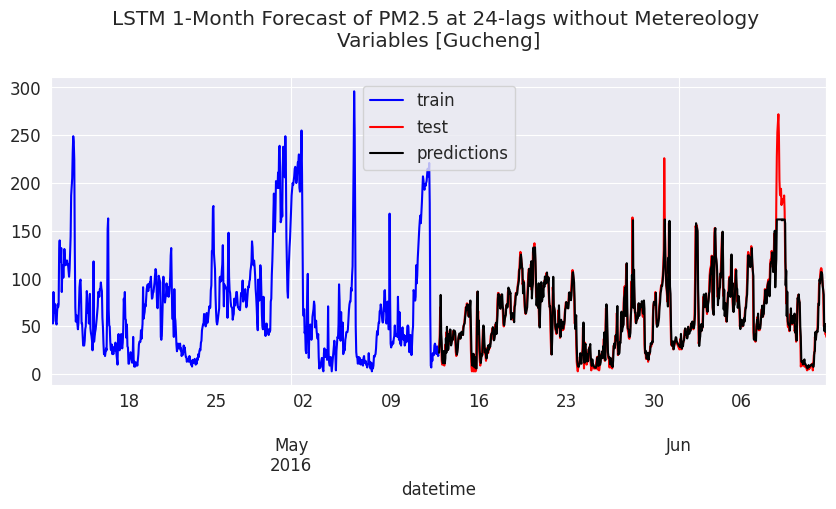

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain[-steps:], index=Xtrain.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 1-Month Forecast of PM2.5 at 24-lags without Metereology \nVariables [Gucheng]\n')
plt.legend()

In [ ]:
results_lstm_one_month = evaluate_model_performance(y_true, preds, label='lstm_one_month')
results_lstm_one_month

lstm_one_month
MAE                 9.099
MSE               233.350
RMSE               15.276
R-Squared           0.861
MAPE                0.230

##### Combined Results

In [ ]:
combined_results_lstm_no_met_24lags = pd.concat([
    results_lstm_one_day, 
    results_lstm_one_week, 
    results_lstm_one_month
], axis='columns')

combined_results_lstm_no_met_24lags

lstm_one_day  lstm_one_week  lstm_one_month
MAE              11.035          6.885           9.099
MSE             192.053         96.755         233.350
RMSE             13.858          9.836          15.276
R-Squared         0.081          0.876           0.861
MAPE              0.412          0.300           0.230

<Axes: title={'center': 'Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Gucheng]\n'}>

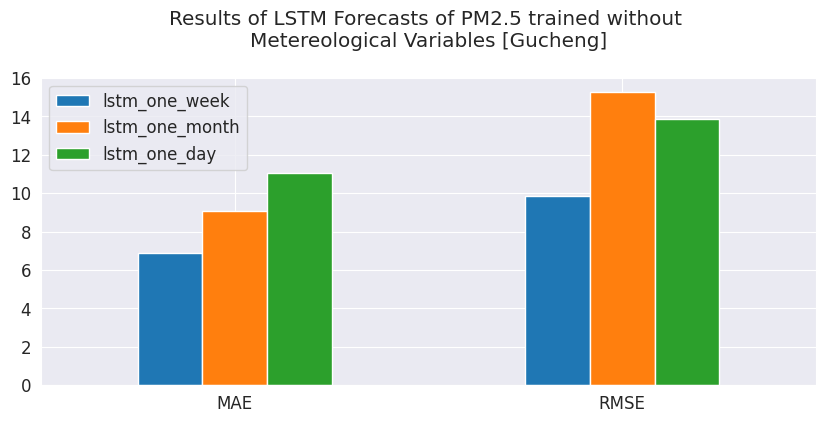

In [ ]:
combined_results_lstm_no_met_24lags.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)

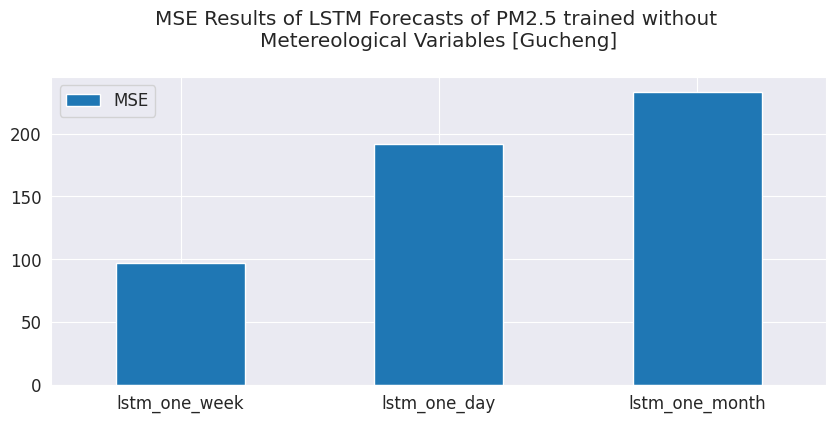

In [ ]:
combined_results_lstm_no_met_24lags.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

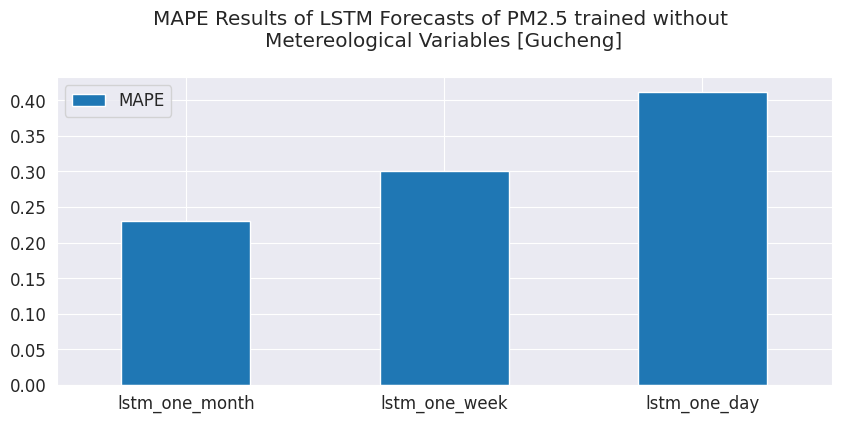

In [ ]:
combined_results_lstm_no_met_24lags.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

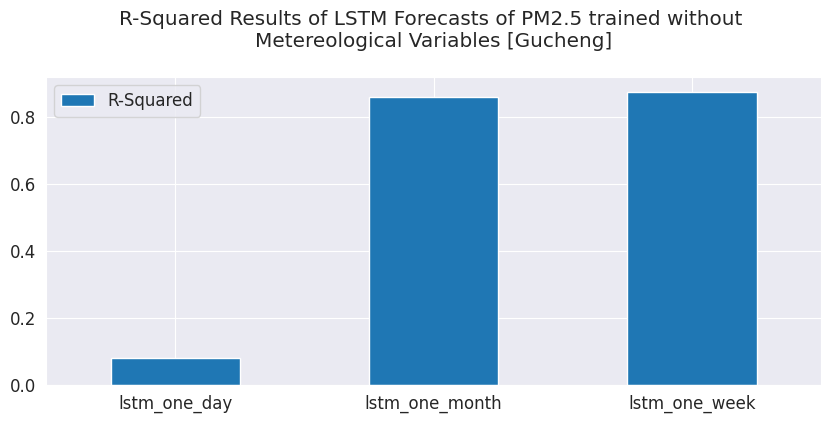

In [ ]:
combined_results_lstm_no_met_24lags.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of LSTM Forecasts of PM2.5 trained without \nMetereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
combined_results_lstm_no_met_24lags.to_csv(f'{RESULTS_PATH}/combined_results_lstm_no_met_24lags_Gucheng.csv')

## LSTM + All Exogenous Metereological Variables


- 1 day (24 hrs) lag
- LSTM (Bi-directional LSTM)
- Gucheng station data

In [ ]:
TEST_SIZE = int((20 / 100) * len(y_pm25_guch)) # 20%
N_LAGS = 24
N_FEATURES = 6

#### Data Preparation and preprocessing

In [ ]:
# merged scaled data and target
data_pm25_exo = pd.concat([scaled_features_X_guch, y_pm25_guch], axis='columns')
data_pm25_exo.head()

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.217891  1.213788 -1.537381 -0.076806  1.042002   
2013-03-01 01:00:00 -1.253305  1.253376 -1.566388 -0.076806  1.042002   
2013-03-01 02:00:00 -1.288720  1.253376 -1.624401 -0.076806  0.839651   
2013-03-01 03:00:00 -1.315281  1.372139 -1.725925 -0.076806  0.637301   
2013-03-01 04:00:00 -1.341842  1.401830 -1.740428 -0.076806  0.839651   

                         WSPM  PM2.5  
datetime                              
2013-03-01 00:00:00  2.655283    6.0  
2013-03-01 01:00:00  2.307770    6.0  
2013-03-01 02:00:00  2.829039    5.0  
2013-03-01 03:00:00  1.265234    6.0  
2013-03-01 04:00:00  1.960258    5.0

In [ ]:
# Data Segmentation (80% training : 20% testing)

Xtrain_exo, ytrain_exo, Xtest_exo, ytest_exo = \
    split_train_test_series_multivariate_series(
        data_pm25_exo, test_size=TEST_SIZE)

In [ ]:
Xtrain_exo.head(2)

TEMP      PRES      DEWP      RAIN        wd  \
datetime                                                                
2013-03-01 00:00:00 -1.217891  1.213788 -1.537381 -0.076806  1.042002   
2013-03-01 01:00:00 -1.253305  1.253376 -1.566388 -0.076806  1.042002   

                         WSPM  
datetime                       
2013-03-01 00:00:00  2.655283  
2013-03-01 01:00:00  2.307770

In [ ]:
ytrain_exo.head(2)

datetime
2013-03-01 00:00:00    6.0
2013-03-01 01:00:00    6.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Shape of X: {features_X_guch.shape}')
print(f'Shape of Xtrain: {Xtrain_exo.shape}')
print(f'Shape of Xtest: {Xtest_exo.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28052, 6)
Shape of Xtest: (7012, 6)


In [ ]:
deep_Xtrain_exo, deep_ytrain_exo = deep_prepare_X_y_for_CNN(
    X=Xtrain_exo, y=ytrain_exo, n_lags=N_LAGS, kind='multi_input')


deep_Xtest_exo, deep_ytest_exo = deep_prepare_X_y_for_CNN(
    X=Xtest_exo, y=ytest_exo, n_lags=N_LAGS, kind='multi_input')

In [ ]:
print(f'Shape of Xtrain: {Xtrain_exo.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_exo.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_exo.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_exo.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_exo.shape}')

Shape of Xtrain: (28052, 6)
Shape of Deep-Xtrain: (28029, 24, 6)
Shape of Deep-Xtest: (6989, 24, 6)
Shape of Deep-ytrain: (28029,)
Shape of Deep-ytest: (6989,)


In [ ]:
for i in range(2):
    print(deep_Xtrain_exo[i], deep_ytrain_exo[i])

[[-1.21789063  1.21378819 -1.53738112 -0.07680631  1.04200157  2.65528256]
 [-1.25330518  1.25337586 -1.56638783 -0.07680631  1.04200157  2.30777032]
 [-1.28871972  1.25337586 -1.62440125 -0.07680631  0.83965144  2.82903868]
 [-1.31528063  1.37213885 -1.72592474 -0.07680631  0.63730132  1.2652336 ]
 [-1.34184154  1.40182959 -1.7404281  -0.07680631  0.83965144  1.96025808]
 [-1.38610972  1.46121109 -1.77668649 -0.07680631 -0.98149966 -0.12481536]
 [-1.45693881  1.5304895  -1.66791132 -0.07680631 -1.18384979 -0.12481536]
 [-1.30642699  1.65914941 -1.675163   -0.07680631 -1.18384979 -0.21169342]
 [-1.21789063  1.70863399 -1.66065964 -0.07680631 -1.18384979  1.43898972]
 [-1.12935427  1.70863399 -1.68241468 -0.07680631 -1.38619991  1.2652336 ]
 [-1.05852518  1.70863399 -1.73317642 -0.07680631 -1.18384979  1.43898972]
 [-0.93457427  1.70863399 -1.70416971 -0.07680631 -1.18384979  1.61274584]
 [-0.86374518  1.60966483 -1.66065964 -0.07680631 -1.18384979  1.61274584]
 [-0.75750154  1.51069567

#### LSTM Model Buiding 

##### LSTM Configuration Variant 1 (Bi-directional LSTM Variant) 

In [ ]:
# del lstm_model_exo

In [ ]:
lstm_model_exo = Sequential([
    # Bi-directional input layer 1
    Bidirectional(LSTM(200, return_sequences=True), 
            input_shape=(N_LAGS, N_FEATURES)),
    # output of layer 1
    Dense(20, activation='tanh'),

    # Bi-directional input layer 2
    Bidirectional(LSTM(150)),
    # output of layer 1 and output of layer 2
    Dense(20, activation='tanh'), # layer 1 hidden-state
    Dense(20, activation='tanh'), # layer 2 hidden-state
    Dropout(0.25),

    # Output layer
    Dense(units=1),
 ])

lstm_model_exo.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[
      MeanAbsoluteError(),
      RootMeanSquaredError(),
      MeanAbsolutePercentageError()
    ])

lstm_model_exo.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 24, 400)          331200    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 24, 20)            8020      
                                                                 
 bidirectional_5 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 20)                6020      
                                                                 
 dense_16 (Dense)            (None, 20)                420       
                                                                 
 dropout_2 (Dropout)         (None, 20)               

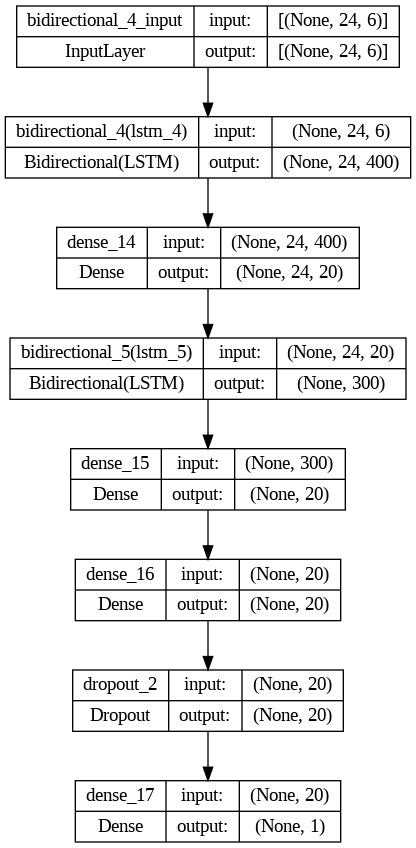

In [ ]:
# Model Architecture
plot_model(lstm_model_exo, to_file='lstm_model_guch_with_all_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

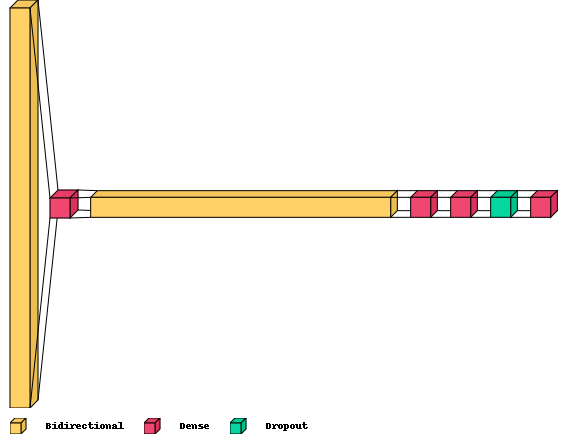

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    lstm_model_exo, legend=True, 
    scale_xy=1,
    scale_z=1,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_lstm_pm25_with_all_met_vars_Gucheng_architecture.png')

In [ ]:
# Training the LSTM model

# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# For learning performance improvement
lr_reducer = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)


# Fitting the model & applying callbacks
history = lstm_model_exo.fit(
    deep_Xtrain_exo, deep_ytrain_exo, 
    # validation_data=(deep_Xval, deep_yval), 
    batch_size=BATCH_SIZE, epochs = 150, verbose=1, 
    callbacks=[lr_reducer, early_stopper])


Epoch 1/150
1402/1402 [==============================] - 23s 12ms/step - loss: 10866.8076 - mean_absolute_error: 68.9706 - root_mean_squared_error: 104.2440 - mean_absolute_percentage_error: 85.8938 - lr: 0.0010
Epoch 2/150
1402/1402 [==============================] - 16s 12ms/step - loss: 8429.1748 - mean_absolute_error: 59.5067 - root_mean_squared_error: 91.8105 - mean_absolute_percentage_error: 125.1916 - lr: 9.0000e-04
Epoch 3/150
1402/1402 [==============================] - 16s 12ms/step - loss: 7315.6333 - mean_absolute_error: 57.3799 - root_mean_squared_error: 85.5315 - mean_absolute_percentage_error: 167.2828 - lr: 8.1000e-04
Epoch 4/150
1402/1402 [==============================] - 17s 12ms/step - loss: 6888.3623 - mean_absolute_error: 58.0181 - root_mean_squared_error: 82.9962 - mean_absolute_percentage_error: 201.9082 - lr: 7.2900e-04
Epoch 5/150
1402/1402 [==============================] - 16s 12ms/step - loss: 6751.3696 - mean_absolute_error: 58.8984 - root_mean_squared_err

In [ ]:
# history.history

best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["loss"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')

TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 53
MAE: 32.08687973022461
MSE: 3136.948974609375
RMSE: 56.00847244262695
MAPE: 63.10624313354492


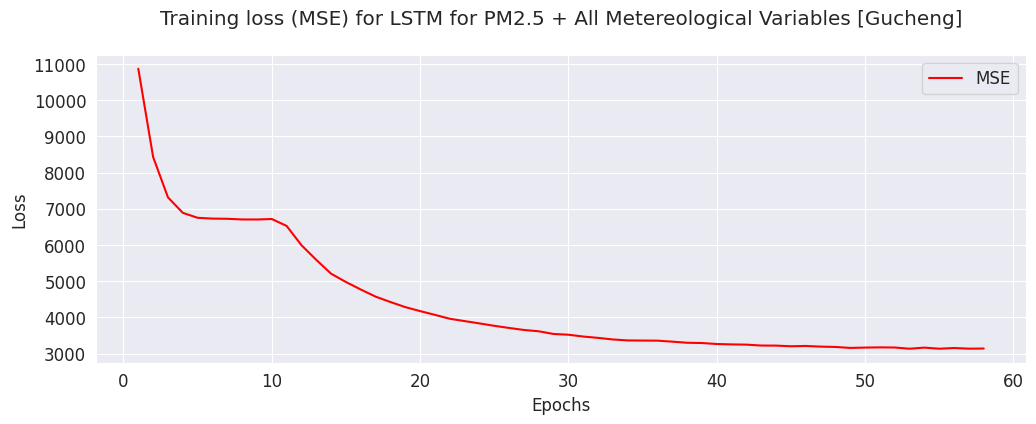

In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for LSTM for PM2.5 + All Metereological Variables [Gucheng]\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 21.722222222222214, 'Epochs')

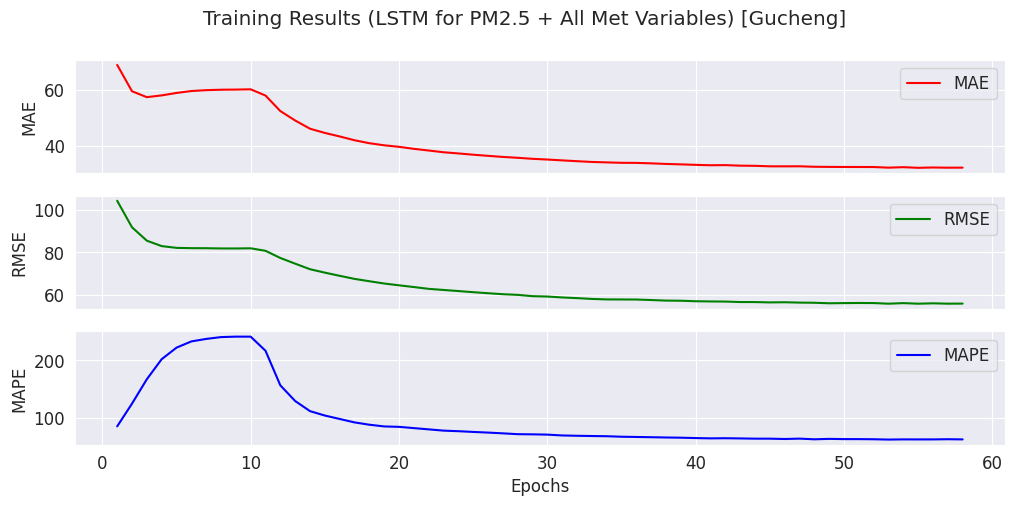

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (LSTM for PM2.5 + All Met Variables) [Gucheng]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


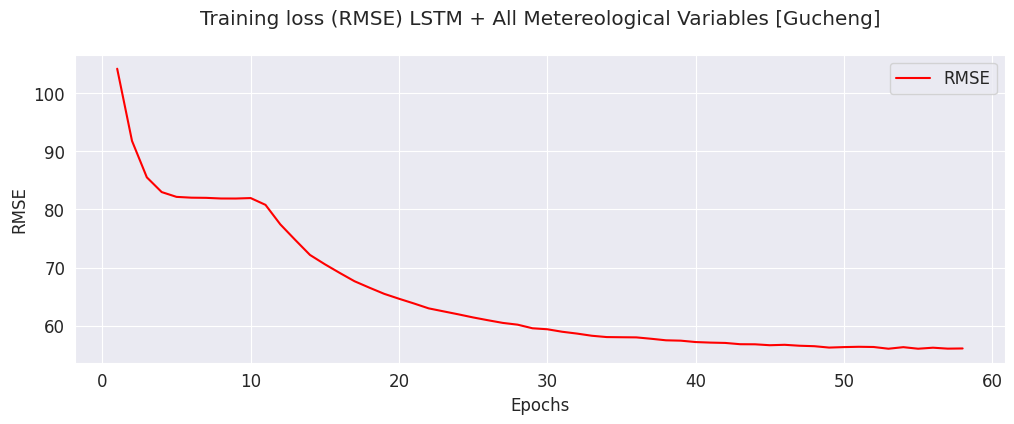

In [ ]:
# Training RMSE
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) LSTM + All Metereological Variables [Gucheng]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# Saving the trained model
lstm_model_exo.save(f'{MODEL_PATH}/lstm_model_pm25_with_all_met_vars_added_Gucheng.h5')

In [ ]:
# # loading the trained model
# lstm_model_exo = load_model(f'{MODEL_PATH}/lstm_model_pm25_with_all_met_vars_added_Gucheng.h5')

---

#### Making Forecasts

In [ ]:
# Loading saved trained model
lstm_model_exo = load_model(f'{MODEL_PATH}/lstm_model_pm25_with_all_met_vars_added_Gucheng.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- 24 steps (hours) forecast
- LSTM (Bi-directional)

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest_exo[:steps]
one_dayy =  deep_ytest_exo[:steps]
predictions = lstm_model_exo.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 0s 34ms/step


array([[77.71238],
       [72.7563 ],
       [75.29169],
       [79.58656],
       [79.73956]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_exo.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    77.712379
2016-05-12 21:00:00    72.756302
2016-05-12 22:00:00    75.291687
2016-05-12 23:00:00    79.586563
2016-05-13 00:00:00    79.739563
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

<function matplotlib.pyplot.legend(*args, **kwargs)>

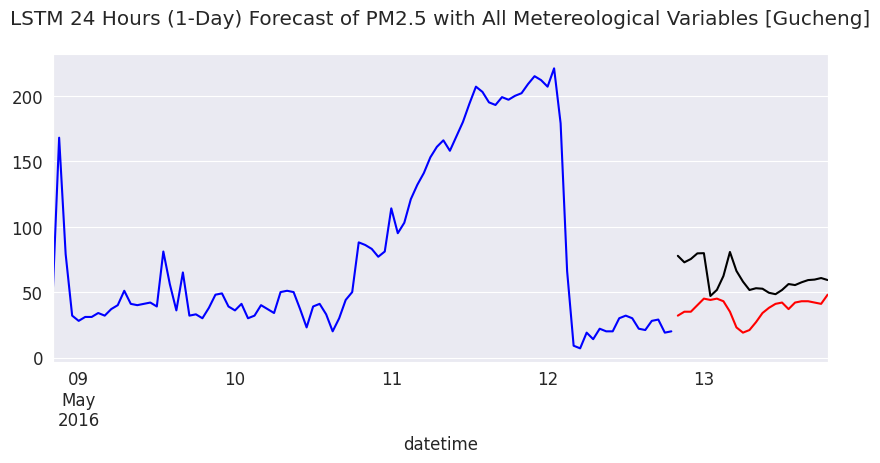

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_exo[-steps*4:], 
          index=Xtrain_exo.index[-steps*4:], name='PM2.5').plot(
              label='train', color='b')
          
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 24 Hours (1-Day) Forecast of PM2.5 with All Metereological Variables [Gucheng]\n')
plt.legend

In [ ]:
results_lstm_one_day_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_day')
results_lstm_one_day_forecast_sel_met_24lags

lstm_one_day
MAE              23.756
MSE             744.963
RMSE             27.294
R-Squared       -11.391
MAPE              0.737

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- LSTM

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest_exo[:steps]
one_weeky =  deep_ytest_exo[:steps]
predictions = lstm_model_exo.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 11ms/step


array([[77.71238],
       [72.7563 ],
       [75.29169],
       [79.58656],
       [79.73956]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_exo.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    77.712379
2016-05-12 21:00:00    72.756302
2016-05-12 22:00:00    75.291687
2016-05-12 23:00:00    79.586563
2016-05-13 00:00:00    79.739563
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

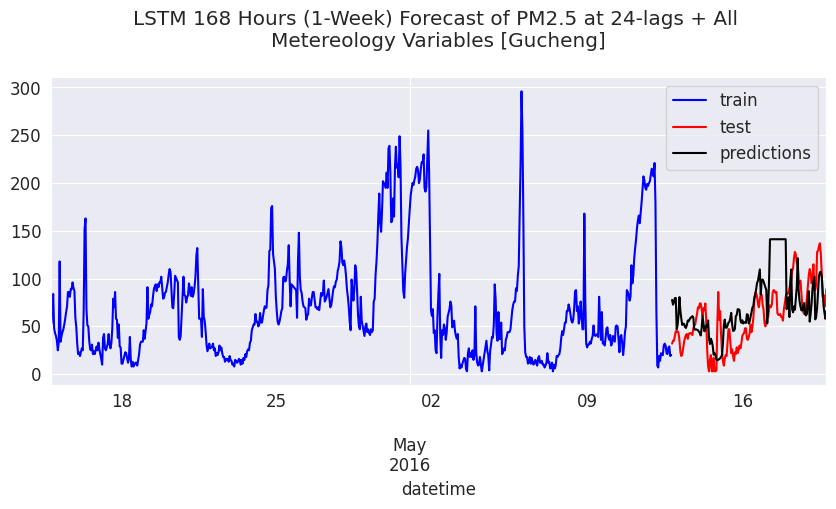

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_exo[-steps*4:], index=Xtrain_exo.index[-steps*4:], 
          name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 168 Hours (1-Week) Forecast of PM2.5 at 24-lags + All \nMetereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_lstm_one_week_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_week')
results_lstm_one_week_forecast_sel_met_24lags

lstm_one_week
MAE               27.745
MSE             1174.240
RMSE              34.267
R-Squared         -0.189
MAPE               0.878

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- LSTM

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest_exo[:steps]
one_monthy =  deep_ytest_exo[:steps]
predictions = lstm_model_exo.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 7ms/step


array([[77.71238],
       [72.7563 ],
       [75.29169],
       [79.58656],
       [79.73956]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest_exo.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_exo.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    77.712379
2016-05-12 21:00:00    72.756302
2016-05-12 22:00:00    75.291687
2016-05-12 23:00:00    79.586563
2016-05-13 00:00:00    79.739563
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

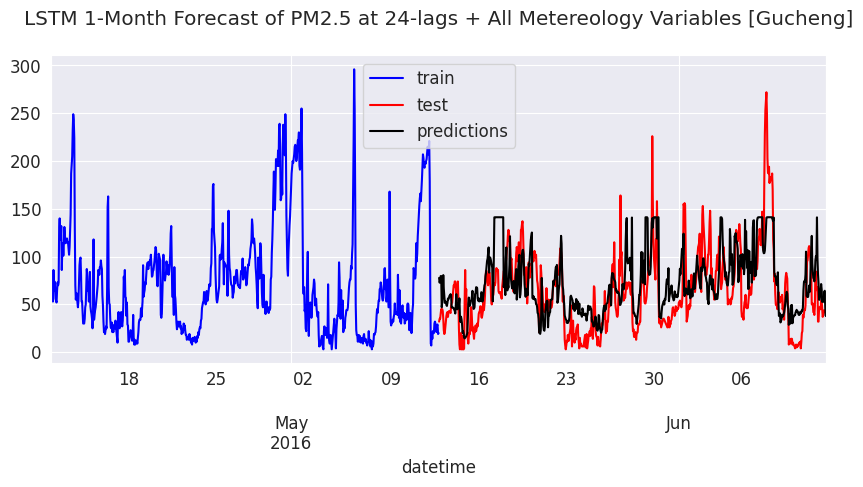

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_exo[-steps:], index=Xtrain_exo.index[-steps:], 
          name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 1-Month Forecast of PM2.5 at 24-lags + All Metereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_lstm_one_month_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_month')
results_lstm_one_month_forecast_sel_met_24lags

lstm_one_month
MAE                26.749
MSE              1141.651
RMSE               33.788
R-Squared           0.309
MAPE                0.846

##### Combined Results

In [ ]:
lstm_results_pm25_with_sel_met_vars = pd.concat([
    results_lstm_one_day_forecast_sel_met_24lags, 
    results_lstm_one_week_forecast_sel_met_24lags,
    results_lstm_one_month_forecast_sel_met_24lags
    ], axis='columns')

lstm_results_pm25_with_sel_met_vars

lstm_one_day  lstm_one_week  lstm_one_month
MAE              23.756         27.745          26.749
MSE             744.963       1174.240        1141.651
RMSE             27.294         34.267          33.788
R-Squared       -11.391         -0.189           0.309
MAPE              0.737          0.878           0.846

<Axes: title={'center': 'Results of LSTM Forecasts of PM2.5 trained + All Metereological\n Variables [Gucheng]\n'}>

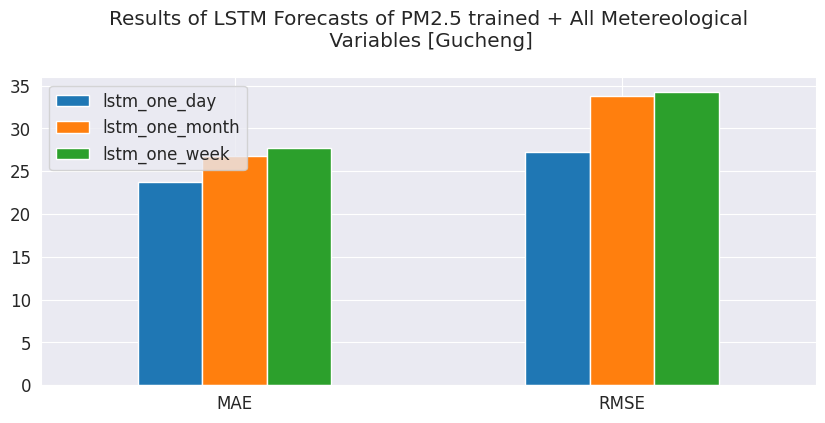

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of LSTM Forecasts of PM2.5 trained + All Metereological\n Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)

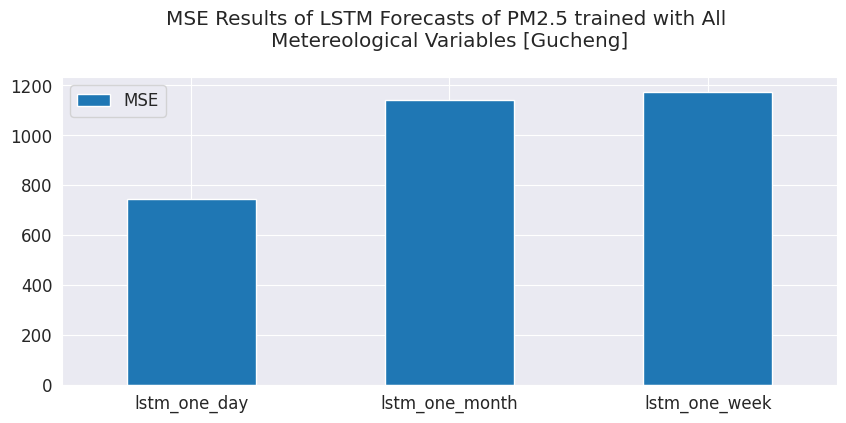

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of LSTM Forecasts of PM2.5 trained with All \nMetereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

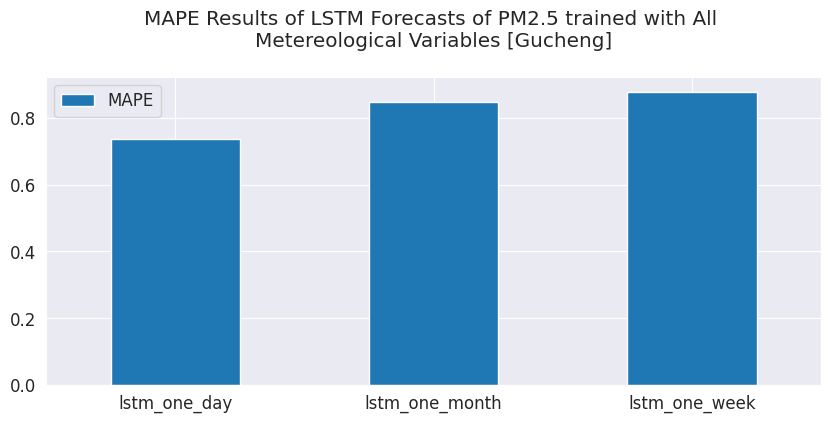

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of LSTM Forecasts of PM2.5 trained with All \nMetereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

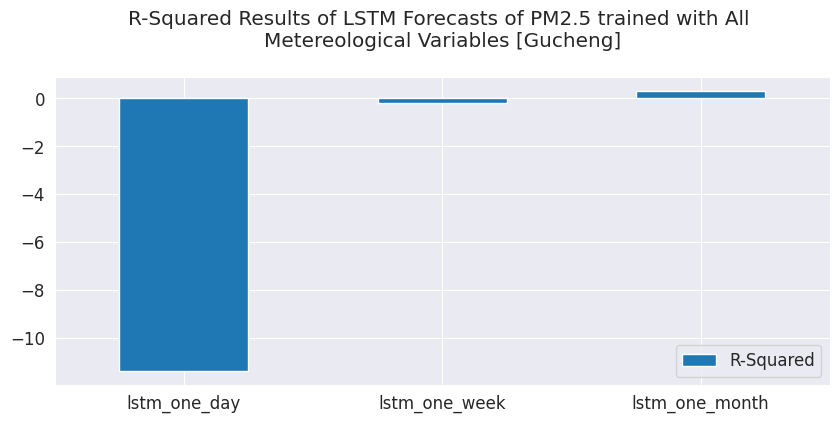

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of LSTM Forecasts of PM2.5 trained with All \nMetereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
lstm_results_pm25_with_sel_met_vars.to_csv(f'{RESULTS_PATH}/lstm_results_pm25_with_all_met_vars_24lags_Gucheng.csv')

## LSTM + [Selected] Exogenous Metereological Variables

- 1 day (24 hrs) lag
- LSTM
- Gucheng station data

In [ ]:
TEST_SIZE = int((20 / 100) * len(y_pm25_guch)) # 20%
N_LAGS = 24
N_FEATURES = 4

EPOCHS = 150
BATCH_SIZE = 20

#### Data Preparation and preprocessing

In [ ]:
features_X_guch.corrwith(y_pm25_guch).sort_values()

WSPM   -0.251702
TEMP   -0.145860
wd     -0.025076
RAIN   -0.020184
PRES    0.022596
DEWP    0.097060
dtype: float64

In [ ]:
# merged scaled data and target
data_pm25_sel = pd.concat([scaled_features_X_guch[['WSPM', 'wd', 'TEMP', 'DEWP']], y_pm25_guch], axis='columns')
data_pm25_sel.head()

WSPM        wd      TEMP      DEWP  PM2.5
datetime                                                          
2013-03-01 00:00:00  2.655283  1.042002 -1.217891 -1.537381    6.0
2013-03-01 01:00:00  2.307770  1.042002 -1.253305 -1.566388    6.0
2013-03-01 02:00:00  2.829039  0.839651 -1.288720 -1.624401    5.0
2013-03-01 03:00:00  1.265234  0.637301 -1.315281 -1.725925    6.0
2013-03-01 04:00:00  1.960258  0.839651 -1.341842 -1.740428    5.0

In [ ]:
# Data Segmentation (80% training : 20% testing)

Xtrain_sel, ytrain_sel, Xtest_sel, ytest_sel = \
    split_train_test_series_multivariate_series(
        data_pm25_sel, test_size=TEST_SIZE)

In [ ]:
Xtrain_sel.head(2)

WSPM        wd      TEMP      DEWP
datetime                                                   
2013-03-01 00:00:00  2.655283  1.042002 -1.217891 -1.537381
2013-03-01 01:00:00  2.307770  1.042002 -1.253305 -1.566388

In [ ]:
ytrain_sel.head(2)

datetime
2013-03-01 00:00:00    6.0
2013-03-01 01:00:00    6.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Shape of X: {scaled_features_X_guch.shape}')
print(f'Shape of Xtrain: {Xtrain_sel.shape}')
print(f'Shape of Xtest: {Xtest_sel.shape}')

Shape of X: (35064, 6)
Shape of Xtrain: (28052, 4)
Shape of Xtest: (7012, 4)


In [ ]:
deep_Xtrain_sel, deep_ytrain_sel = deep_prepare_X_y_for_CNN(
    X=Xtrain_sel, y=ytrain_sel, n_lags=N_LAGS, kind='multi_input')


deep_Xtest_sel, deep_ytest_sel = deep_prepare_X_y_for_CNN(
    X=Xtest_sel, y=ytest_sel, n_lags=N_LAGS, kind='multi_input')

In [ ]:
print(f'Shape of Xtrain: {Xtrain_sel.shape}')
print(f'Shape of Deep-Xtrain: {deep_Xtrain_sel.shape}')
print(f'Shape of Deep-Xtest: {deep_Xtest_sel.shape}')
print(f'Shape of Deep-ytrain: {deep_ytrain_sel.shape}')
print(f'Shape of Deep-ytest: {deep_ytest_sel.shape}')

Shape of Xtrain: (28052, 4)
Shape of Deep-Xtrain: (28029, 24, 4)
Shape of Deep-Xtest: (6989, 24, 4)
Shape of Deep-ytrain: (28029,)
Shape of Deep-ytest: (6989,)


In [ ]:
for i in range(2):
    print(deep_Xtrain_sel[i], deep_ytrain_sel[i])

[[ 2.65528256  1.04200157 -1.21789063 -1.53738112]
 [ 2.30777032  1.04200157 -1.25330518 -1.56638783]
 [ 2.82903868  0.83965144 -1.28871972 -1.62440125]
 [ 1.2652336   0.63730132 -1.31528063 -1.72592474]
 [ 1.96025808  0.83965144 -1.34184154 -1.7404281 ]
 [-0.12481536 -0.98149966 -1.38610972 -1.77668649]
 [-0.12481536 -1.18384979 -1.45693881 -1.66791132]
 [-0.21169342 -1.18384979 -1.30642699 -1.675163  ]
 [ 1.43898972 -1.18384979 -1.21789063 -1.66065964]
 [ 1.2652336  -1.38619991 -1.12935427 -1.68241468]
 [ 1.43898972 -1.18384979 -1.05852518 -1.73317642]
 [ 1.61274584 -1.18384979 -0.93457427 -1.70416971]
 [ 1.61274584 -1.18384979 -0.86374518 -1.66065964]
 [ 1.17835554 -1.38619991 -0.75750154 -1.64615629]
 [ 0.65708718 -1.38619991 -0.73979427 -1.63890461]
 [ 1.17835554 -1.18384979 -0.66896518 -1.58814286]
 [ 0.396453   -1.18384979 -0.70437973 -1.55188448]
 [-0.29857148  0.83965144 -0.77520882 -1.5446328 ]
 [ 0.22269688 -0.98149966 -0.89915972 -1.58089119]
 [ 0.30957494 -0.98149966 -0.98

#### LSTM Model Buiding 

##### LSTM Configuration Variant 1 (Bi-directional LSTM Variant) 

In [ ]:
# del lstm_model_sel

In [ ]:
lstm_model_sel = Sequential([
    # Bi-directional input layer 1
    Bidirectional(LSTM(200, return_sequences=True), 
            input_shape=(N_LAGS, N_FEATURES)),
    # output of layer 1
    Dense(50, activation='tanh'),

    # Bi-directional input layer 2
    Bidirectional(LSTM(150)),
    # output of layer 1 and output of layer 2
    Dense(24, activation='tanh'), # layer 1 hidden-state
    Dense(24, activation='tanh'), # layer 2 hidden-state
    Dropout(0.25),

    # Output layer
    Dense(units=1),
 ])

lstm_model_sel.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mse', 
    metrics=[
      MeanAbsoluteError(),
      RootMeanSquaredError(),
      MeanAbsolutePercentageError()
    ])

lstm_model_sel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 24, 400)          328000    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 24, 50)            20050     
                                                                 
 bidirectional_7 (Bidirectio  (None, 300)              241200    
 nal)                                                            
                                                                 
 dense_19 (Dense)            (None, 24)                7224      
                                                                 
 dense_20 (Dense)            (None, 24)                600       
                                                                 
 dropout_3 (Dropout)         (None, 24)               

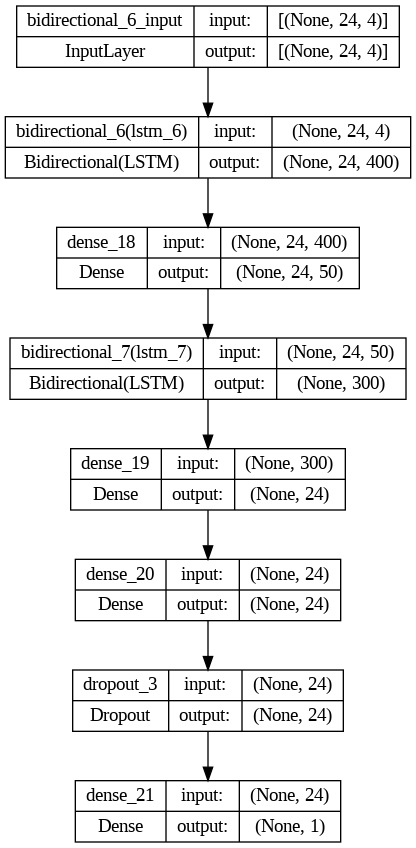

In [ ]:
# Model Architecture
plot_model(lstm_model_sel, to_file='lstm_model_guch_with_selected_exo_met_vars_added_multi_input.png', show_shapes=True, show_layer_names=True)

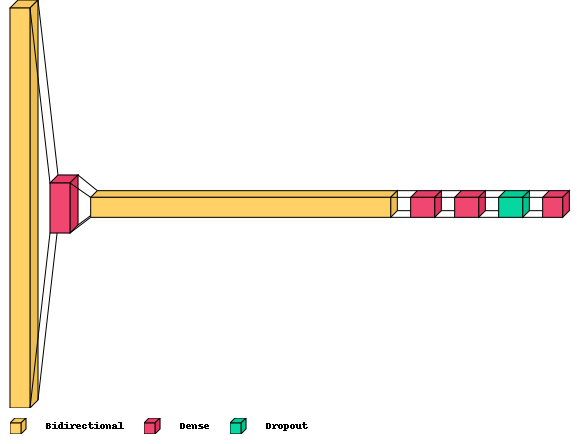

In [ ]:
# plt.figure(figsize=(12,4))
visualkeras.layered_view(
    lstm_model_sel, legend=True, 
    scale_xy=1,
    scale_z=1,
    spacing=20,
    background_fill='white',
    to_file=f'{RESULTS_PATH}/deep_lstm_pm25_with_sel_met_vars_Gucheng_architecture.png')

In [ ]:
# Training the LSTM model

# callbacks (EarlyStopper to avoid overfitting)
early_stopper = EarlyStopping(
    monitor="loss",
    min_delta=0.05,  # p-value (significance)
    patience=5,
    restore_best_weights=True,
)

# For learning performance improvement
lr_reducer = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)


# Fitting the model & applying callbacks
history = lstm_model_sel.fit(
    deep_Xtrain_sel, deep_ytrain_sel, 
    # validation_data=(deep_Xval, deep_yval), 
    batch_size=BATCH_SIZE, epochs = EPOCHS, verbose=1, 
    callbacks=[lr_reducer, early_stopper])


Epoch 1/150
1402/1402 [==============================] - 24s 13ms/step - loss: 10708.3535 - mean_absolute_error: 68.3512 - root_mean_squared_error: 103.4812 - mean_absolute_percentage_error: 87.8482 - lr: 0.0010
Epoch 2/150
1402/1402 [==============================] - 21s 15ms/step - loss: 8065.9385 - mean_absolute_error: 58.5981 - root_mean_squared_error: 89.8106 - mean_absolute_percentage_error: 136.7059 - lr: 9.0000e-04
Epoch 3/150
1402/1402 [==============================] - 20s 14ms/step - loss: 7070.0249 - mean_absolute_error: 57.4707 - root_mean_squared_error: 84.0834 - mean_absolute_percentage_error: 184.3891 - lr: 8.1000e-04
Epoch 4/150
1402/1402 [==============================] - 17s 12ms/step - loss: 6768.8613 - mean_absolute_error: 58.4958 - root_mean_squared_error: 82.2731 - mean_absolute_percentage_error: 215.4603 - lr: 7.2900e-04
Epoch 5/150
1402/1402 [==============================] - 16s 12ms/step - loss: 6706.4722 - mean_absolute_error: 59.4346 - root_mean_squared_err

In [ ]:
# history.history

best_epoch = history.history['loss'].index(min(history.history['loss']))
print('TRAINING RESULT SUMMARY')
print('-----------------------\n')
print(f'Best Epoch: {best_epoch + 1}')
print(f'MAE: {history.history["mean_absolute_error"][best_epoch]}')
print(f'MSE: {history.history["loss"][best_epoch]}')
print(f'RMSE: {history.history["root_mean_squared_error"][best_epoch]}')
print(f'MAPE: {history.history["mean_absolute_percentage_error"][best_epoch]}')

TRAINING RESULT SUMMARY
-----------------------

Best Epoch: 46
MAE: 34.47006607055664
MSE: 3093.859375
RMSE: 55.62247085571289
MAPE: 76.28636169433594


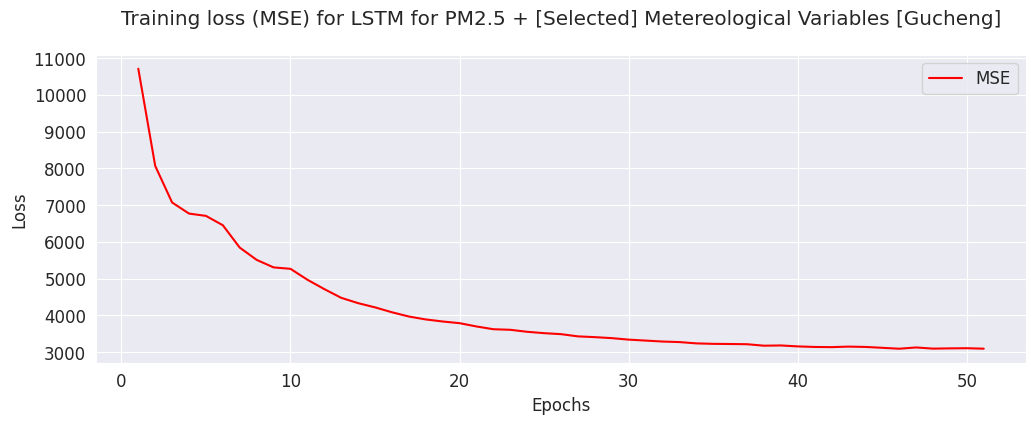

In [ ]:
# MSE (Loss)
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
         label='MSE', color='r')
plt.title('Training loss (MSE) for LSTM for PM2.5 + [Selected] Metereological Variables [Gucheng]\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0.5, 21.722222222222214, 'Epochs')

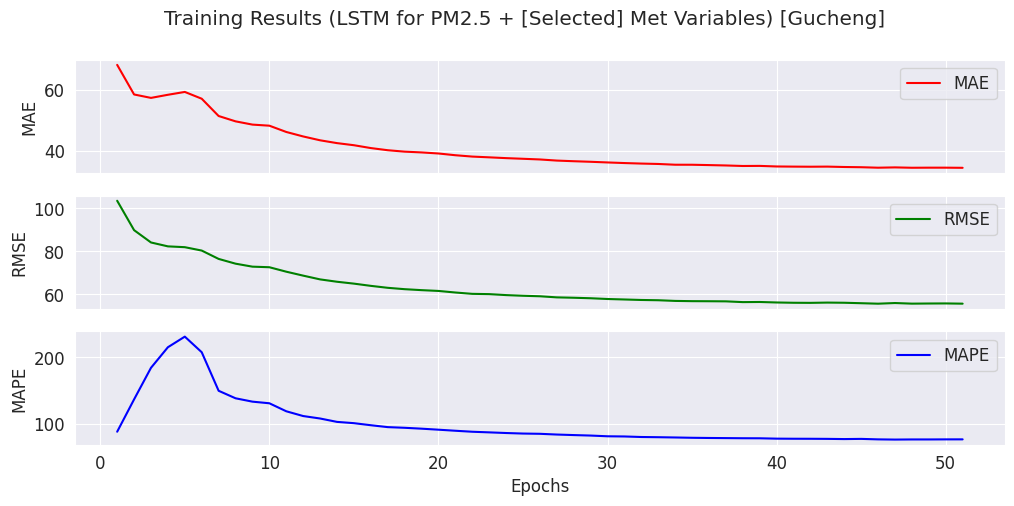

In [ ]:
# Training Performances
fig, axs = plt.subplots(3, sharex=True, figsize=(12,5))
fig.suptitle('Training Results (LSTM for PM2.5 + [Selected] Met Variables) [Gucheng]')

# MAE
axs[0].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_error'], 
            label='MAE', color='r')
axs[0].set_ylabel('MAE')
axs[0].legend()

# RMSE
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['root_mean_squared_error'], 
            label='RMSE', color='g')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# MAPE
axs[2].plot(range(1, len(history.history['loss']) + 1), history.history['mean_absolute_percentage_error'], 
            label='MAPE', color='b')
axs[2].set_ylabel('MAPE')
axs[2].legend()
fig.tight_layout(pad=7.0)
plt.xlabel('Epochs')


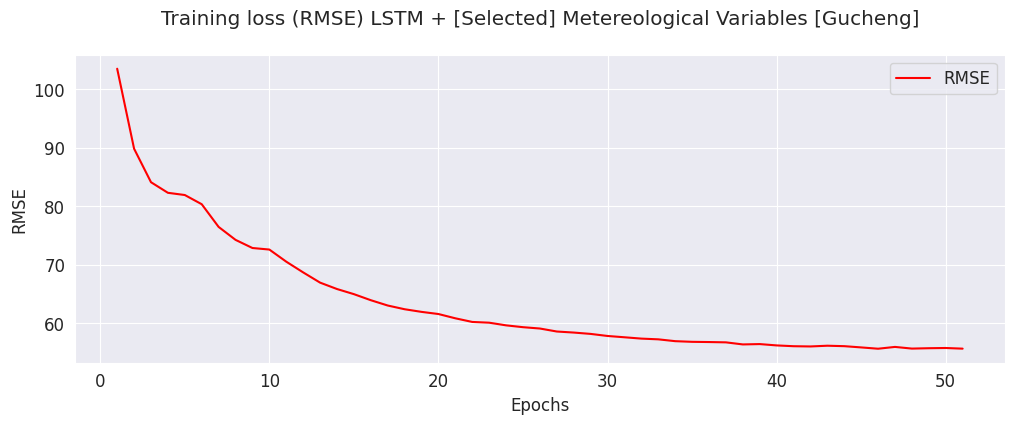

In [ ]:
# Training RMSE
plt.figure(figsize=(12,4))
plt.plot(range(1, len(history.history['loss']) + 1), np.sqrt(history.history['loss']), label='RMSE', color='r')
plt.title('Training loss (RMSE) LSTM + [Selected] Metereological Variables [Gucheng]\n')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# Saving the trained model
lstm_model_sel.save(f'{MODEL_PATH}/lstm_model_pm25_with_selected_met_vars_added_Gucheng.h5')

---

#### Making Forecasts

In [ ]:
# Loading saved trained model
lstm_model_sel = load_model(f'{MODEL_PATH}/lstm_model_pm25_with_selected_met_vars_added_Gucheng.h5')

##### 24 hrs (One day) Forecast
- 24-lags
- LSTM (Bi-directional)

In [ ]:
steps = 24

In [ ]:
one_dayX =  deep_Xtest_sel[:steps]
one_dayy =  deep_ytest_sel[:steps]
predictions = lstm_model_sel.predict(one_dayX)
predictions[:5]

1/1 [==============================] - 1s 1s/step


array([[78.15739 ],
       [90.70614 ],
       [92.070496],
       [91.64964 ],
       [97.103714]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_dayy, index=Xtest_sel.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    78.157387
2016-05-12 21:00:00    90.706139
2016-05-12 22:00:00    92.070496
2016-05-12 23:00:00    91.649643
2016-05-13 00:00:00    97.103714
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

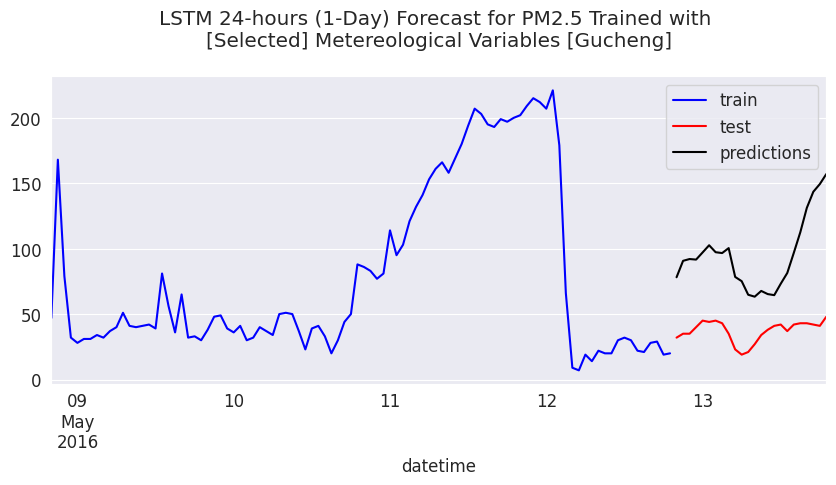

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_sel[-steps*4:], index=Xtrain_sel.index[-steps*4:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 24-hours (1-Day) Forecast for PM2.5 Trained with \n[Selected] Metereological Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_lstm_1_day_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_day_sel')
results_lstm_1_day_forecast_sel_met_24lags

lstm_one_day_sel
MAE                  57.321
MSE                3815.625
RMSE                 61.771
R-Squared           -62.463
MAPE                  1.585

##### One Week (168hrs) Forecast
- One week (24 * 7 = 168 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 7

In [ ]:
one_weekX =  deep_Xtest_sel[:steps]
one_weeky =  deep_ytest_sel[:steps]
predictions = lstm_model_sel.predict(one_weekX)
predictions[:5]

6/6 [==============================] - 0s 7ms/step


array([[78.15739 ],
       [90.70614 ],
       [92.070496],
       [91.64964 ],
       [97.103714]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_weeky, index=Xtest_sel.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    78.157387
2016-05-12 21:00:00    90.706139
2016-05-12 22:00:00    92.070496
2016-05-12 23:00:00    91.649643
2016-05-13 00:00:00    97.103714
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

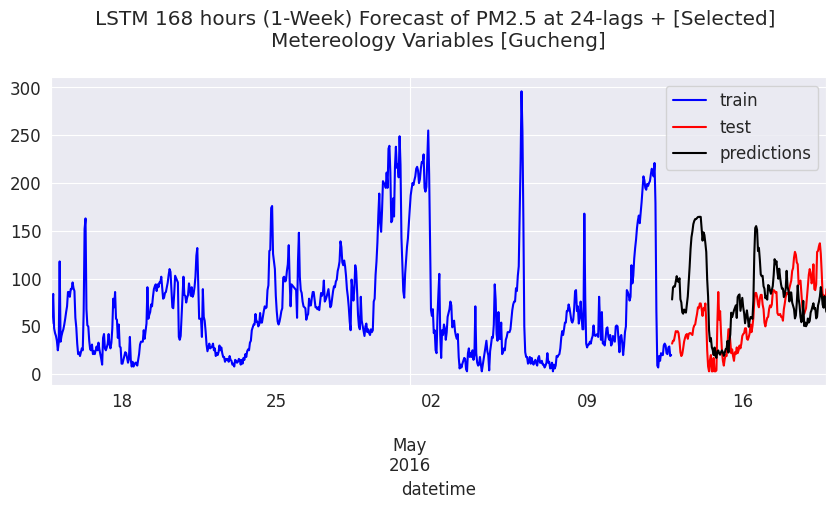

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_sel[-steps*4:], index=Xtrain_sel.index[-steps*4:], 
          name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 168 hours (1-Week) Forecast of PM2.5 at 24-lags + [Selected] \nMetereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_lstm_1_week_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_week_sel')
results_lstm_1_week_forecast_sel_met_24lags

lstm_one_week_sel
MAE                   38.358
MSE                 2159.805
RMSE                  46.474
R-Squared             -1.187
MAPE                   1.100

##### One Month (744 hrs) Forecast
- One month (24 * 31 = 744 hrs steps) into the future
- 24-lags
- CNN

In [ ]:
steps = 24 * 31

In [ ]:
one_monthX =  deep_Xtest_sel[:steps]
one_monthy =  deep_ytest_sel[:steps]
predictions = lstm_model_sel.predict(one_monthX)
predictions[:5]

24/24 [==============================] - 0s 8ms/step


array([[78.15739 ],
       [90.70614 ],
       [92.070496],
       [91.64964 ],
       [97.103714]], dtype=float32)

In [ ]:
preds = pd.Series(predictions.flatten(), index=Xtest_sel.index[:steps], name='PM2.5')
y_true = pd.Series(one_monthy, index=Xtest_sel.index[:steps], name='PM2.5')
preds.head()

datetime
2016-05-12 20:00:00    78.157387
2016-05-12 21:00:00    90.706139
2016-05-12 22:00:00    92.070496
2016-05-12 23:00:00    91.649643
2016-05-13 00:00:00    97.103714
Freq: H, Name: PM2.5, dtype: float32

In [ ]:
y_true.head()

datetime
2016-05-12 20:00:00    32.0
2016-05-12 21:00:00    35.0
2016-05-12 22:00:00    35.0
2016-05-12 23:00:00    40.0
2016-05-13 00:00:00    45.0
Freq: H, Name: PM2.5, dtype: float64

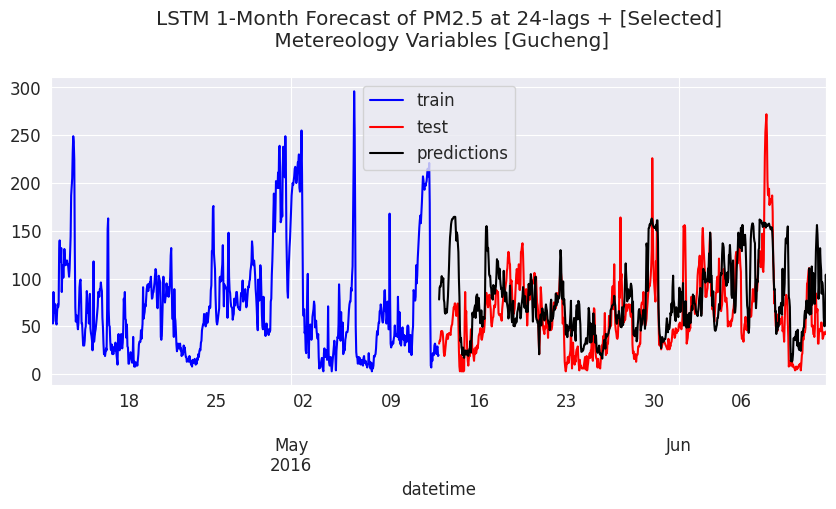

In [ ]:
plt.figure(figsize=(10,4))
pd.Series(deep_ytrain_sel[-steps:], index=Xtrain_sel.index[-steps:], name='PM2.5').plot(label='train', color='b')
y_true.plot(label='test', color='r')
preds.plot(label='predictions', color='black')
plt.title('LSTM 1-Month Forecast of PM2.5 at 24-lags + [Selected]\n Metereology Variables [Gucheng]\n')
plt.legend()

In [ ]:
results_lstm_1_month_forecast_sel_met_24lags = evaluate_model_performance(y_true, preds, label='lstm_one_month_sel_met')
results_lstm_1_month_forecast_sel_met_24lags

lstm_one_month_sel_met
MAE                        30.434
MSE                      1523.549
RMSE                       39.033
R-Squared                   0.077
MAPE                        0.921

##### Combined Results

In [ ]:
lstm_results_pm25_with_sel_met_vars = pd.concat([
    results_lstm_1_day_forecast_sel_met_24lags, 
    results_lstm_1_week_forecast_sel_met_24lags,
    results_lstm_1_month_forecast_sel_met_24lags
    ], axis='columns')

lstm_results_pm25_with_sel_met_vars

lstm_one_day_sel  lstm_one_week_sel  lstm_one_month_sel_met
MAE                  57.321             38.358                  30.434
MSE                3815.625           2159.805                1523.549
RMSE                 61.771             46.474                  39.033
R-Squared           -62.463             -1.187                   0.077
MAPE                  1.585              1.100                   0.921

<Axes: title={'center': 'Results of LSTM Forecasts of PM2.5 trained with \n[Selected] Metereological Variables [Gucheng]\n'}>

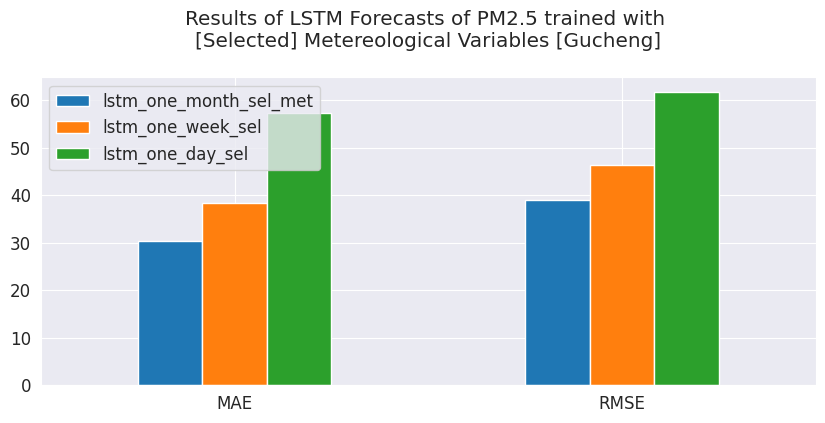

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[[0,2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Results of LSTM Forecasts of PM2.5 trained with \n[Selected] Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)

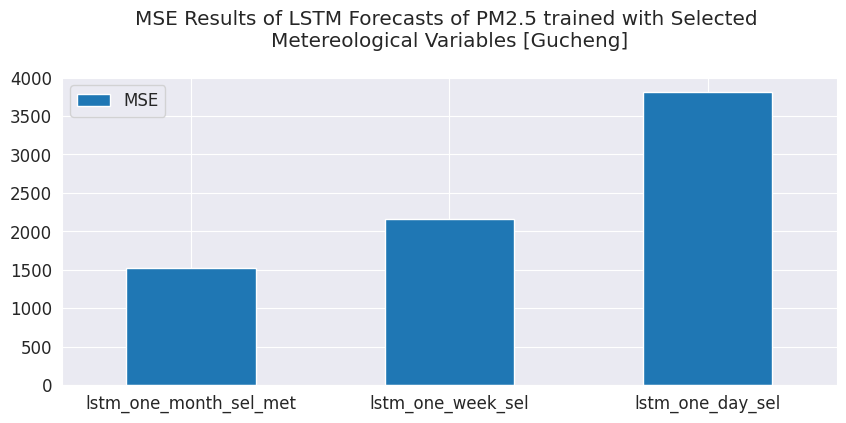

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[1,:].sort_values().plot.bar(
    title='MSE Results of LSTM Forecasts of PM2.5 trained with Selected \nMetereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

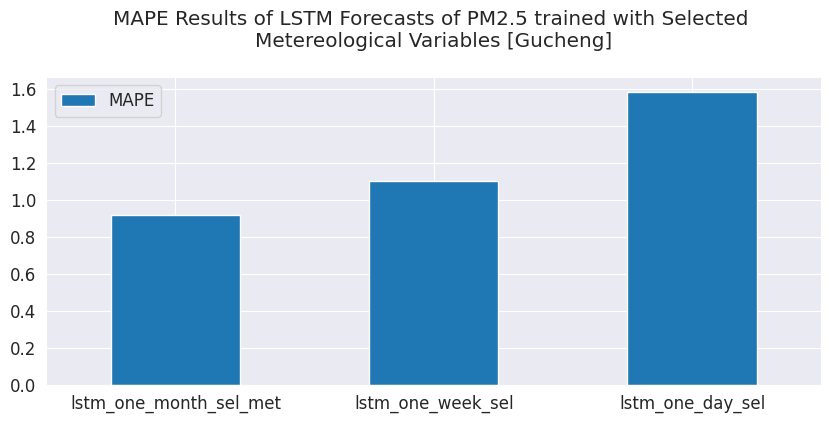

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[-1,:].sort_values().plot.bar(
    title='MAPE Results of LSTM Forecasts of PM2.5 trained with Selected \nMetereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

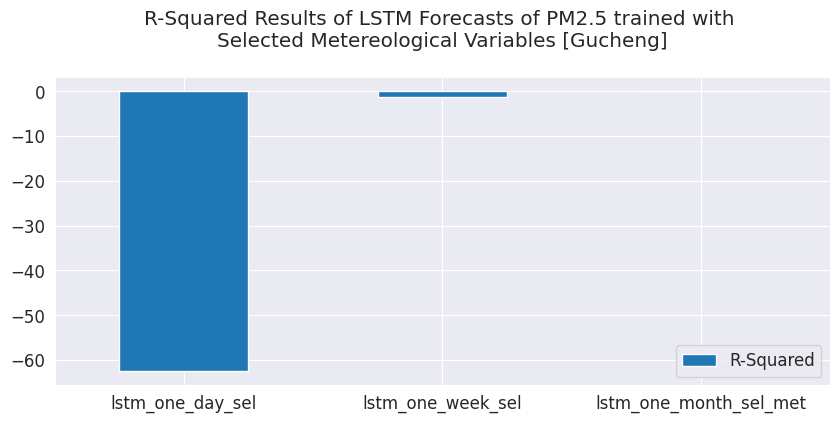

In [ ]:
lstm_results_pm25_with_sel_met_vars.iloc[-2,:].sort_values().plot.bar(
    title='R-Squared Results of LSTM Forecasts of PM2.5 trained with \nSelected Metereological Variables [Gucheng]\n', 
    figsize=(10,4), rot=0)
plt.legend()

In [ ]:
# Saving results
lstm_results_pm25_with_sel_met_vars.to_csv(f'{RESULTS_PATH}/lstm_results_pm25_with_selected_met_vars_24lags_Gucheng.csv')

# COMPARATIVE ANALYSIS OF RESULTS

In [ ]:
cnn_no_met = pd.read_csv(f'{RESULTS_PATH}/combined_results_cnn_no_met_24lags_Gucheng.csv', index_col=[0])
cnn_sel_met = pd.read_csv(f'{RESULTS_PATH}/cnn_results_pm25_with_selected_met_vars_24lags_Gucheng.csv', index_col=[0])
cnn_all_met = pd.read_csv(f'{RESULTS_PATH}/cnn_results_pm25_with_all_met_vars_24lags_Gucheng.csv', index_col=[0])

lstm_no_met = pd.read_csv(f'{RESULTS_PATH}/combined_results_lstm_no_met_24lags_Gucheng.csv', index_col=[0])
lstm_sel_met = pd.read_csv(f'{RESULTS_PATH}/lstm_results_pm25_with_selected_met_vars_24lags_Gucheng.csv', index_col=[0])
lstm_all_met = pd.read_csv(f'{RESULTS_PATH}/lstm_results_pm25_with_all_met_vars_24lags_Gucheng.csv', index_col=[0])


## CNN Models Analysis

In [ ]:
cnn_no_met

cnn_one_day  cnn_one_week  cnn_one_month
MAE             13.581        11.926         15.925
MSE            288.699       271.536        500.622
RMSE            16.991        16.478         22.375
R-Squared       -0.382         0.653          0.702
MAPE             0.637         0.559          0.427

<Axes: title={'center': 'CNN Models Performances on PM2.5 Forecast @24lags without Considering \nExogenous Weather Variables [Gucheng]\n'}>

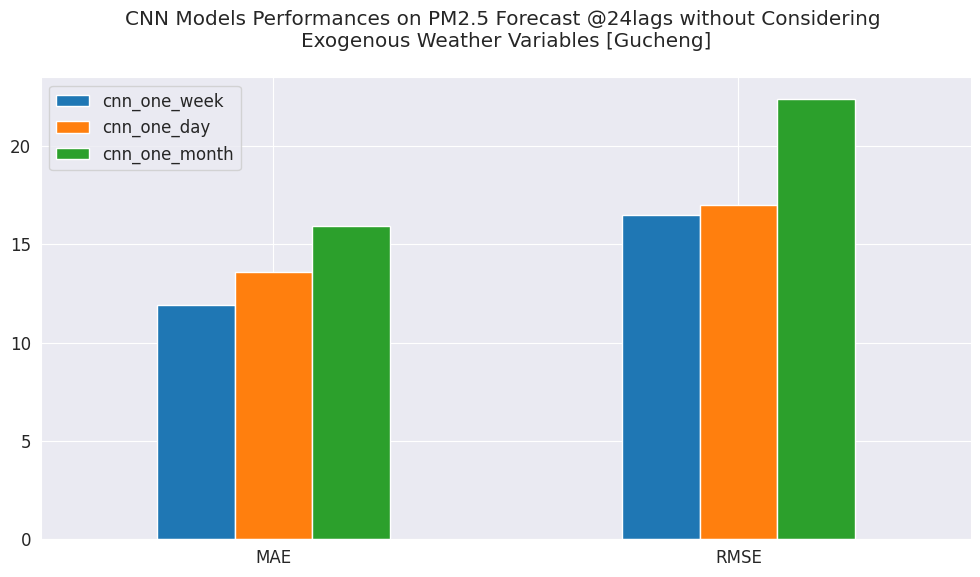

In [ ]:
cnn_no_met.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='CNN Models Performances on PM2.5 Forecast @24lags without Considering \nExogenous Weather Variables [Gucheng]\n',
    rot=0)

In [ ]:
cnn_all_met

cnn_one_day  cnn_one_week  cnn_one_month
MAE             10.423        33.033         31.770
MSE            157.933      1828.743       1710.658
RMSE            12.567        42.764         41.360
R-Squared       -1.627        -0.852         -0.036
MAPE             0.299         1.393          1.037

<Axes: title={'center': 'CNN Models Performances on PM2.5 Forecast @24lags Considering \nAll Exogenous Weather Variables [Gucheng]\n'}>

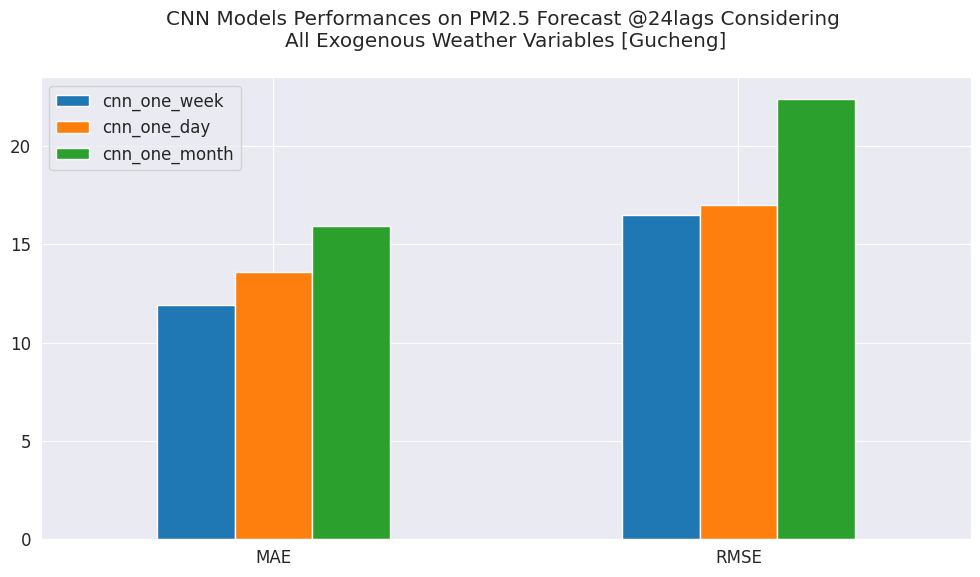

In [ ]:
cnn_no_met.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='CNN Models Performances on PM2.5 Forecast @24lags Considering \nAll Exogenous Weather Variables [Gucheng]\n',
    rot=0)

In [ ]:
cnn_sel_met

cnn_one_day_sel_met  cnn_one_week_sel  cnn_one_month_sel_met
MAE                     41.089            27.648                 34.881
MSE                   2595.678          1394.918               2230.837
RMSE                    50.948            37.349                 47.232
R-Squared              -42.173            -0.413                 -0.351
MAPE                     1.056             0.856                  0.995

<Axes: title={'center': 'CNN Models Performances on PM2.5 Forecast @24lags without Considering Selected \nStrongly Correlated Exogenous Weather Variables [Gucheng]\n'}>

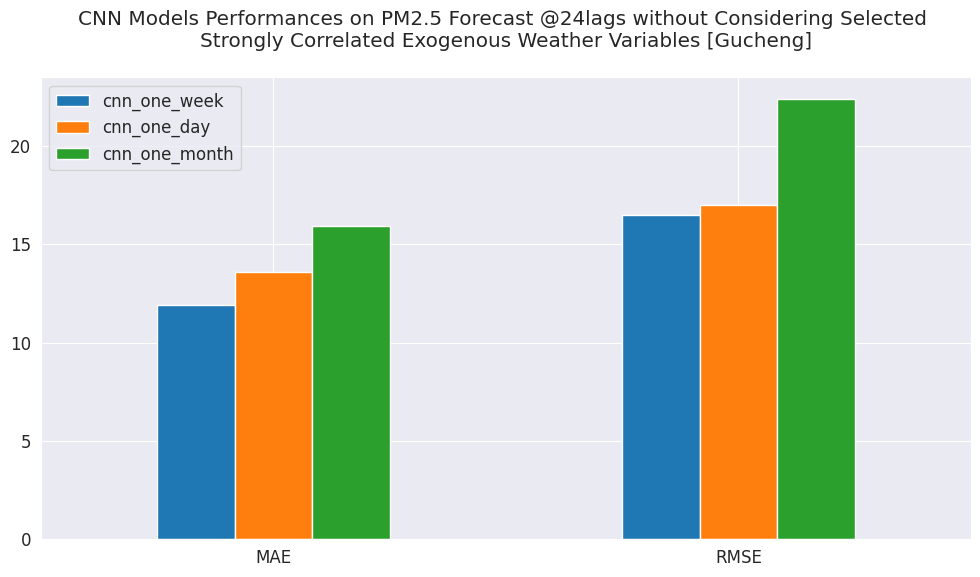

In [ ]:
# Considering DEWP (dew point), wd (wind direction), TEMP (temperature) and WSPM (wind speed)

cnn_no_met.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='CNN Models Performances on PM2.5 Forecast @24lags without Considering Selected \nStrongly Correlated Exogenous Weather Variables [Gucheng]\n',
    rot=0)

## LSTM Models Performances

In [ ]:
lstm_no_met

lstm_one_day  lstm_one_week  lstm_one_month
MAE              11.035          6.885           9.099
MSE             192.053         96.755         233.350
RMSE             13.858          9.836          15.276
R-Squared         0.081          0.876           0.861
MAPE              0.412          0.300           0.230

<Axes: title={'center': 'LSTM Models Performances on PM2.5 Forecast @24lags without Considering \nExogenous Weather Variables [Gucheng]\n'}>

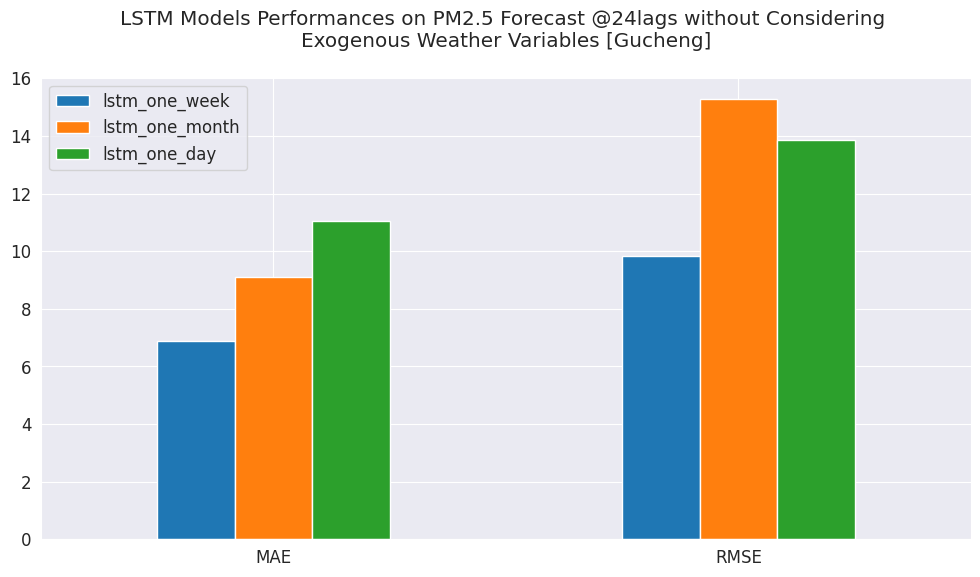

In [ ]:
lstm_no_met.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='LSTM Models Performances on PM2.5 Forecast @24lags without Considering \nExogenous Weather Variables [Gucheng]\n',
    rot=0)

In [ ]:
lstm_all_met

lstm_one_day  lstm_one_week  lstm_one_month
MAE              23.756         27.745          26.749
MSE             744.963       1174.240        1141.651
RMSE             27.294         34.267          33.788
R-Squared       -11.391         -0.189           0.309
MAPE              0.737          0.878           0.846

<Axes: title={'center': 'LSTM Models Performances on PM2.5 Forecast @24lags Considering \nAll Exogenous Weather Variables [Gucheng]\n'}>

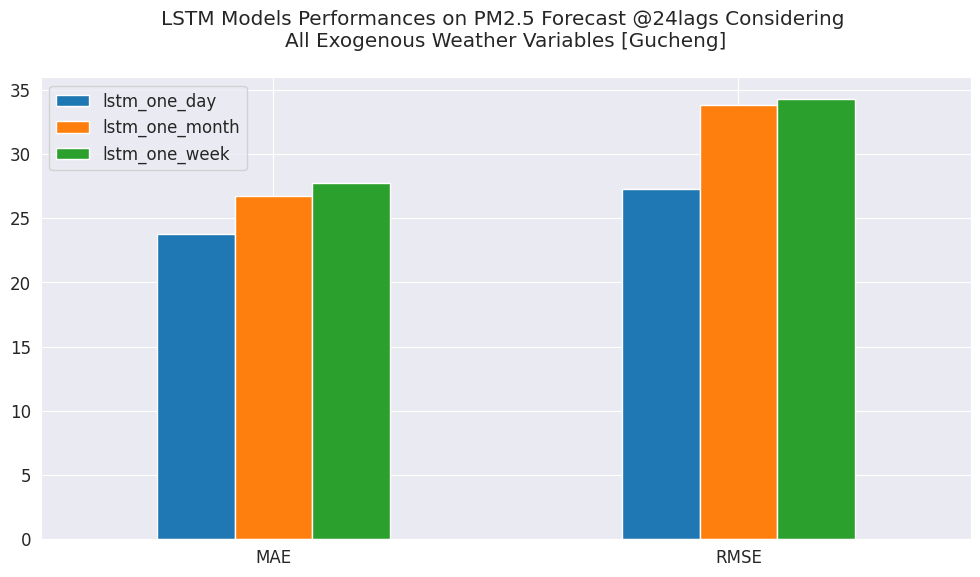

In [ ]:
lstm_all_met.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='LSTM Models Performances on PM2.5 Forecast @24lags Considering \nAll Exogenous Weather Variables [Gucheng]\n',
    rot=0)

In [ ]:
lstm_sel_met

lstm_one_day_sel  lstm_one_week_sel  lstm_one_month_sel_met
MAE                  57.321             38.358                  30.434
MSE                3815.625           2159.805                1523.549
RMSE                 61.771             46.474                  39.033
R-Squared           -62.463             -1.187                   0.077
MAPE                  1.585              1.100                   0.921

<Axes: title={'center': 'LSTM Models Performances on PM2.5 Forecast @24lags without Considering Selected \nStrongly Correlated Exogenous Weather Variables [Gucheng]\n'}>

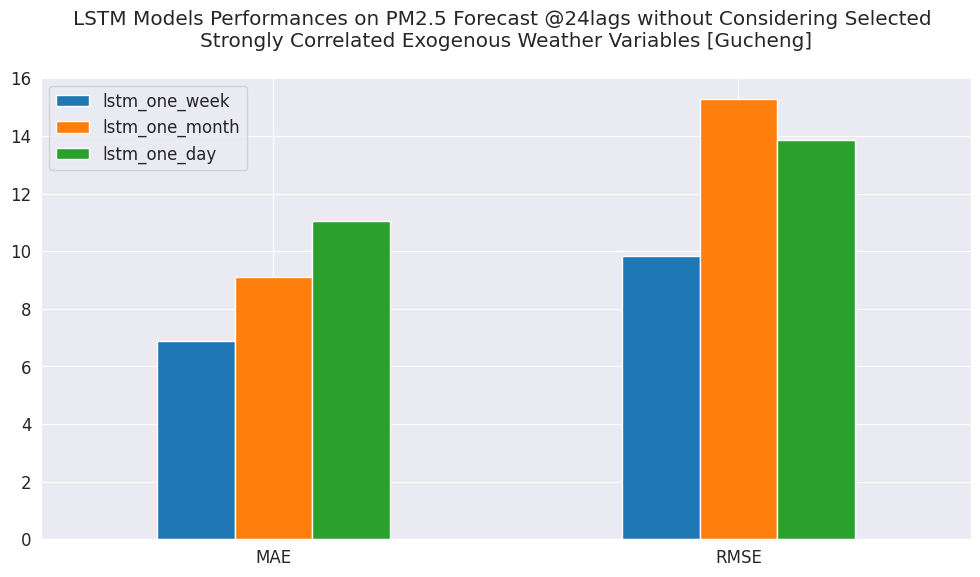

In [ ]:
# Considering DEWP (dew point), wd (wind direction), TEMP (temperature) and WSPM (wind speed)

lstm_no_met.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='LSTM Models Performances on PM2.5 Forecast @24lags without Considering Selected \nStrongly Correlated Exogenous Weather Variables [Gucheng]\n',
    rot=0)

## CNN vs LSTM

### PM2.5 only

In [ ]:
# MAE
perf = pd.concat([cnn_no_met.iloc[[0,2],:], lstm_no_met.iloc[[0,2],:]], axis='columns')
perf.T.sort_values(by='MAE')

MAE    RMSE
lstm_one_week    6.885   9.836
lstm_one_month   9.099  15.276
lstm_one_day    11.035  13.858
cnn_one_week    11.926  16.478
cnn_one_day     13.581  16.991
cnn_one_month   15.925  22.375

Text(0, 0.5, 'Errors')

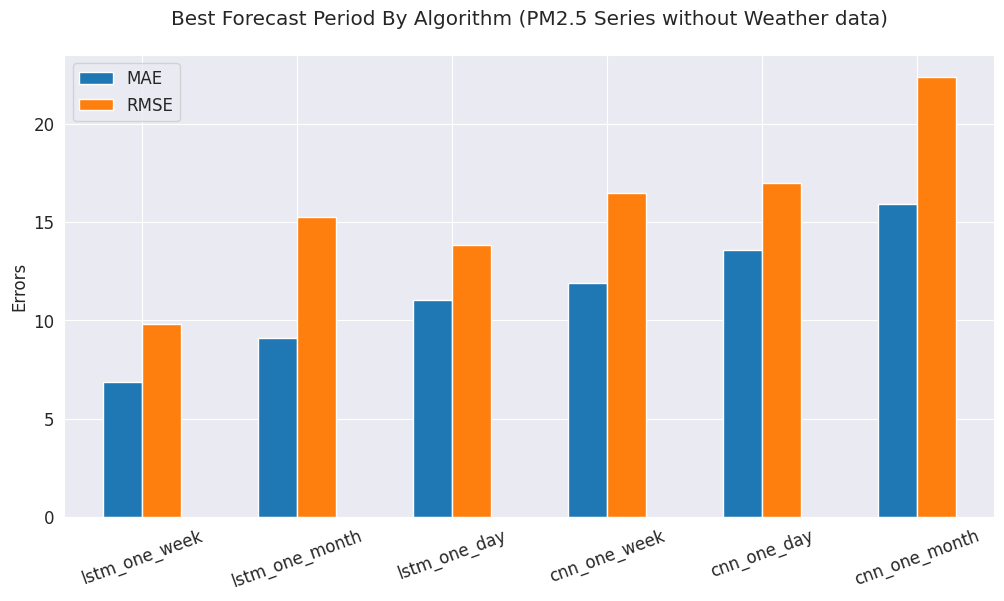

In [ ]:
perf.T.sort_values(by='MAE').plot.bar(
    title='Best Forecast Period By Algorithm (PM2.5 Series without Weather data)\n',
    rot=20)
plt.ylabel('Errors')

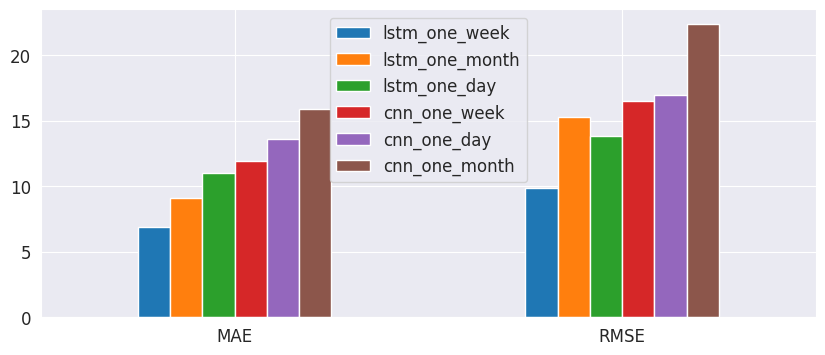

In [ ]:
perf.T.sort_values(by='MAE').T.plot.bar(figsize=(10,4), rot=0)
plt.legend(loc='upper center')

### PM2.5 only + All Weather Data

In [ ]:
# MAE
perf = pd.concat([cnn_all_met.iloc[[0,2],:], lstm_all_met.iloc[[0,2],:]], axis='columns')
perf.T.sort_values(by='MAE')

MAE    RMSE
cnn_one_day     10.423  12.567
lstm_one_day    23.756  27.294
lstm_one_month  26.749  33.788
lstm_one_week   27.745  34.267
cnn_one_month   31.770  41.360
cnn_one_week    33.033  42.764

Text(0, 0.5, 'Errors')

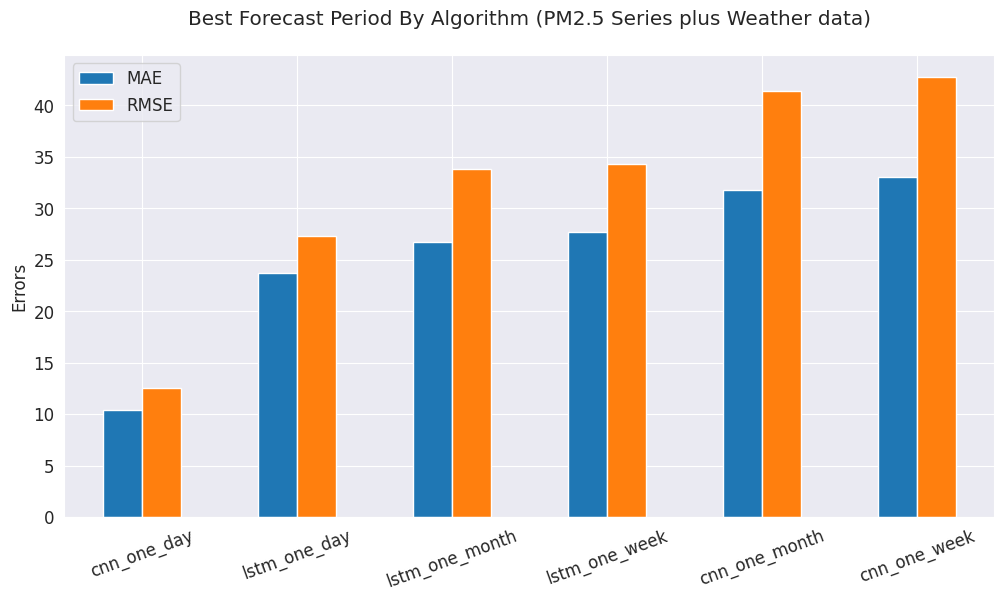

In [ ]:
perf.T.sort_values(by='MAE').plot.bar(
    title='Best Forecast Period By Algorithm (PM2.5 Series plus Weather data)\n',
    rot=20)
plt.ylabel('Errors')

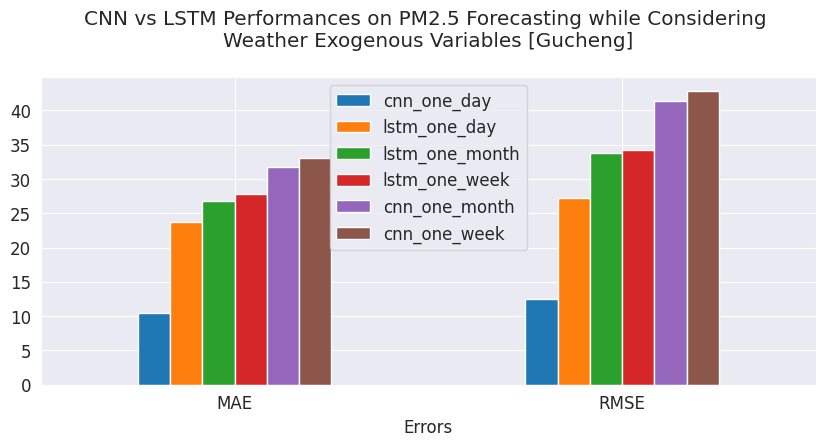

In [ ]:
perf.T.sort_values(by='MAE').T.plot.bar(figsize=(10,4), rot=0)
plt.xlabel('Errors')
plt.title('CNN vs LSTM Performances on PM2.5 Forecasting while Considering \nWeather Exogenous Variables [Gucheng]\n')
plt.legend(loc='upper center')

TypeError: ignored

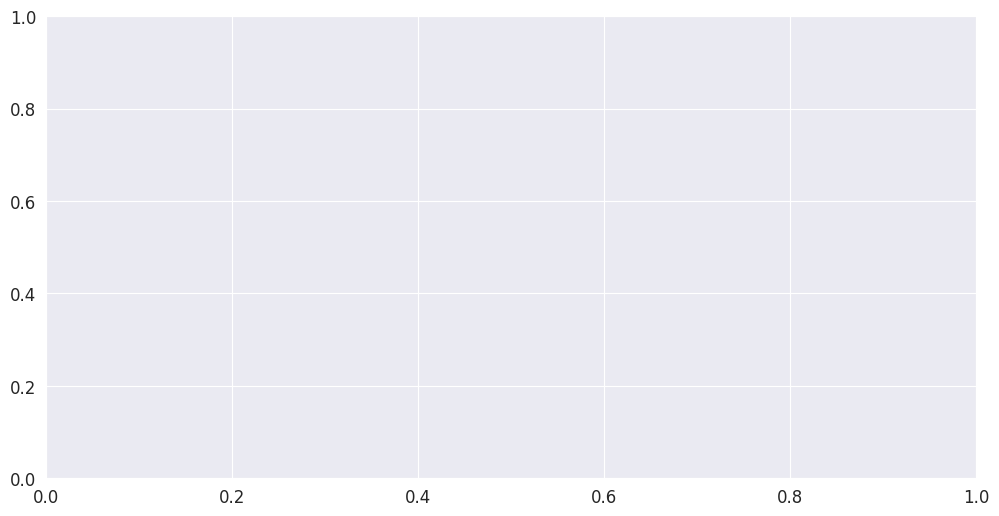

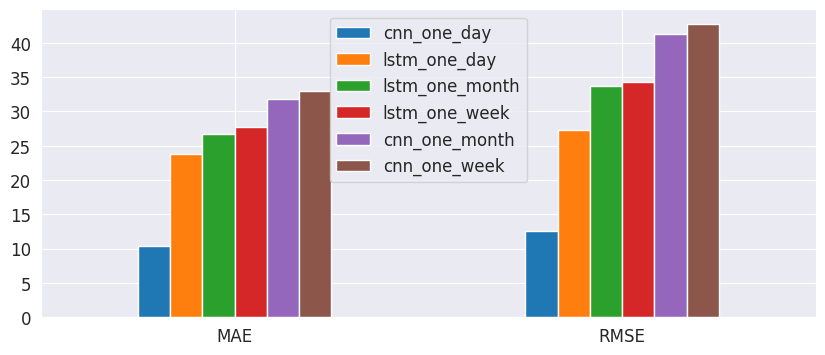

In [ ]:


fig, ax = plt.subplots()
bars = perf.T.sort_values(by='MAE').T.plot.bar(figsize=(10,4), rot=0)
for bar in bars:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      weight='bold'
  )

fig.tight_layout()

## OPTIMIZATION with Parameter Tunning (using ray-tune random_search strategy)

## OPTIMIZATION

### Hyper-parameter Tunning

- Ray Tune

In [ ]:
# train = lstm_pm25_data.iloc[:-TEST_SIZE]
# test = lstm_pm25_data.iloc[-TEST_SIZE:]

# print(f'Train set Date Range: {train.index.min()} --- {train.index.max()}')
# print(f'Test Set Date Range: {test.index.min()} --- {test.index.max()}')




# lstm_auto_models = [
#     AutoLSTM(h=STEPS, num_samples=N_SAMPLES, loss=LOSS)
# ]

# lstm_model = NeuralForecast(models=lstm_auto_models, freq='H')

# # Fitting the model
# lstm_model.fit(train)
# predictions = lstm_model.predict().reset_index()
# predictions.head()

Train set Date Range: 2013-03-01 00:00:00 --- 2016-05-12 19:00:00
Test Set Date Range: 2016-05-12 20:00:00 --- 2017-02-28 23:00:00


In [ ]:
class LSTM_BiDi_Trainer:
    def __init__(self, Xtrain, ytrain, Xval=None, yval=None, 
               loss='mean_squared_error', n_lags=24, 
               n_features=6, n_outputs=1, epochs=150):
      
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xval = Xval
        self.yval = yval
        self.loss = loss
        self.n_lags = n_lags
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.epochs = epochs

    # functional encoder_decoder LSTM implementation
    def train(self, config):

        lstm_model = Sequential([
            # Bi-directional input layer 1
            Bidirectional(LSTM(config['n_encoder_decoder_h_filters'], return_sequences=True), 
                    input_shape=(N_LAGS, N_FEATURES)),
            # output of layer 1
            Dense(20, activation='tanh'),

            # Bi-directional input layer 2
            Bidirectional(LSTM(int(config['n_encoder_decoder_h_filters'] / 4 * 3))),
            # output of layer 1 and output of layer 2
            Dense(20, activation='tanh'), # layer 1 hidden-state
            Dense(20, activation='tanh'), # layer 2 hidden-state
            Dropout(0.25),

            # Output layer
            Dense(units=self.n_outputs),
        ])

        # optimizer
        optimizer = Adam(learning_rate= config['lr'])
        if config['optimizer'] != 'adam':
            optimizer = SGD(learning_rate= config['lr'])

        lstm_model.compile(
            optimizer=optimizer, 
            loss=self.loss, 
            metrics=[
              MeanAbsoluteError(),
              RootMeanSquaredError(),
              MeanAbsolutePercentageError()
            ])

        lstm_model.summary()

        # callbacks (EarlyStopper to avoid overfitting)
        early_stopper = EarlyStopping(
            monitor="loss",
            min_delta=0.05,  # p-value (significance)
            patience=5,
            restore_best_weights=True,
        )

        lr_reducer = LearningRateScheduler(lambda lr: 1e-3 * 0.90 ** lr)

        # Fitting the model
        lstm_model.fit(
            self.Xtrain, self.ytrain, # validation_data=(deep_Xval, deep_yval), 
            batch_size=config['batch_size'], 
            epochs = self.epochs, verbose=0, 
            callbacks=[
                    lr_reducer, early_stopper, 
                    TuneReportCallback({"mean_squared_error": "mean_squared_error"})
                ])


        return {"mean_squared_error": 'mean_squared_error'}


In [ ]:
class LSTM_Trainer:
    def __init__(self, Xtrain, ytrain, Xval=None, yval=None, 
               loss='mean_squared_error', n_lags=24, 
               n_features=6, n_outputs=1, epochs=150):
      
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xval = Xval
        self.yval = yval
        self.n_lags = n_lags
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.epochs = epochs

    # functional encoder_decoder LSTM implementation
    def train(self, config):
      
        # ENCODER
        #--------

        # Input layer
        encoder_inputs = Input(shape=(self.n_lags, self.n_features))

        # Layer 1 - encoder
        encoder_l1 = LSTM(config['n_encoder_decoder_h_filters'], return_sequences = True, return_state=True)
        encoder_outputs1 = encoder_l1(encoder_inputs)
        encoder_states1 = encoder_outputs1[1:]

        # Layer2 - encoder
        encoder_l2 = LSTM(config['n_encoder_decoder_h_filters'], return_state=True)
        encoder_outputs2 = encoder_l2(encoder_outputs1[0])
        encoder_states2 = encoder_outputs2[1:]


        # DECODER
        #---------

        # decoder input
        decoder_inputs = RepeatVector(STEPS)(encoder_outputs2[0])

        # Layer 1 - decoder
        decoder_l1 = LSTM(
            config['n_encoder_decoder_h_filters'], 
            return_sequences=True)(
                decoder_inputs, initial_state = encoder_states1)

        # layer 2- decoder
        decoder_l2 = LSTM(
            config['n_encoder_decoder_h_filters'],
            return_sequences=True)(
                decoder_l1, initial_state = encoder_states2)
        decoder_outputs2 = TimeDistributed(Dense(self.n_outputs))(decoder_l2)

        # Output layer
        model_e2d2 = Model(encoder_inputs, decoder_outputs2)


        # optimizer
        optimizer = Adam(learning_rate= config['lr'])
        if config['optimizer'] != 'adam':
            optimizer = SGD(learning_rate= config['lr'])

        # Compiling the RNN
        model_e2d2.compile(
            optimizer = optimizer, 
            loss = self.loss, 
            metrics = [
              MeanAbsoluteError(),
              MeanAbsolutePercentageError(),
              RootMeanSquaredError()
            ])

        lr_reducer = LearningRateScheduler(lambda lr: 1e-3 * 0.90 ** lr)

        # Fitting the model
        model_e2d2.fit(
            self.Xtrain,
            self.ytrain,
            batch_size=config['batch_size'],
            epochs=self.epochs,
            verbose=0,
            #validation_data=(self.Xval, self. yval),
            callbacks=[lr_reducer, TuneReportCallback({"mean_squared_error": "mean_squared_error"})],
        )

        return {"mean_squared_error": 'mean_squared_error'}


In [ ]:
class CNN_Trainer:
    def __init__(self, Xtrain, ytrain, Xval=None, yval=None, 
               n_lags=24, loss='mse', n_steps=24*7, 
               n_features=6, n_outputs=1, epochs=150):
      
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xval = Xval
        self.yval = yval
        self.n_lags = n_lags
        self.loss = loss
        self.n_steps = n_steps
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.epochs = epochs

    def train(self, config):

        cnn_model_exo = Sequential()

        # input layer and hidden layer1
        cnn_model_exo.add(Conv1D(filters=256, kernel_size=2, activation='relu', 
                                      input_shape=(self.n_lags, self.n_features)))
        
        cnn_model_exo.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Dropout(config['dropouts']))
        cnn_model_exo.add(MaxPooling1D(pool_size=2))

        cnn_model_exo.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Dropout(config['dropouts']))
        cnn_model_exo.add(MaxPooling1D(pool_size=2))

        cnn_model_exo.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
        cnn_model_exo.add(Dropout(config['dropouts']))
        cnn_model_exo.add(MaxPooling1D(pool_size=2))

        cnn_model_exo.add(Flatten())
        cnn_model_exo.add(Dense(units=16, activation='relu'))

        # Output layer
        cnn_model_exo.add(Dense(units=self.n_outputs))

        # optimizer
        optimizer = Adam(learning_rate= config['lr'])
        if config['optimizer'] != 'adam':
            optimizer = SGD(learning_rate= config['lr'])

        # Compiling
        cnn_model_exo.compile(
            optimizer=optimizer, 
            loss=self.loss, 
            metrics=[
                MeanAbsoluteError(),
                MeanAbsolutePercentageError(),
                MeanSquaredError(),
                RootMeanSquaredError()
            ]
          )

        # Fitting
        cnn_model_exo.fit(
            self.Xtrain,
            self.ytrain,
            batch_size=config['batch_size'],
            epochs=self.epochs,
            verbose=0,
            # validation_data=(self.Xval, self.yval),
            callbacks=[TuneReportCallback({"mean_squared_error": "mean_squared_error"})],
        )


        return {"mean_squared_error": 'mean_squared_error'}


In [ ]:
def tune_DeepLearningModel(model_trainer_fn, search_space, n_samples=30, 
                           num_training_iterations=150, 
                           metric='mean_squared_error', obj='min'):
    
    # using HyperBand Scheduler Strategy
    sched = AsyncHyperBandScheduler(
        time_attr="training_iteration", max_t=400, grace_period=20
    )
    

    # Tunning
    tuner = tune.Tuner(
        tune.with_resources(model_trainer_fn, resources={"cpu": 2, "gpu": 0}),
        tune_config=tune.TuneConfig(
            metric=metric,
            mode=obj,
            scheduler=sched,
            num_samples=n_samples,
            time_budget_s=60*45, # 45 mins max
        ),
        run_config=air.RunConfig(
            name="exp",
            stop={"mean_squared_error": 4, "training_iteration": num_training_iterations},
        ),
        param_space=search_space,
    )

    # getting results
    results = tuner.fit()
    print("Best hyperparameters found were: ", results.get_best_result().config)

In [ ]:
# # RUN this cell if trainer failed at any point

# tuner = Tuner.restore(results.experiment_path, trainable=trainer)
# tuner.fit()

##### Tunning LSTM Hyperparameters

In [ ]:
lstm_search_space = {
    'n_encoder_decoder_h_filters': tune.choice([128, 256]),
    'n_enc_dec_layers': tune.choice([4, 6]),
    'dropouts': tune.choice([0.2, 0.3]),
    'optimizer': tune.choice(['adam', 'sgd']),
    'lr': tune.choice([0.0001, 0.001, 0.01]),
    'batch_size': tune.choice([20, 32]),
    # 'momentum': tune.uniform(0.1, 0.9)
}

In [ ]:
lstm_trainer = LSTM_Trainer(Xtrain=deep_Xtrain, ytrain=deep_ytrain, 
               loss='mean_squared_error', n_lags=24, 
               n_features=1, n_outputs=1, epochs=150)

tune_DeepLearningModel(
    model_trainer_fn = lstm_trainer.train, 
    search_space=lstm_search_space, 
    n_samples=30, 
    num_training_iterations=15, 
    metric='mean_squared_error', 
    obj='min')

2023-05-18 15:46:00,213	WARNING tune.py:184 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-05-18 15:46:02,253	ERROR tune.py:941 -- Trials did not complete: [_trainable_7ed8d_00000, _trainable_7ed8d_00001, _trainable_7ed8d_00002, _trainable_7ed8d_00003, _trainable_7ed8d_00004, _trainable_7ed8d_00005, _trainable_7ed8d_00006, _trainable_7ed8d_00007, _trainable_7ed8d_00008, _trainable_7ed8d_00009, _trainable_7ed8d_00010, _trainable_7ed8d_00011, _trainable_7ed8d_00012, _trainable_7ed8d_00013, _trainable_7ed8d_00014, _trainable_7ed8d_00015]
2023-05-18 15:46:02,254	INFO tune.py:945 -- Total run time: 256.25 seconds (256.15 seconds for the tuning loop).
2023-05-18 15:46:02,257	WARNING tune.py:954 -- Experiment has been interrupted, but the most recent state was saved.
Continue running this experiment with: Tuner.restore(path="/root/ray_results/exp

RuntimeError: ignored

##### Tunning CNN Hyperparameters

In [ ]:
cnn_search_space = {
    'dropouts': tune.choice([0.2, 0.3]),
    'optimizer': tune.choice(['adam', 'sgd']),
    'lr': tune.choice([0.0001, 0.001, 0.01]),
    'batch_size': tune.choice([20, 32]),
    # 'momentum': tune.uniform(0.1, 0.9),

}

In [ ]:
cnn_trainer = CNN_Trainer(Xtrain=deep_Xtrain, ytrain=deep_ytrain, 
               loss='mean_squared_error', n_lags=24, 
               n_features=1, n_outputs=1, epochs=150)

tune_DeepLearningModel(
    model_trainer_fn = cnn_trainer.train, 
    search_space=cnn_search_space, 
    n_samples=30, 
    num_training_iterations=15, 
    metric='mean_squared_error', 
    obj='min')

NameError: ignored

# Gucheng Station